In [2]:
import numpy as np
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

# from data_loading import sine_data_generation
# from utils import random_generator
# from data_loading import MinMaxScaler

from torch.utils.data import DataLoader


# from utils import extract_time


In [3]:
def train_test_divide (data_x, data_x_hat, data_t, data_t_hat, train_rate = 0.8):
  """ Divide train and test data for both original and synthetic data.
  
  Args:
    - data_x: original data
    - data_x_hat: generated data
    - data_t: original time
    - data_t_hat: generated time
    - train_rate: ratio of training data from the original data
  """
  # Divide train/test index (original data)
  no = len(data_x)
  idx = np.random.permutation(no)
  train_idx = idx[:int(no*train_rate)]
  test_idx = idx[int(no*train_rate):]
    
  train_x = [data_x[i] for i in train_idx]
  test_x = [data_x[i] for i in test_idx]
  train_t = [data_t[i] for i in train_idx]
  test_t = [data_t[i] for i in test_idx]      
    
  # Divide train/test index (synthetic data)
  no = len(data_x_hat)
  idx = np.random.permutation(no)
  train_idx = idx[:int(no*train_rate)]
  test_idx = idx[int(no*train_rate):]
  
  train_x_hat = [data_x_hat[i] for i in train_idx]
  test_x_hat = [data_x_hat[i] for i in test_idx]
  train_t_hat = [data_t_hat[i] for i in train_idx]
  test_t_hat = [data_t_hat[i] for i in test_idx]
  
  return train_x, train_x_hat, test_x, test_x_hat, train_t, train_t_hat, test_t, test_t_hat


def extract_time (data):
  """Returns Maximum sequence length and each sequence length.
  
  Args:
    - data: original data
    
  Returns:
    - time: extracted time information
    - max_seq_len: maximum sequence length
  """
  time = list()
  max_seq_len = 0
  for i in range(len(data)):
    max_seq_len = max(max_seq_len, len(data[i][:,0]))
    time.append(len(data[i][:,0]))
    
  return time, max_seq_len

def random_generator (batch_size, z_dim, T_mb, max_seq_len):
  """Random vector generation.
  
  Args:
    - batch_size: size of the random vector
    - z_dim: dimension of random vector
    - T_mb: time information for the random vector
    - max_seq_len: maximum sequence length
    
  Returns:
    - Z_mb: generated random vector
  """
  Z_mb = list()
  for i in range(batch_size):
    temp = np.zeros([max_seq_len, z_dim])
    temp_Z = np.random.uniform(0., 1, [T_mb[i], z_dim])
    temp[:T_mb[i],:] = temp_Z
    Z_mb.append(temp_Z)
  return Z_mb


def batch_generator(data, time, batch_size):
  """Mini-batch generator.
  
  Args:
    - data: time-series data
    - time: time information
    - batch_size: the number of samples in each batch
    
  Returns:
    - X_mb: time-series data in each batch
    - T_mb: time information in each batch
  """
  no = len(data)
  idx = np.random.permutation(no)
  train_idx = idx[:batch_size]     
            
  X_mb = list(data[i] for i in train_idx)
  T_mb = list(time[i] for i in train_idx)
  
  return X_mb, T_mb

In [4]:
def MinMaxScaler(data):
  """Min Max normalizer.
  
  Args:
    - data: original data
  
  Returns:
    - norm_data: normalized data
  """
  numerator = data - np.min(data, 0)
  denominator = np.max(data, 0) - np.min(data, 0)
  norm_data = numerator / (denominator + 1e-7)
  return norm_data


def sine_data_generation (no, seq_len, dim):
  """Sine data generation.
  
  Args:
    - no: the number of samples
    - seq_len: sequence length of the time-series
    - dim: feature dimensions
    
  Returns:
    - data: generated data
  """  
  # Initialize the output
  data = list()

  # Generate sine data
  for i in range(no):      
    # Initialize each time-series
    temp = list()
    # For each feature
    for k in range(dim):
      # Randomly drawn frequency and phase
      freq = np.random.uniform(0, 0.1)            
      phase = np.random.uniform(0, 0.1)
          
      # Generate sine signal based on the drawn frequency and phase
      temp_data = [np.sin(freq * j + phase) for j in range(seq_len)] 
      temp.append(temp_data)
        
    # Align row/column
    temp = np.transpose(np.asarray(temp))        
    # Normalize to [0,1]
    temp = (temp + 1)*0.5
    # Stack the generated data
    data.append(temp)
                
  return data
    

def real_data_loading (data_name, seq_len):
  """Load and preprocess real-world datasets.
  
  Args:
    - data_name: stock or energy
    - seq_len: sequence length
    
  Returns:
    - data: preprocessed data.
  """  
  assert data_name in ['stock','energy']
  
  if data_name == 'stock':
    ori_data = np.loadtxt('data/stock_data.csv', delimiter = ",",skiprows = 1)
  elif data_name == 'energy':
    ori_data = np.loadtxt('data/energy_data.csv', delimiter = ",",skiprows = 1)
        
  # Flip the data to make chronological data
  ori_data = ori_data[::-1]
  # Normalize the data
  ori_data = MinMaxScaler(ori_data)
    
  # Preprocess the dataset
  temp_data = []    
  # Cut data by sequence length
  for i in range(0, len(ori_data) - seq_len):
    _x = ori_data[i:i + seq_len]
    temp_data.append(_x)
        
  # Mix the datasets (to make it similar to i.i.d)
  idx = np.random.permutation(len(temp_data))    
  data = []
  for i in range(len(temp_data)):
    data.append(temp_data[idx[i]])
    
  return data

Define Class for Module Construction

In [20]:
class Time_GAN_module(nn.Module):
    """
    Class from which a module of the Time GAN Architecture can be constructed, 
    consisting of a n_layer stacked RNN layers and a fully connected layer
    
    input_size = dim of data (depending if module operates on latent or non-latent space)
    """
    def __init__(self, input_size, output_size, hidden_dim, n_layers, activation=torch.sigmoid):
        super(Time_GAN_module, self).__init__()

        # Parameters
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.sigma = activation

        #Defining the layers
        # RNN Layer
        self.rnn = nn.GRU(input_size, hidden_dim, n_layers, batch_first=True)   
        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_size)
        
    def forward(self, x):
    
            batch_size = x.size(0)

            # Initializing hidden state for first input using method defined below
            hidden = self.init_hidden(batch_size)

            # Passing in the input and hidden state into the model and obtaining outputs
            out, hidden = self.rnn(x, hidden)
        
            # Reshaping the outputs such that it can be fit into the fully connected layer
            out = out.contiguous().view(-1, self.hidden_dim)
            out = self.fc(out)
            
            if self.sigma == nn.Identity:
                idendity = nn.Identity()
                return idendity(out)
                
            out = self.sigma(out)
            
            # HIDDEN STATES WERDEN IN DER PAPER IMPLEMENTIERUNG AUCH COMPUTED, ALLERDINGS NICHT BENUTZT?
            
            return out, hidden
    
    def init_hidden(self, batch_size):
        # This method generates the first hidden state of zeros which we'll use in the forward pass
        # We'll send the tensor holding the hidden state to the device we specified earlier as well
        hidden = torch.zeros(self.n_layers, batch_size, self.hidden_dim)
        return hidden

Parameters

In [47]:
input_size = 5 # sequence length = number of features
output_size = 20
hidden_dim = 40
n_layers = 1
gamma = 1

no, seq_len, dim = 12800, 24, 1

batch_size = 128
epoch = 100

Data Generation

In [14]:
data = sine_data_generation(no, seq_len, dim)
data = MinMaxScaler(data)
data = torch.Tensor(data)
data.shape

torch.Size([12800, 24, 1])

Create Modules

In [ ]:
# embedder: num_layers = num_layers, fully_connected dim = hidden_dim
# recovery: num_layers = num_layers, fully_connected dim = dim 
# generator: num layers = num_layers, fully_connected dim = hidden_dim
# supervisor: num_layers = num_layers-1, fully_connected dim = hidden_dim
# discriminator: num_layers = num_layers, fully_connected dim = 1

In [7]:
Embedder = Time_GAN_module(input_size=dim, output_size=hidden_dim, hidden_dim=hidden_dim, n_layers=n_layers)
Embedder

Time_GAN_module(
  (rnn): GRU(1, 20, num_layers=3, batch_first=True)
  (fc): Linear(in_features=20, out_features=20, bias=True)
)

In [8]:
Recovery = Time_GAN_module(input_size=hidden_dim, output_size=dim, hidden_dim=hidden_dim, n_layers=n_layers)
Recovery

Time_GAN_module(
  (rnn): GRU(20, 20, num_layers=3, batch_first=True)
  (fc): Linear(in_features=20, out_features=1, bias=True)
)

In [9]:
Generator = Time_GAN_module(input_size=dim, output_size=hidden_dim, hidden_dim=hidden_dim, n_layers=n_layers)
Generator

Time_GAN_module(
  (rnn): GRU(1, 20, num_layers=3, batch_first=True)
  (fc): Linear(in_features=20, out_features=20, bias=True)
)

In [10]:
Supervisor = Time_GAN_module(input_size=hidden_dim, output_size=hidden_dim, hidden_dim=hidden_dim, n_layers=n_layers)
Supervisor

Time_GAN_module(
  (rnn): GRU(20, 20, num_layers=3, batch_first=True)
  (fc): Linear(in_features=20, out_features=20, bias=True)
)

In [11]:
Discriminator = Time_GAN_module(input_size=hidden_dim, output_size=1, hidden_dim=hidden_dim, n_layers=n_layers, 
                               activation=nn.Identity)
Discriminator

Time_GAN_module(
  (rnn): GRU(20, 20, num_layers=3, batch_first=True)
  (fc): Linear(in_features=20, out_features=1, bias=True)
)

Create Optimizers

In [ ]:
embedder_optimizer = optim.Adam(Embedder.parameters(), lr=0.001)
recovery_optimizer = optim.Adam(Recovery.parameters(), lr=0.001)
supervisor_optimizer = optim.Adam(Recovery.parameters(), lr=0.001)
discriminator_optimizer = optim.Adam(Discriminator.parameters(), lr=0.001)
generator_optimizer = optim.Adam(Generator.parameters(), lr=0.001)

Data Loader

In [ ]:
loader = DataLoader(data, batch_size, shuffle=True)
X = next(iter(loader))
H, _ = Embedder(X.float())
H_re = torch.reshape(H, (batch_size, seq_len, hidden_dim))
H.shape, H_re.shape

In [ ]:
batch_size, seq_len, hidden_dim

In [17]:
random_data = random_generator(batch_size=batch_size, z_dim=dim, 
                                       T_mb=extract_time(data)[0], max_seq_len=extract_time(data)[1])

In [18]:
loader = DataLoader(data, batch_size, shuffle=True)

random_loader = DataLoader(random_data, batch_size, shuffle=True)

binary_cross_entropy_loss = nn.BCEWithLogitsLoss()

MSE_loss = nn.MSELoss()



In [ ]:
X = next(iter(loader))
X.shape

In [48]:
def TimeGAN(data, parameters):
  hidden_dim = parameters["hidden_dim"]
  num_layers = parameters["num_layers"]
  iterations = parameters["iterations"]
  batch_size = parameters["batch_size"]
  module = parameters["module"]
  epoch = parameters["epoch"]
  no, seq_len, dim = np.asarray(data).shape
  z_dim = dim
  gamma = 1

  Embedder = Time_GAN_module(input_size=z_dim, output_size=hidden_dim, hidden_dim=hidden_dim, n_layers=num_layers)
  Recovery = Time_GAN_module(input_size=hidden_dim, output_size=dim, hidden_dim=hidden_dim, n_layers=n_layers)
  Generator = Time_GAN_module(input_size=dim, output_size=hidden_dim, hidden_dim=hidden_dim, n_layers=n_layers)
  Supervisor = Time_GAN_module(input_size=hidden_dim, output_size=hidden_dim, hidden_dim=hidden_dim, n_layers=n_layers)
  Discriminator = Time_GAN_module(input_size=hidden_dim, output_size=1, hidden_dim=hidden_dim, n_layers=n_layers, activation=nn.Identity)

  embedder_optimizer = optim.Adam(Embedder.parameters(), lr=0.001)
  recovery_optimizer = optim.Adam(Recovery.parameters(), lr=0.001)
  supervisor_optimizer = optim.Adam(Recovery.parameters(), lr=0.001)
  discriminator_optimizer = optim.Adam(Discriminator.parameters(), lr=0.001)
  generator_optimizer = optim.Adam(Generator.parameters(), lr=0.001)

  # Embedding Network Training
  print('Start Embedding Network Training')
  for e in range(epoch): 
    for batch_index, X in enumerate(loader):
        
        MSE_loss = nn.MSELoss()
        
        H, _ = Embedder(X.float())
        H = torch.reshape(H, (batch_size, seq_len, hidden_dim))

        X_tilde, _ = Recovery(H)
        X_tilde = torch.reshape(X_tilde, (batch_size, seq_len, dim))

        E_loss0 = 10 * torch.sqrt(MSE_loss(X, X_tilde))  

        Embedder.zero_grad()
        Recovery.zero_grad()

        E_loss0.backward(retain_graph=True)

        embedder_optimizer.step()
        recovery_optimizer.step()

        if e in range(1,epoch) and batch_index == 0:
            print('step: '+ str(e) + '/' + str(epoch) + ', e_loss: ' + str(np.sqrt(E_loss0.detach().numpy())))

  print('Finish Embedding Network Training')

  # Training only with supervised loss
  print('Start Training with Supervised Loss Only')
  for e in range(epoch): 
    for batch_index, X in enumerate(loader):

        H, _ = Embedder(X.float())
        H = torch.reshape(H, (batch_size, seq_len, hidden_dim))

        H_hat_supervise, _ = Supervisor(H)
        H_hat_supervise = torch.reshape(H_hat_supervise, (batch_size, seq_len, hidden_dim))  

        G_loss_S = MSE_loss(H[:,1:,:], H_hat_supervise[:,:-1,:])


        Embedder.zero_grad()
        Supervisor.zero_grad()

        G_loss_S.backward(retain_graph=True)

        embedder_optimizer.step()
        supervisor_optimizer.step()

        if e in range(1,epoch) and batch_index == 0:
            print('step: '+ str(e) + '/' + str(epoch) + ', s_loss: ' + str(np.sqrt(G_loss_S.detach().numpy())))

  print('Finish Training with Supervised Loss Only')
  # Joint Training
  

  print('Start Joint Training')
  for itt in range(epoch):
    for kk in range(2):
      X = next(iter(loader))
      random_data = random_generator(batch_size=batch_size, z_dim=dim, 
                                       T_mb=extract_time(data)[0], max_seq_len=extract_time(data)[1])
        
      # Generator Training 
      ## Train Generator
      z = torch.tensor(random_data)
      z = z.float()
        
      e_hat, _ = Generator(z)
      e_hat = torch.reshape(e_hat, (batch_size, seq_len, hidden_dim))
        
      H_hat, _ = Supervisor(e_hat)
      H_hat = torch.reshape(H_hat, (batch_size, seq_len, hidden_dim))
        
      Y_fake = Discriminator(H_hat)
      Y_fake = torch.reshape(Y_fake, (batch_size, seq_len, 1))
        
      x_hat, _ = Recovery(H_hat)
      x_hat = torch.reshape(x_hat, (batch_size, seq_len, dim))
        
      H, _ = Embedder(X.float())
      H = torch.reshape(H, (batch_size, seq_len, hidden_dim))

      H_hat_supervise, _ = Supervisor(H)
      H_hat_supervise = torch.reshape(H_hat_supervise, (batch_size, seq_len, hidden_dim))

      Generator.zero_grad()
      Supervisor.zero_grad()
      Discriminator.zero_grad()
      Recovery.zero_grad()

      # line 267 of original implementation: 
      # G_loss_U, G_loss_S, G_loss_V
      G_loss_S = MSE_loss(H[:,1:,:], H_hat_supervise[:,:-1,:])
      binary_cross_entropy_loss = nn.BCEWithLogitsLoss()
      G_loss_U = binary_cross_entropy_loss(torch.ones_like(Y_fake), Y_fake)
        
      G_loss_V1 = torch.mean(torch.abs((torch.std(x_hat, [0], unbiased = False)) + 1e-6 - (torch.std(X, [0]) + 1e-6)))
      G_loss_V2 = torch.mean(torch.abs((torch.mean(x_hat, [0]) - (torch.mean(X, [0])))))
      G_loss_V = G_loss_V1 + G_loss_V2
        
      # doing a backward step for each loss should result in gradients accumulating 
      # so we should be able to optimize them jointly
      G_loss_S.backward(retain_graph=True)#
      G_loss_U.backward(retain_graph=True)
      G_loss_V.backward(retain_graph=True)#


      generator_optimizer.step()
      supervisor_optimizer.step()
      discriminator_optimizer.step()
      # Train Embedder 
      ## line 270: we only optimize E_loss_T0
      ## E_loss_T0 = just mse of x and x_tilde
      # but it calls E_solver which optimizes E_loss, which is a sum of 
      # E_loss0 and 0.1* G_loss_S
      MSE_loss = nn.MSELoss()
        
      H, _ = Embedder(X.float())
      H = torch.reshape(H, (batch_size, seq_len, hidden_dim))

      X_tilde, _ = Recovery(H)
      X_tilde = torch.reshape(X_tilde, (batch_size, seq_len, dim))

      E_loss_T0 = MSE_loss(X, X_tilde)
      E_loss0 = 10 * torch.sqrt(MSE_loss(X, X_tilde))  
        
      H_hat_supervise, _ = Supervisor(H)
      H_hat_supervise = torch.reshape(H_hat_supervise, (batch_size, seq_len, hidden_dim))  

      G_loss_S = MSE_loss(H[:,1:,:], H_hat_supervise[:,:-1,:])
      E_loss = E_loss0  + 0.1 * G_loss_S
        
      G_loss_S.backward(retain_graph=True)
      E_loss_T0.backward()
        
      Embedder.zero_grad()
      Recovery.zero_grad()
      Supervisor.zero_grad()
        
      embedder_optimizer.step()
      recovery_optimizer.step()
      supervisor_optimizer.step()
    # train Discriminator
    for batch_index, X in enumerate(loader):
      random_data = random_generator(batch_size=batch_size, z_dim=dim, 
                                       T_mb=extract_time(data)[0], max_seq_len=extract_time(data)[1])
      
      z = torch.tensor(random_data)
      z = z.float()

      H, _ = Embedder(X)
      H = torch.reshape(H, (batch_size, seq_len, hidden_dim))

      Y_real = Discriminator(H)
      Y_real = torch.reshape(Y_real, (batch_size, seq_len, 1))
      
      e_hat, _ = Generator(z)
      e_hat = torch.reshape(e_hat, (batch_size, seq_len, hidden_dim))

      Y_fake_e = Discriminator(e_hat)
      Y_fake_e = torch.reshape(Y_fake_e, (batch_size, seq_len, 1))
        
      H_hat, _ = Supervisor(e_hat)
      H_hat = torch.reshape(H_hat, (batch_size, seq_len, hidden_dim))
        
      Y_fake = Discriminator(H_hat)
      Y_fake = torch.reshape(Y_fake, (batch_size, seq_len, 1))
        
      x_hat, _ = Recovery(H_hat)
      x_hat = torch.reshape(x_hat, (batch_size, seq_len, dim))

      Generator.zero_grad()
      Supervisor.zero_grad()
      Discriminator.zero_grad()
      Recovery.zero_grad()
      Embedder.zero_grad()

      # logits first, then targets
      # D_loss_real(Y_real, torch.ones_like(Y_real))
      D_loss_real = nn.BCEWithLogitsLoss()
      DLR = D_loss_real(Y_real, torch.ones_like(Y_real))

      D_loss_fake = nn.BCEWithLogitsLoss()
      DLF = D_loss_fake(Y_fake, torch.zeros_like(Y_fake))

      D_loss_fake_e = nn.BCEWithLogitsLoss()
      DLF_e = D_loss_fake_e(Y_fake_e, torch.zeros_like(Y_fake_e))

      D_loss = DLR + DLF + gamma * DLF_e

      # D_loss.backward(retain_graph=True)
      
      # discriminator_optimizer.step()

      # check discriminator loss before updating
      check_d_loss = D_loss
      if (check_d_loss > 0.15):
        D_loss.backward(retain_graph=True)
        discriminator_optimizer.step()        
        
      H, _ = Embedder(X.float())
      H = torch.reshape(H, (batch_size, seq_len, hidden_dim)) 
        
      X_tilde, _ = Recovery(H)
      X_tilde = torch.reshape(X_tilde, (batch_size, seq_len, dim))

      
      z = torch.tensor(random_data)
      z = z.float()
        
      e_hat, _ = Generator(z)
      e_hat = torch.reshape(e_hat, (batch_size, seq_len, hidden_dim))
        
      H_hat, _ = Supervisor(e_hat)
      H_hat = torch.reshape(H_hat, (batch_size, seq_len, hidden_dim))
        
      Y_fake = Discriminator(H_hat)
      Y_fake = torch.reshape(Y_fake, (batch_size, seq_len, 1))
        
      x_hat, _ = Recovery(H_hat)
      x_hat = torch.reshape(x_hat, (batch_size, seq_len, dim))
        
      H, _ = Embedder(X.float())
      H = torch.reshape(H, (batch_size, seq_len, hidden_dim))

      H_hat_supervise, _ = Supervisor(H)
      H_hat_supervise = torch.reshape(H_hat_supervise, (batch_size, seq_len, hidden_dim))

      G_loss_S = MSE_loss(H[:,1:,:], H_hat_supervise[:,:-1,:])
      binary_cross_entropy_loss = nn.BCEWithLogitsLoss()
      G_loss_U = binary_cross_entropy_loss(torch.ones_like(Y_fake), Y_fake)
        
      G_loss_V1 = torch.mean(torch.abs((torch.std(x_hat, [0], unbiased = False)) + 1e-6 - (torch.std(X, [0]) + 1e-6)))
      G_loss_V2 = torch.mean(torch.abs((torch.mean(x_hat, [0]) - (torch.mean(X, [0])))))
      G_loss_V = G_loss_V1 + G_loss_V2
    
      E_loss_T0 = MSE_loss(X, X_tilde)
      E_loss0 = 10 * torch.sqrt(MSE_loss(X, X_tilde))  
      E_loss = E_loss0  + 0.1 * G_loss_S
        
      # doing a backward step for each loss should result in gradients accumulating 
      # so we should be able to optimize them jointly
      G_loss_S.backward(retain_graph=True)#
      G_loss_U.backward(retain_graph=True)
      G_loss_V.backward(retain_graph=True)#
      E_loss.backward()

      generator_optimizer.step()
      supervisor_optimizer.step()
      #discriminator_optimizer.step() 
      embedder_optimizer.step()
      recovery_optimizer.step()
            
      print('step: '+ str(itt) + '/' + str(epoch) + 
            ', D_loss: ' + str(D_loss.detach().numpy()) +
            ', G_loss_U: ' + str(G_loss_U.detach().numpy()) + 
            ', G_loss_S: ' + str(G_loss_S.detach().numpy()) + 
            ', E_loss_t0: ' + str(np.sqrt(E_loss0.detach().numpy()))
             )
  print('Finish Joint Training')

In [51]:
parameters = dict()
parameters['module'] = 'gru' 
parameters['hidden_dim'] = 40
parameters['num_layers'] = 1
parameters['iterations'] = 10000
parameters['batch_size'] = 128
parameters['epoch'] = 100

In [52]:
TimeGAN(data, parameters)

Start Embedding Network Training
step: 1/100, e_loss: 1.009767
step: 2/100, e_loss: 0.6797879
step: 3/100, e_loss: 0.4289872
step: 4/100, e_loss: 0.3894127
step: 5/100, e_loss: 0.32046777
step: 6/100, e_loss: 0.3286467
step: 7/100, e_loss: 0.3192449
step: 8/100, e_loss: 0.31118768
step: 9/100, e_loss: 0.3133793
step: 10/100, e_loss: 0.30645177
step: 11/100, e_loss: 0.34026206
step: 12/100, e_loss: 0.29621667
step: 13/100, e_loss: 0.29243845
step: 14/100, e_loss: 0.2806925
step: 15/100, e_loss: 0.295586
step: 16/100, e_loss: 0.28142008
step: 17/100, e_loss: 0.2730557
step: 18/100, e_loss: 0.292722
step: 19/100, e_loss: 0.27619803
step: 20/100, e_loss: 0.25657016
step: 21/100, e_loss: 0.26980644
step: 22/100, e_loss: 0.2649887
step: 23/100, e_loss: 0.25532895
step: 24/100, e_loss: 0.25511038
step: 25/100, e_loss: 0.26679343
step: 26/100, e_loss: 0.24637796
step: 27/100, e_loss: 0.22073944
step: 28/100, e_loss: 0.2541585
step: 29/100, e_loss: 0.22806829
step: 30/100, e_loss: 0.22751401
st

step: 0/100, D_loss: 1.8768499, G_loss_U: 1.6271858, G_loss_S: 0.018232621, E_loss_t0: 2.1577752
step: 0/100, D_loss: 1.8443937, G_loss_U: 1.6829528, G_loss_S: 0.02271131, E_loss_t0: 2.1661859
step: 0/100, D_loss: 1.8115331, G_loss_U: 1.7380332, G_loss_S: 0.028219696, E_loss_t0: 2.1405263
step: 0/100, D_loss: 1.7809184, G_loss_U: 1.7923503, G_loss_S: 0.03334316, E_loss_t0: 2.297022
step: 0/100, D_loss: 1.7454196, G_loss_U: 1.8458824, G_loss_S: 0.041067705, E_loss_t0: 2.2466483
step: 0/100, D_loss: 1.7092267, G_loss_U: 1.8986272, G_loss_S: 0.0494271, E_loss_t0: 2.2305067
step: 0/100, D_loss: 1.6716707, G_loss_U: 1.9506211, G_loss_S: 0.05831671, E_loss_t0: 2.1965141
step: 0/100, D_loss: 1.6338896, G_loss_U: 2.001928, G_loss_S: 0.06675565, E_loss_t0: 2.2452614
step: 0/100, D_loss: 1.5931315, G_loss_U: 2.0526743, G_loss_S: 0.07592331, E_loss_t0: 2.2086132
step: 0/100, D_loss: 1.5507807, G_loss_U: 2.1030416, G_loss_S: 0.08502562, E_loss_t0: 2.0756297
step: 0/100, D_loss: 1.5086648, G_loss_U

step: 1/100, D_loss: 0.14512604, G_loss_U: 4.824295, G_loss_S: 0.12985444, E_loss_t0: 2.2147906
step: 1/100, D_loss: 0.14582479, G_loss_U: 4.823802, G_loss_S: 0.12985, E_loss_t0: 2.2477758
step: 1/100, D_loss: 0.14602947, G_loss_U: 4.8233123, G_loss_S: 0.12984267, E_loss_t0: 2.1833284
step: 1/100, D_loss: 0.14617407, G_loss_U: 4.822754, G_loss_S: 0.1298197, E_loss_t0: 2.1879103
step: 1/100, D_loss: 0.14678267, G_loss_U: 4.822271, G_loss_S: 0.12969677, E_loss_t0: 2.1915693
step: 1/100, D_loss: 0.14724824, G_loss_U: 4.821692, G_loss_S: 0.1295033, E_loss_t0: 2.298774
step: 1/100, D_loss: 0.14703238, G_loss_U: 4.8212504, G_loss_S: 0.12938051, E_loss_t0: 2.1919694
step: 1/100, D_loss: 0.14776762, G_loss_U: 4.8207555, G_loss_S: 0.12912744, E_loss_t0: 2.2140126
step: 1/100, D_loss: 0.14786461, G_loss_U: 4.820287, G_loss_S: 0.12884478, E_loss_t0: 2.2601688
step: 1/100, D_loss: 0.14799559, G_loss_U: 4.819807, G_loss_S: 0.12856068, E_loss_t0: 2.184244
step: 1/100, D_loss: 0.14909583, G_loss_U: 4

step: 1/100, D_loss: 0.13661093, G_loss_U: 4.941361, G_loss_S: 0.015105347, E_loss_t0: 2.2272336
step: 1/100, D_loss: 0.13570563, G_loss_U: 4.9412293, G_loss_S: 0.015366309, E_loss_t0: 2.1796236
step: 1/100, D_loss: 0.13592309, G_loss_U: 4.9410014, G_loss_S: 0.014911703, E_loss_t0: 2.1085646
step: 1/100, D_loss: 0.13750027, G_loss_U: 4.9408937, G_loss_S: 0.014318791, E_loss_t0: 2.1798837
step: 1/100, D_loss: 0.14031023, G_loss_U: 4.9407153, G_loss_S: 0.013478633, E_loss_t0: 2.225784
step: 1/100, D_loss: 0.14494514, G_loss_U: 4.9406176, G_loss_S: 0.0124157425, E_loss_t0: 2.1520383
step: 1/100, D_loss: 0.15149969, G_loss_U: 4.9646506, G_loss_S: 0.01138593, E_loss_t0: 2.2776413
step: 1/100, D_loss: 0.1390528, G_loss_U: 4.9645066, G_loss_S: 0.0116201425, E_loss_t0: 2.1474771
step: 1/100, D_loss: 0.13820717, G_loss_U: 4.9643044, G_loss_S: 0.011680777, E_loss_t0: 2.1462731
step: 1/100, D_loss: 0.13820116, G_loss_U: 4.964096, G_loss_S: 0.011611914, E_loss_t0: 2.2225742
step: 1/100, D_loss: 0.

step: 2/100, D_loss: 0.147481, G_loss_U: 4.605766, G_loss_S: 0.0041217636, E_loss_t0: 2.1710782
step: 2/100, D_loss: 0.14756091, G_loss_U: 4.605928, G_loss_S: 0.0041806847, E_loss_t0: 2.2634149
step: 2/100, D_loss: 0.1476443, G_loss_U: 4.6056185, G_loss_S: 0.004129402, E_loss_t0: 2.2826927
step: 2/100, D_loss: 0.14768904, G_loss_U: 4.605585, G_loss_S: 0.0040986156, E_loss_t0: 2.1543634
step: 2/100, D_loss: 0.14788297, G_loss_U: 4.6052756, G_loss_S: 0.0040173917, E_loss_t0: 2.226509
step: 2/100, D_loss: 0.14823836, G_loss_U: 4.605252, G_loss_S: 0.0040237317, E_loss_t0: 2.2380874
step: 2/100, D_loss: 0.14833577, G_loss_U: 4.6050854, G_loss_S: 0.0039966414, E_loss_t0: 2.281452
step: 2/100, D_loss: 0.1487397, G_loss_U: 4.6050224, G_loss_S: 0.0039591477, E_loss_t0: 2.2284164
step: 2/100, D_loss: 0.1489447, G_loss_U: 4.6048675, G_loss_S: 0.003911008, E_loss_t0: 2.1384816
step: 2/100, D_loss: 0.14931194, G_loss_U: 4.604903, G_loss_S: 0.003865579, E_loss_t0: 2.2210238
step: 2/100, D_loss: 0.14

step: 3/100, D_loss: 0.1499964, G_loss_U: 4.373864, G_loss_S: 0.0030503706, E_loss_t0: 2.2290425
step: 3/100, D_loss: 0.1502829, G_loss_U: 4.415734, G_loss_S: 0.0030217657, E_loss_t0: 2.2241404
step: 3/100, D_loss: 0.14564663, G_loss_U: 4.4156218, G_loss_S: 0.0030287916, E_loss_t0: 2.2082965
step: 3/100, D_loss: 0.14598721, G_loss_U: 4.4155436, G_loss_S: 0.0030256433, E_loss_t0: 2.2435892
step: 3/100, D_loss: 0.14591968, G_loss_U: 4.4155917, G_loss_S: 0.0030146085, E_loss_t0: 2.1451406
step: 3/100, D_loss: 0.1458743, G_loss_U: 4.4154463, G_loss_S: 0.00301969, E_loss_t0: 2.2712588
step: 3/100, D_loss: 0.1458806, G_loss_U: 4.415302, G_loss_S: 0.002989692, E_loss_t0: 2.195764
step: 3/100, D_loss: 0.14620459, G_loss_U: 4.4152026, G_loss_S: 0.002987312, E_loss_t0: 2.112747
step: 3/100, D_loss: 0.14591448, G_loss_U: 4.4152474, G_loss_S: 0.0030061007, E_loss_t0: 2.1602013
step: 3/100, D_loss: 0.14633486, G_loss_U: 4.415196, G_loss_S: 0.0029686857, E_loss_t0: 2.245928
step: 3/100, D_loss: 0.14

step: 4/100, D_loss: 0.14660148, G_loss_U: 4.2755466, G_loss_S: 0.0025944957, E_loss_t0: 2.1852176
step: 4/100, D_loss: 0.14680283, G_loss_U: 4.2756667, G_loss_S: 0.0026050708, E_loss_t0: 2.2121086
step: 4/100, D_loss: 0.14682041, G_loss_U: 4.2755675, G_loss_S: 0.0025692224, E_loss_t0: 2.2130322
step: 4/100, D_loss: 0.14665431, G_loss_U: 4.275591, G_loss_S: 0.002609226, E_loss_t0: 2.172325
step: 4/100, D_loss: 0.14707686, G_loss_U: 4.275558, G_loss_S: 0.00255977, E_loss_t0: 2.2593734
step: 4/100, D_loss: 0.14704755, G_loss_U: 4.2753606, G_loss_S: 0.0025632223, E_loss_t0: 2.1647148
step: 4/100, D_loss: 0.14739692, G_loss_U: 4.275416, G_loss_S: 0.0025110748, E_loss_t0: 2.2560604
step: 4/100, D_loss: 0.14717314, G_loss_U: 4.2753377, G_loss_S: 0.0024935168, E_loss_t0: 2.1833937
step: 4/100, D_loss: 0.14739391, G_loss_U: 4.275473, G_loss_S: 0.0024852436, E_loss_t0: 2.2166617
step: 4/100, D_loss: 0.14767727, G_loss_U: 4.2752833, G_loss_S: 0.0024399268, E_loss_t0: 2.296153
step: 4/100, D_loss

step: 5/100, D_loss: 0.14730768, G_loss_U: 4.1386385, G_loss_S: 0.0022718261, E_loss_t0: 2.1668007
step: 5/100, D_loss: 0.14788868, G_loss_U: 4.1386967, G_loss_S: 0.0021952027, E_loss_t0: 2.2407513
step: 5/100, D_loss: 0.1483958, G_loss_U: 4.1386185, G_loss_S: 0.0021545866, E_loss_t0: 2.175582
step: 5/100, D_loss: 0.14834736, G_loss_U: 4.138702, G_loss_S: 0.0021261065, E_loss_t0: 2.1136622
step: 5/100, D_loss: 0.14864185, G_loss_U: 4.1385546, G_loss_S: 0.0021711753, E_loss_t0: 2.284287
step: 5/100, D_loss: 0.14929314, G_loss_U: 4.1384587, G_loss_S: 0.002122885, E_loss_t0: 2.2051597
step: 5/100, D_loss: 0.14880803, G_loss_U: 4.1385593, G_loss_S: 0.0021720014, E_loss_t0: 2.1428638
step: 5/100, D_loss: 0.14955656, G_loss_U: 4.138491, G_loss_S: 0.0020591533, E_loss_t0: 2.1632302
step: 5/100, D_loss: 0.14932047, G_loss_U: 4.1385036, G_loss_S: 0.0020940972, E_loss_t0: 2.1950445
step: 5/100, D_loss: 0.14979175, G_loss_U: 4.1384306, G_loss_S: 0.0020034162, E_loss_t0: 2.2234824
step: 5/100, D_l

step: 6/100, D_loss: 0.17101778, G_loss_U: 3.8578799, G_loss_S: 0.0021271363, E_loss_t0: 2.2101805
step: 6/100, D_loss: 0.16878271, G_loss_U: 3.8739078, G_loss_S: 0.0024197786, E_loss_t0: 2.2106354
step: 6/100, D_loss: 0.16619498, G_loss_U: 3.8954046, G_loss_S: 0.002682047, E_loss_t0: 2.196584
step: 6/100, D_loss: 0.16286486, G_loss_U: 3.9216611, G_loss_S: 0.0028869899, E_loss_t0: 2.1827896
step: 6/100, D_loss: 0.15936801, G_loss_U: 3.9517052, G_loss_S: 0.0030590096, E_loss_t0: 2.1782713
step: 6/100, D_loss: 0.1553872, G_loss_U: 3.9845974, G_loss_S: 0.0031442384, E_loss_t0: 2.1499891
step: 6/100, D_loss: 0.15169233, G_loss_U: 4.0197678, G_loss_S: 0.003140168, E_loss_t0: 2.287985
step: 6/100, D_loss: 0.14793178, G_loss_U: 4.0197806, G_loss_S: 0.003147982, E_loss_t0: 2.195183
step: 6/100, D_loss: 0.14761434, G_loss_U: 4.019855, G_loss_S: 0.0030365877, E_loss_t0: 2.146147
step: 6/100, D_loss: 0.14735821, G_loss_U: 4.0198746, G_loss_S: 0.0027783324, E_loss_t0: 2.2450104
step: 6/100, D_loss

step: 6/100, D_loss: 0.14610858, G_loss_U: 4.09372, G_loss_S: 0.000535864, E_loss_t0: 2.170193
step: 6/100, D_loss: 0.14648682, G_loss_U: 4.0936456, G_loss_S: 0.0005169125, E_loss_t0: 2.192086
step: 6/100, D_loss: 0.14601707, G_loss_U: 4.0936856, G_loss_S: 0.00050563377, E_loss_t0: 2.1547334
step: 6/100, D_loss: 0.14709403, G_loss_U: 4.0937066, G_loss_S: 0.0005028036, E_loss_t0: 2.247907
step: 6/100, D_loss: 0.14676212, G_loss_U: 4.093648, G_loss_S: 0.0004906495, E_loss_t0: 2.144212
step: 6/100, D_loss: 0.14715038, G_loss_U: 4.0935874, G_loss_S: 0.0004642384, E_loss_t0: 2.1414425
step: 6/100, D_loss: 0.14742997, G_loss_U: 4.0936747, G_loss_S: 0.00046557735, E_loss_t0: 2.307452
step: 6/100, D_loss: 0.14702427, G_loss_U: 4.0936704, G_loss_S: 0.00045422325, E_loss_t0: 2.2983334
step: 7/100, D_loss: 0.15515931, G_loss_U: 3.9203758, G_loss_S: 0.0004390022, E_loss_t0: 2.2091632
step: 7/100, D_loss: 0.16054876, G_loss_U: 3.862891, G_loss_S: 0.0004295626, E_loss_t0: 2.244097
step: 7/100, D_los

step: 7/100, D_loss: 0.14787458, G_loss_U: 3.9665115, G_loss_S: 0.0003440966, E_loss_t0: 2.1504486
step: 7/100, D_loss: 0.14762346, G_loss_U: 3.9665422, G_loss_S: 0.0003407141, E_loss_t0: 2.1526985
step: 7/100, D_loss: 0.14802492, G_loss_U: 3.9665213, G_loss_S: 0.00033797897, E_loss_t0: 2.2128403
step: 7/100, D_loss: 0.14826845, G_loss_U: 3.9664614, G_loss_S: 0.00032222903, E_loss_t0: 2.1280308
step: 7/100, D_loss: 0.14851917, G_loss_U: 3.966493, G_loss_S: 0.00032268127, E_loss_t0: 2.2177937
step: 7/100, D_loss: 0.14899743, G_loss_U: 3.9664428, G_loss_S: 0.00031227112, E_loss_t0: 2.3047535
step: 7/100, D_loss: 0.14809155, G_loss_U: 3.966501, G_loss_S: 0.00030903175, E_loss_t0: 2.2706804
step: 7/100, D_loss: 0.14830035, G_loss_U: 3.966485, G_loss_S: 0.00030541324, E_loss_t0: 2.1997917
step: 7/100, D_loss: 0.14851515, G_loss_U: 3.9664595, G_loss_S: 0.00030849024, E_loss_t0: 2.1297038
step: 7/100, D_loss: 0.14885612, G_loss_U: 3.9665058, G_loss_S: 0.00030426492, E_loss_t0: 2.1949294
step:

step: 8/100, D_loss: 0.14769028, G_loss_U: 3.8762827, G_loss_S: 0.0002996893, E_loss_t0: 2.203768
step: 8/100, D_loss: 0.14801374, G_loss_U: 3.8762596, G_loss_S: 0.0002914162, E_loss_t0: 2.193551
step: 8/100, D_loss: 0.14817686, G_loss_U: 3.876301, G_loss_S: 0.00029092835, E_loss_t0: 2.1831973
step: 8/100, D_loss: 0.1479657, G_loss_U: 3.8762941, G_loss_S: 0.00028810595, E_loss_t0: 2.193365
step: 8/100, D_loss: 0.14813742, G_loss_U: 3.8762696, G_loss_S: 0.0002765951, E_loss_t0: 2.1745338
step: 8/100, D_loss: 0.14823708, G_loss_U: 3.876254, G_loss_S: 0.0002698203, E_loss_t0: 2.226285
step: 8/100, D_loss: 0.1479814, G_loss_U: 3.87628, G_loss_S: 0.00026079084, E_loss_t0: 2.1671102
step: 8/100, D_loss: 0.14824066, G_loss_U: 3.8762367, G_loss_S: 0.00025981897, E_loss_t0: 2.285797
step: 8/100, D_loss: 0.14786763, G_loss_U: 3.8762436, G_loss_S: 0.00026012777, E_loss_t0: 2.2132957
step: 8/100, D_loss: 0.14835222, G_loss_U: 3.876257, G_loss_S: 0.00025730784, E_loss_t0: 2.2641733
step: 8/100, D_l

step: 9/100, D_loss: 0.1467095, G_loss_U: 3.813567, G_loss_S: 0.00032798012, E_loss_t0: 2.2563932
step: 9/100, D_loss: 0.14651962, G_loss_U: 3.8135548, G_loss_S: 0.00032093053, E_loss_t0: 2.1953807
step: 9/100, D_loss: 0.14650626, G_loss_U: 3.8135703, G_loss_S: 0.00031380053, E_loss_t0: 2.2050838
step: 9/100, D_loss: 0.14682406, G_loss_U: 3.8135395, G_loss_S: 0.0003167459, E_loss_t0: 2.193243
step: 9/100, D_loss: 0.14674328, G_loss_U: 3.813572, G_loss_S: 0.0002895176, E_loss_t0: 2.232704
step: 9/100, D_loss: 0.14678562, G_loss_U: 3.8135464, G_loss_S: 0.00028340076, E_loss_t0: 2.21563
step: 9/100, D_loss: 0.14666176, G_loss_U: 3.8135455, G_loss_S: 0.00027434604, E_loss_t0: 2.1677387
step: 9/100, D_loss: 0.14684507, G_loss_U: 3.8135111, G_loss_S: 0.0002755644, E_loss_t0: 2.201669
step: 9/100, D_loss: 0.14693236, G_loss_U: 3.8135386, G_loss_S: 0.0002639741, E_loss_t0: 2.213431
step: 9/100, D_loss: 0.14684916, G_loss_U: 3.8135502, G_loss_S: 0.00026207854, E_loss_t0: 2.1641495
step: 9/100, 

step: 10/100, D_loss: 0.14980216, G_loss_U: 3.7168531, G_loss_S: 0.00039118386, E_loss_t0: 2.2200267
step: 10/100, D_loss: 0.14958972, G_loss_U: 3.7168653, G_loss_S: 0.0004234864, E_loss_t0: 2.174183
step: 10/100, D_loss: 0.14980221, G_loss_U: 3.716818, G_loss_S: 0.0004207434, E_loss_t0: 2.1793795
step: 10/100, D_loss: 0.14997914, G_loss_U: 3.7168484, G_loss_S: 0.00041609668, E_loss_t0: 2.1223571
step: 10/100, D_loss: 0.15000978, G_loss_U: 3.7625215, G_loss_S: 0.0004022636, E_loss_t0: 2.1492975
step: 10/100, D_loss: 0.14507426, G_loss_U: 3.762474, G_loss_S: 0.00037520844, E_loss_t0: 2.172301
step: 10/100, D_loss: 0.14521277, G_loss_U: 3.7624695, G_loss_S: 0.00033848052, E_loss_t0: 2.1391342
step: 10/100, D_loss: 0.14513636, G_loss_U: 3.7624881, G_loss_S: 0.00032007386, E_loss_t0: 2.1959846
step: 10/100, D_loss: 0.14502221, G_loss_U: 3.762431, G_loss_S: 0.00031109154, E_loss_t0: 2.2286627
step: 10/100, D_loss: 0.14534174, G_loss_U: 3.7624798, G_loss_S: 0.00029345936, E_loss_t0: 2.240480

step: 11/100, D_loss: 0.17628045, G_loss_U: 3.464434, G_loss_S: 0.00053401507, E_loss_t0: 2.2750251
step: 11/100, D_loss: 0.174161, G_loss_U: 3.483681, G_loss_S: 0.00065382954, E_loss_t0: 2.201311
step: 11/100, D_loss: 0.17151824, G_loss_U: 3.5093975, G_loss_S: 0.00078142533, E_loss_t0: 2.2541888
step: 11/100, D_loss: 0.16808066, G_loss_U: 3.5403988, G_loss_S: 0.0008836739, E_loss_t0: 2.2321374
step: 11/100, D_loss: 0.16411817, G_loss_U: 3.575634, G_loss_S: 0.0009684088, E_loss_t0: 2.1960917
step: 11/100, D_loss: 0.15972352, G_loss_U: 3.614144, G_loss_S: 0.0010143876, E_loss_t0: 2.1725512
step: 11/100, D_loss: 0.15518577, G_loss_U: 3.655094, G_loss_S: 0.0010419582, E_loss_t0: 2.0821707
step: 11/100, D_loss: 0.15052615, G_loss_U: 3.697789, G_loss_S: 0.0010199329, E_loss_t0: 2.2141225
step: 11/100, D_loss: 0.14591897, G_loss_U: 3.6977952, G_loss_S: 0.0009922624, E_loss_t0: 2.2439554
step: 11/100, D_loss: 0.14612064, G_loss_U: 3.6978178, G_loss_S: 0.0009397285, E_loss_t0: 2.2273242
step: 

step: 11/100, D_loss: 0.15000007, G_loss_U: 3.77856, G_loss_S: 8.987362e-05, E_loss_t0: 2.2107527
step: 11/100, D_loss: 0.14532895, G_loss_U: 3.7784557, G_loss_S: 8.791161e-05, E_loss_t0: 2.0788834
step: 11/100, D_loss: 0.14536124, G_loss_U: 3.778381, G_loss_S: 9.51056e-05, E_loss_t0: 2.2219675
step: 11/100, D_loss: 0.1453808, G_loss_U: 3.7783167, G_loss_S: 8.837156e-05, E_loss_t0: 2.1851633
step: 11/100, D_loss: 0.14559785, G_loss_U: 3.7782297, G_loss_S: 9.128596e-05, E_loss_t0: 2.1939886
step: 11/100, D_loss: 0.14569505, G_loss_U: 3.7782068, G_loss_S: 0.00010459593, E_loss_t0: 2.1444976
step: 11/100, D_loss: 0.14551127, G_loss_U: 3.778165, G_loss_S: 9.447944e-05, E_loss_t0: 2.2629693
step: 11/100, D_loss: 0.14589256, G_loss_U: 3.7781067, G_loss_S: 0.000103993974, E_loss_t0: 2.2263205
step: 11/100, D_loss: 0.14581019, G_loss_U: 3.7780676, G_loss_S: 0.00010139528, E_loss_t0: 2.2386467
step: 11/100, D_loss: 0.14581656, G_loss_U: 3.7780445, G_loss_S: 9.733576e-05, E_loss_t0: 2.1998293
st

step: 12/100, D_loss: 0.1471585, G_loss_U: 3.7207568, G_loss_S: 9.182567e-05, E_loss_t0: 2.2986913
step: 12/100, D_loss: 0.14695105, G_loss_U: 3.7207458, G_loss_S: 8.601436e-05, E_loss_t0: 2.156585
step: 12/100, D_loss: 0.14712709, G_loss_U: 3.7207203, G_loss_S: 9.095398e-05, E_loss_t0: 2.2524345
step: 12/100, D_loss: 0.14708552, G_loss_U: 3.720726, G_loss_S: 9.2245136e-05, E_loss_t0: 2.2210834
step: 12/100, D_loss: 0.14716737, G_loss_U: 3.720723, G_loss_S: 8.272176e-05, E_loss_t0: 2.2096093
step: 12/100, D_loss: 0.14712301, G_loss_U: 3.7207375, G_loss_S: 7.8392615e-05, E_loss_t0: 2.192162
step: 12/100, D_loss: 0.14739956, G_loss_U: 3.7207024, G_loss_S: 8.386301e-05, E_loss_t0: 2.2284477
step: 12/100, D_loss: 0.14718053, G_loss_U: 3.7207098, G_loss_S: 8.128641e-05, E_loss_t0: 2.1441276
step: 12/100, D_loss: 0.147296, G_loss_U: 3.7206833, G_loss_S: 7.9993464e-05, E_loss_t0: 2.1607924
step: 12/100, D_loss: 0.14701757, G_loss_U: 3.7207158, G_loss_S: 7.139032e-05, E_loss_t0: 2.1511266
step

step: 13/100, D_loss: 0.14562152, G_loss_U: 3.6989982, G_loss_S: 0.00010621906, E_loss_t0: 2.1858995
step: 13/100, D_loss: 0.14583717, G_loss_U: 3.6987307, G_loss_S: 0.00010548172, E_loss_t0: 2.1919146
step: 13/100, D_loss: 0.14606147, G_loss_U: 3.698445, G_loss_S: 0.00010283026, E_loss_t0: 2.1565251
step: 13/100, D_loss: 0.14655189, G_loss_U: 3.6981485, G_loss_S: 0.00011159966, E_loss_t0: 2.1162615
step: 13/100, D_loss: 0.14678112, G_loss_U: 3.6978664, G_loss_S: 0.00010717627, E_loss_t0: 2.1987321
step: 13/100, D_loss: 0.14712682, G_loss_U: 3.6976101, G_loss_S: 0.0001061845, E_loss_t0: 2.1699677
step: 13/100, D_loss: 0.14736696, G_loss_U: 3.697386, G_loss_S: 0.0001038034, E_loss_t0: 2.2358444
step: 13/100, D_loss: 0.14758797, G_loss_U: 3.6971438, G_loss_S: 0.000101771344, E_loss_t0: 2.1933088
step: 13/100, D_loss: 0.14799234, G_loss_U: 3.696949, G_loss_S: 9.696598e-05, E_loss_t0: 2.1803546
step: 13/100, D_loss: 0.14823566, G_loss_U: 3.6967952, G_loss_S: 9.225293e-05, E_loss_t0: 2.2556

step: 14/100, D_loss: 0.14613019, G_loss_U: 3.6675913, G_loss_S: 0.0001645657, E_loss_t0: 2.3236961
step: 14/100, D_loss: 0.14627577, G_loss_U: 3.6676025, G_loss_S: 0.00016620927, E_loss_t0: 2.3223457
step: 14/100, D_loss: 0.14605531, G_loss_U: 3.6675923, G_loss_S: 0.00016336485, E_loss_t0: 2.1937082
step: 14/100, D_loss: 0.14619993, G_loss_U: 3.6675901, G_loss_S: 0.0001564874, E_loss_t0: 2.178667
step: 14/100, D_loss: 0.1462845, G_loss_U: 3.6675808, G_loss_S: 0.00014792172, E_loss_t0: 2.1093922
step: 14/100, D_loss: 0.14628395, G_loss_U: 3.6675808, G_loss_S: 0.00013812342, E_loss_t0: 2.149903
step: 14/100, D_loss: 0.14632493, G_loss_U: 3.6675785, G_loss_S: 0.00013057464, E_loss_t0: 2.139796
step: 14/100, D_loss: 0.14638089, G_loss_U: 3.667566, G_loss_S: 0.00011707857, E_loss_t0: 2.2294576
step: 14/100, D_loss: 0.14636661, G_loss_U: 3.6675692, G_loss_S: 0.00012168397, E_loss_t0: 2.1891878
step: 14/100, D_loss: 0.14642972, G_loss_U: 3.6675682, G_loss_S: 0.0001172891, E_loss_t0: 2.168519

step: 15/100, D_loss: 0.14702486, G_loss_U: 3.6170561, G_loss_S: 0.00021975073, E_loss_t0: 2.1709704
step: 15/100, D_loss: 0.14716396, G_loss_U: 3.6170552, G_loss_S: 0.00019354591, E_loss_t0: 2.2196102
step: 15/100, D_loss: 0.14725763, G_loss_U: 3.6170795, G_loss_S: 0.00019347365, E_loss_t0: 2.2076576
step: 15/100, D_loss: 0.14720972, G_loss_U: 3.6170738, G_loss_S: 0.00019764274, E_loss_t0: 2.1707308
step: 15/100, D_loss: 0.14733444, G_loss_U: 3.6170566, G_loss_S: 0.00020546597, E_loss_t0: 2.223823
step: 15/100, D_loss: 0.14730169, G_loss_U: 3.6170819, G_loss_S: 0.00021440661, E_loss_t0: 2.2419224
step: 15/100, D_loss: 0.14737861, G_loss_U: 3.617075, G_loss_S: 0.00021312211, E_loss_t0: 2.2108684
step: 15/100, D_loss: 0.14744379, G_loss_U: 3.6170628, G_loss_S: 0.00021296786, E_loss_t0: 2.2584836
step: 15/100, D_loss: 0.14733031, G_loss_U: 3.6170864, G_loss_S: 0.00019953588, E_loss_t0: 2.2390695
step: 15/100, D_loss: 0.14739043, G_loss_U: 3.6170588, G_loss_S: 0.00019281884, E_loss_t0: 2.

step: 16/100, D_loss: 0.17475127, G_loss_U: 3.355363, G_loss_S: 6.5378146e-05, E_loss_t0: 2.182204
step: 16/100, D_loss: 0.17756617, G_loss_U: 3.3419354, G_loss_S: 0.00010585579, E_loss_t0: 2.2012095
step: 16/100, D_loss: 0.17891502, G_loss_U: 3.3386872, G_loss_S: 0.00015587773, E_loss_t0: 2.2267625
step: 16/100, D_loss: 0.17899445, G_loss_U: 3.344719, G_loss_S: 0.00022840999, E_loss_t0: 2.1802595
step: 16/100, D_loss: 0.17781687, G_loss_U: 3.358962, G_loss_S: 0.00030437947, E_loss_t0: 2.2109194
step: 16/100, D_loss: 0.17555155, G_loss_U: 3.38033, G_loss_S: 0.0003688512, E_loss_t0: 2.1713214
step: 16/100, D_loss: 0.17249079, G_loss_U: 3.4077568, G_loss_S: 0.00043697853, E_loss_t0: 2.195543
step: 16/100, D_loss: 0.16858345, G_loss_U: 3.440242, G_loss_S: 0.00047375282, E_loss_t0: 2.180068
step: 16/100, D_loss: 0.16423059, G_loss_U: 3.4768028, G_loss_S: 0.0004964723, E_loss_t0: 2.2485414
step: 16/100, D_loss: 0.15953866, G_loss_U: 3.5165818, G_loss_S: 0.0005024854, E_loss_t0: 2.1806905
st

step: 16/100, D_loss: 0.14552265, G_loss_U: 3.6028633, G_loss_S: 3.7832084e-05, E_loss_t0: 2.2032435
step: 16/100, D_loss: 0.14560887, G_loss_U: 3.6028721, G_loss_S: 3.8679187e-05, E_loss_t0: 2.2274585
step: 16/100, D_loss: 0.14553864, G_loss_U: 3.6028688, G_loss_S: 3.5729096e-05, E_loss_t0: 2.213557
step: 16/100, D_loss: 0.14543065, G_loss_U: 3.6028678, G_loss_S: 3.580822e-05, E_loss_t0: 2.2038865
step: 16/100, D_loss: 0.14561689, G_loss_U: 3.6028707, G_loss_S: 3.448806e-05, E_loss_t0: 2.2417393
step: 16/100, D_loss: 0.1455666, G_loss_U: 3.6028678, G_loss_S: 3.4200508e-05, E_loss_t0: 2.1705248
step: 16/100, D_loss: 0.14566037, G_loss_U: 3.6028693, G_loss_S: 3.569067e-05, E_loss_t0: 2.1679666
step: 16/100, D_loss: 0.14552921, G_loss_U: 3.60287, G_loss_S: 3.2004406e-05, E_loss_t0: 2.227179
step: 16/100, D_loss: 0.14562124, G_loss_U: 3.6028526, G_loss_S: 3.3747274e-05, E_loss_t0: 2.223829
step: 16/100, D_loss: 0.14555497, G_loss_U: 3.602854, G_loss_S: 3.4535104e-05, E_loss_t0: 2.1538448


step: 17/100, D_loss: 0.14848173, G_loss_U: 3.5433235, G_loss_S: 4.027025e-05, E_loss_t0: 2.1753917
step: 17/100, D_loss: 0.14859086, G_loss_U: 3.5433185, G_loss_S: 4.1040814e-05, E_loss_t0: 2.1696427
step: 17/100, D_loss: 0.14859465, G_loss_U: 3.5433214, G_loss_S: 3.9403963e-05, E_loss_t0: 2.197716
step: 17/100, D_loss: 0.14860696, G_loss_U: 3.5433185, G_loss_S: 3.913705e-05, E_loss_t0: 2.2489076
step: 17/100, D_loss: 0.14859341, G_loss_U: 3.543312, G_loss_S: 3.677799e-05, E_loss_t0: 2.1987338
step: 17/100, D_loss: 0.14860916, G_loss_U: 3.5433156, G_loss_S: 3.4829805e-05, E_loss_t0: 2.217871
step: 17/100, D_loss: 0.14862902, G_loss_U: 3.5433204, G_loss_S: 3.6365393e-05, E_loss_t0: 2.1479404
step: 17/100, D_loss: 0.14864245, G_loss_U: 3.5433133, G_loss_S: 3.7677786e-05, E_loss_t0: 2.251416
step: 17/100, D_loss: 0.14872403, G_loss_U: 3.5433247, G_loss_S: 3.6145317e-05, E_loss_t0: 2.21077
step: 17/100, D_loss: 0.14858882, G_loss_U: 3.5433242, G_loss_S: 3.5453657e-05, E_loss_t0: 2.1495461

step: 18/100, D_loss: 0.14630406, G_loss_U: 3.5337632, G_loss_S: 5.5658453e-05, E_loss_t0: 2.1441898
step: 18/100, D_loss: 0.14630567, G_loss_U: 3.5337696, G_loss_S: 5.4267028e-05, E_loss_t0: 2.2220004
step: 18/100, D_loss: 0.14627796, G_loss_U: 3.5337706, G_loss_S: 4.883722e-05, E_loss_t0: 2.2092571
step: 18/100, D_loss: 0.14634745, G_loss_U: 3.5337613, G_loss_S: 4.73456e-05, E_loss_t0: 2.17788
step: 18/100, D_loss: 0.14629422, G_loss_U: 3.533764, G_loss_S: 4.7479585e-05, E_loss_t0: 2.1676595
step: 18/100, D_loss: 0.14632294, G_loss_U: 3.5337746, G_loss_S: 4.826291e-05, E_loss_t0: 2.1805894
step: 18/100, D_loss: 0.14635712, G_loss_U: 3.533765, G_loss_S: 4.773454e-05, E_loss_t0: 2.1971385
step: 18/100, D_loss: 0.1463421, G_loss_U: 3.5337636, G_loss_S: 4.6581546e-05, E_loss_t0: 2.1439354
step: 18/100, D_loss: 0.1463505, G_loss_U: 3.5337665, G_loss_S: 4.303417e-05, E_loss_t0: 2.2382202
step: 18/100, D_loss: 0.14638491, G_loss_U: 3.533765, G_loss_S: 4.0403014e-05, E_loss_t0: 2.1900496
ste

step: 19/100, D_loss: 0.14756119, G_loss_U: 3.4985628, G_loss_S: 0.00010690067, E_loss_t0: 2.201747
step: 19/100, D_loss: 0.14740823, G_loss_U: 3.498563, G_loss_S: 9.451442e-05, E_loss_t0: 2.1958468
step: 19/100, D_loss: 0.14748645, G_loss_U: 3.498558, G_loss_S: 9.608002e-05, E_loss_t0: 2.2213058
step: 19/100, D_loss: 0.14747387, G_loss_U: 3.4985533, G_loss_S: 8.895978e-05, E_loss_t0: 2.197358
step: 19/100, D_loss: 0.1475379, G_loss_U: 3.498553, G_loss_S: 8.567986e-05, E_loss_t0: 2.1646094
step: 19/100, D_loss: 0.14750007, G_loss_U: 3.4985504, G_loss_S: 7.520884e-05, E_loss_t0: 2.2251055
step: 19/100, D_loss: 0.1475555, G_loss_U: 3.4985485, G_loss_S: 6.953314e-05, E_loss_t0: 2.2383037
step: 19/100, D_loss: 0.14760229, G_loss_U: 3.4985573, G_loss_S: 6.384432e-05, E_loss_t0: 2.2978017
step: 19/100, D_loss: 0.1475347, G_loss_U: 3.4985495, G_loss_S: 6.400104e-05, E_loss_t0: 2.2090454
step: 19/100, D_loss: 0.14759684, G_loss_U: 3.4985454, G_loss_S: 6.0198872e-05, E_loss_t0: 2.114215
step: 1

step: 20/100, D_loss: 0.14980483, G_loss_U: 3.456075, G_loss_S: 0.00024024774, E_loss_t0: 2.2478085
step: 20/100, D_loss: 0.14986652, G_loss_U: 3.4560764, G_loss_S: 0.00019773822, E_loss_t0: 2.2196202
step: 20/100, D_loss: 0.14985922, G_loss_U: 3.4560766, G_loss_S: 0.00016194358, E_loss_t0: 2.120398
step: 20/100, D_loss: 0.14994033, G_loss_U: 3.456068, G_loss_S: 0.00012933709, E_loss_t0: 2.2315788
step: 20/100, D_loss: 0.14996712, G_loss_U: 3.4560764, G_loss_S: 0.00011725121, E_loss_t0: 2.2126923
step: 20/100, D_loss: 0.15012063, G_loss_U: 3.5015318, G_loss_S: 0.00011643766, E_loss_t0: 2.195622
step: 20/100, D_loss: 0.14479952, G_loss_U: 3.50154, G_loss_S: 0.000120000754, E_loss_t0: 2.205896
step: 20/100, D_loss: 0.14483982, G_loss_U: 3.501527, G_loss_S: 0.00012125841, E_loss_t0: 2.1616995
step: 20/100, D_loss: 0.14482783, G_loss_U: 3.5015295, G_loss_S: 0.00011612813, E_loss_t0: 2.2759864
step: 20/100, D_loss: 0.14485124, G_loss_U: 3.5015259, G_loss_S: 0.000116091825, E_loss_t0: 2.1971

step: 20/100, D_loss: 0.14517444, G_loss_U: 3.5014906, G_loss_S: 2.1896107e-05, E_loss_t0: 2.2151754
step: 20/100, D_loss: 0.14518353, G_loss_U: 3.5014923, G_loss_S: 2.0772472e-05, E_loss_t0: 2.2226665
step: 21/100, D_loss: 0.15458599, G_loss_U: 3.3610036, G_loss_S: 2.1769765e-05, E_loss_t0: 2.235231
step: 21/100, D_loss: 0.16129184, G_loss_U: 3.3169281, G_loss_S: 2.1335274e-05, E_loss_t0: 2.249917
step: 21/100, D_loss: 0.16662434, G_loss_U: 3.2845793, G_loss_S: 2.9820068e-05, E_loss_t0: 2.099399
step: 21/100, D_loss: 0.17066884, G_loss_U: 3.2633336, G_loss_S: 4.698036e-05, E_loss_t0: 2.1903985
step: 21/100, D_loss: 0.17330568, G_loss_U: 3.2524776, G_loss_S: 8.089808e-05, E_loss_t0: 2.201804
step: 21/100, D_loss: 0.17458081, G_loss_U: 3.2511578, G_loss_S: 0.0001249627, E_loss_t0: 2.156664
step: 21/100, D_loss: 0.17446561, G_loss_U: 3.2584493, G_loss_S: 0.00017658075, E_loss_t0: 2.1736693
step: 21/100, D_loss: 0.17331421, G_loss_U: 3.2733898, G_loss_S: 0.00021740158, E_loss_t0: 2.291293

step: 21/100, D_loss: 0.14645003, G_loss_U: 3.4706843, G_loss_S: 1.9984036e-05, E_loss_t0: 2.1568575
step: 21/100, D_loss: 0.14646634, G_loss_U: 3.470686, G_loss_S: 2.0470932e-05, E_loss_t0: 2.2485142
step: 21/100, D_loss: 0.14650373, G_loss_U: 3.4706867, G_loss_S: 2.091698e-05, E_loss_t0: 2.1734772
step: 21/100, D_loss: 0.14652738, G_loss_U: 3.4706805, G_loss_S: 2.0508249e-05, E_loss_t0: 2.2042158
step: 21/100, D_loss: 0.14644568, G_loss_U: 3.470679, G_loss_S: 1.7904884e-05, E_loss_t0: 2.234673
step: 21/100, D_loss: 0.14646988, G_loss_U: 3.470686, G_loss_S: 1.7822007e-05, E_loss_t0: 2.1755505
step: 21/100, D_loss: 0.1465156, G_loss_U: 3.4706872, G_loss_S: 1.9442386e-05, E_loss_t0: 2.1963096
step: 21/100, D_loss: 0.1465534, G_loss_U: 3.4706867, G_loss_S: 2.1546997e-05, E_loss_t0: 2.2548265
step: 21/100, D_loss: 0.14653422, G_loss_U: 3.4706829, G_loss_S: 2.0234205e-05, E_loss_t0: 2.1659634
step: 21/100, D_loss: 0.14646177, G_loss_U: 3.4706802, G_loss_S: 1.8116534e-05, E_loss_t0: 2.13193

step: 22/100, D_loss: 0.14908029, G_loss_U: 3.4305437, G_loss_S: 2.4669233e-05, E_loss_t0: 2.1945162
step: 22/100, D_loss: 0.14906117, G_loss_U: 3.4305496, G_loss_S: 2.3384777e-05, E_loss_t0: 2.2567158
step: 22/100, D_loss: 0.14906786, G_loss_U: 3.430545, G_loss_S: 2.0843449e-05, E_loss_t0: 2.2235644
step: 22/100, D_loss: 0.14911777, G_loss_U: 3.4305496, G_loss_S: 2.2420862e-05, E_loss_t0: 2.137785
step: 22/100, D_loss: 0.14910969, G_loss_U: 3.4305477, G_loss_S: 2.1800091e-05, E_loss_t0: 2.2131171
step: 22/100, D_loss: 0.14909486, G_loss_U: 3.4305506, G_loss_S: 2.0562204e-05, E_loss_t0: 2.1935554
step: 22/100, D_loss: 0.14910553, G_loss_U: 3.4305508, G_loss_S: 2.041678e-05, E_loss_t0: 2.2601335
step: 22/100, D_loss: 0.14910054, G_loss_U: 3.430542, G_loss_S: 1.9074407e-05, E_loss_t0: 2.2044792
step: 22/100, D_loss: 0.14911292, G_loss_U: 3.430546, G_loss_S: 2.1331349e-05, E_loss_t0: 2.2480896
step: 22/100, D_loss: 0.14909787, G_loss_U: 3.430547, G_loss_S: 2.036107e-05, E_loss_t0: 2.16629

step: 23/100, D_loss: 0.14962894, G_loss_U: 3.4097462, G_loss_S: 3.629139e-05, E_loss_t0: 2.2889566
step: 23/100, D_loss: 0.14963584, G_loss_U: 3.4097393, G_loss_S: 3.7031394e-05, E_loss_t0: 2.2103114
step: 23/100, D_loss: 0.14963259, G_loss_U: 3.4097426, G_loss_S: 3.1020918e-05, E_loss_t0: 2.1052313
step: 23/100, D_loss: 0.14963809, G_loss_U: 3.4097393, G_loss_S: 3.0293862e-05, E_loss_t0: 2.2820733
step: 23/100, D_loss: 0.14953946, G_loss_U: 3.4097416, G_loss_S: 2.739841e-05, E_loss_t0: 2.2492836
step: 23/100, D_loss: 0.14958845, G_loss_U: 3.409744, G_loss_S: 2.6042339e-05, E_loss_t0: 2.2386727
step: 23/100, D_loss: 0.14957553, G_loss_U: 3.409748, G_loss_S: 2.7612354e-05, E_loss_t0: 2.1455717
step: 23/100, D_loss: 0.14960602, G_loss_U: 3.409744, G_loss_S: 2.6677712e-05, E_loss_t0: 2.2698677
step: 23/100, D_loss: 0.14959145, G_loss_U: 3.4097354, G_loss_S: 2.846057e-05, E_loss_t0: 2.22238
step: 23/100, D_loss: 0.14960861, G_loss_U: 3.4097393, G_loss_S: 2.6723532e-05, E_loss_t0: 2.189037

step: 24/100, D_loss: 0.14896479, G_loss_U: 3.4000273, G_loss_S: 7.818321e-05, E_loss_t0: 2.225345
step: 24/100, D_loss: 0.14898252, G_loss_U: 3.4000227, G_loss_S: 8.052265e-05, E_loss_t0: 2.2374492
step: 24/100, D_loss: 0.14895274, G_loss_U: 3.4000251, G_loss_S: 7.428596e-05, E_loss_t0: 2.2007978
step: 24/100, D_loss: 0.14888474, G_loss_U: 3.4000247, G_loss_S: 7.940644e-05, E_loss_t0: 2.1818938
step: 24/100, D_loss: 0.14893568, G_loss_U: 3.4000242, G_loss_S: 7.3546835e-05, E_loss_t0: 2.2133572
step: 24/100, D_loss: 0.14892653, G_loss_U: 3.4000225, G_loss_S: 7.009386e-05, E_loss_t0: 2.2659578
step: 24/100, D_loss: 0.14892949, G_loss_U: 3.40002, G_loss_S: 6.687908e-05, E_loss_t0: 2.2071033
step: 24/100, D_loss: 0.14894387, G_loss_U: 3.4000208, G_loss_S: 5.65809e-05, E_loss_t0: 2.160289
step: 24/100, D_loss: 0.14899391, G_loss_U: 3.400018, G_loss_S: 5.4700828e-05, E_loss_t0: 2.202274
step: 24/100, D_loss: 0.14892715, G_loss_U: 3.4000187, G_loss_S: 5.0641956e-05, E_loss_t0: 2.1179667
step

step: 25/100, D_loss: 0.17229012, G_loss_U: 3.2373543, G_loss_S: 0.00021875656, E_loss_t0: 2.1938188
step: 25/100, D_loss: 0.16829912, G_loss_U: 3.2711089, G_loss_S: 0.00021971183, E_loss_t0: 2.2258596
step: 25/100, D_loss: 0.1636787, G_loss_U: 3.3086882, G_loss_S: 0.00020764286, E_loss_t0: 2.2369614
step: 25/100, D_loss: 0.15869196, G_loss_U: 3.3493302, G_loss_S: 0.00019153743, E_loss_t0: 2.1763687
step: 25/100, D_loss: 0.15353115, G_loss_U: 3.392339, G_loss_S: 0.00016682639, E_loss_t0: 2.2193127
step: 25/100, D_loss: 0.14825836, G_loss_U: 3.3923357, G_loss_S: 0.00015972981, E_loss_t0: 2.2059393
step: 25/100, D_loss: 0.14824681, G_loss_U: 3.392339, G_loss_S: 0.00013188744, E_loss_t0: 2.137513
step: 25/100, D_loss: 0.14832586, G_loss_U: 3.3923378, G_loss_S: 0.000111822264, E_loss_t0: 2.2742484
step: 25/100, D_loss: 0.14831199, G_loss_U: 3.3923361, G_loss_S: 8.960813e-05, E_loss_t0: 2.2656715
step: 25/100, D_loss: 0.1483531, G_loss_U: 3.3923328, G_loss_S: 8.593428e-05, E_loss_t0: 2.1728

step: 25/100, D_loss: 0.14867093, G_loss_U: 3.3922994, G_loss_S: 1.3656879e-05, E_loss_t0: 2.238686
step: 25/100, D_loss: 0.14862186, G_loss_U: 3.3922958, G_loss_S: 1.3542732e-05, E_loss_t0: 2.2179441
step: 25/100, D_loss: 0.14859149, G_loss_U: 3.3922946, G_loss_S: 1.3440814e-05, E_loss_t0: 2.2246635
step: 25/100, D_loss: 0.14865881, G_loss_U: 3.392294, G_loss_S: 1.4421178e-05, E_loss_t0: 2.2277539
step: 25/100, D_loss: 0.14869817, G_loss_U: 3.392296, G_loss_S: 1.4510405e-05, E_loss_t0: 2.1807818
step: 25/100, D_loss: 0.14863862, G_loss_U: 3.3922918, G_loss_S: 1.5251936e-05, E_loss_t0: 2.255239
step: 25/100, D_loss: 0.14869231, G_loss_U: 3.3922968, G_loss_S: 1.34745715e-05, E_loss_t0: 2.1456022
step: 25/100, D_loss: 0.14862683, G_loss_U: 3.3922899, G_loss_S: 1.3645874e-05, E_loss_t0: 2.1149025
step: 26/100, D_loss: 0.15865381, G_loss_U: 3.2548292, G_loss_S: 1.4923674e-05, E_loss_t0: 2.2061994
step: 26/100, D_loss: 0.16560256, G_loss_U: 3.2126176, G_loss_S: 1.641879e-05, E_loss_t0: 2.23

step: 26/100, D_loss: 0.14829737, G_loss_U: 3.3842528, G_loss_S: 1.4856672e-05, E_loss_t0: 2.2459443
step: 26/100, D_loss: 0.14824507, G_loss_U: 3.384243, G_loss_S: 1.3451122e-05, E_loss_t0: 2.1983843
step: 26/100, D_loss: 0.14818878, G_loss_U: 3.3842475, G_loss_S: 1.3521933e-05, E_loss_t0: 2.247216
step: 26/100, D_loss: 0.14821592, G_loss_U: 3.3842459, G_loss_S: 1.4608518e-05, E_loss_t0: 2.224633
step: 26/100, D_loss: 0.14820957, G_loss_U: 3.384244, G_loss_S: 1.3092927e-05, E_loss_t0: 2.0925217
step: 26/100, D_loss: 0.14822482, G_loss_U: 3.3842485, G_loss_S: 1.2838027e-05, E_loss_t0: 2.225557
step: 26/100, D_loss: 0.14816922, G_loss_U: 3.384241, G_loss_S: 1.3172222e-05, E_loss_t0: 2.1251729
step: 26/100, D_loss: 0.14817955, G_loss_U: 3.3842456, G_loss_S: 1.212369e-05, E_loss_t0: 2.206275
step: 26/100, D_loss: 0.1482014, G_loss_U: 3.3842437, G_loss_S: 1.3038063e-05, E_loss_t0: 2.1960425
step: 26/100, D_loss: 0.14823203, G_loss_U: 3.3842494, G_loss_S: 1.35676955e-05, E_loss_t0: 2.121773

step: 27/100, D_loss: 0.14780366, G_loss_U: 3.3762262, G_loss_S: 1.5175199e-05, E_loss_t0: 2.1283934
step: 27/100, D_loss: 0.14785728, G_loss_U: 3.3762267, G_loss_S: 1.5370088e-05, E_loss_t0: 2.2081294
step: 27/100, D_loss: 0.14788987, G_loss_U: 3.3762255, G_loss_S: 1.4382285e-05, E_loss_t0: 2.270824
step: 27/100, D_loss: 0.14795199, G_loss_U: 3.3762329, G_loss_S: 1.5151881e-05, E_loss_t0: 2.2398064
step: 27/100, D_loss: 0.1478703, G_loss_U: 3.3762312, G_loss_S: 1.4215867e-05, E_loss_t0: 2.2400935
step: 27/100, D_loss: 0.14787742, G_loss_U: 3.3762252, G_loss_S: 1.3716614e-05, E_loss_t0: 2.1535442
step: 27/100, D_loss: 0.1478565, G_loss_U: 3.3762245, G_loss_S: 1.3291266e-05, E_loss_t0: 2.2535276
step: 27/100, D_loss: 0.14785458, G_loss_U: 3.376222, G_loss_S: 1.3274009e-05, E_loss_t0: 2.137605
step: 27/100, D_loss: 0.14783286, G_loss_U: 3.3762207, G_loss_S: 1.3526877e-05, E_loss_t0: 2.172496
step: 27/100, D_loss: 0.1478697, G_loss_U: 3.3762245, G_loss_S: 1.3869454e-05, E_loss_t0: 2.29725

step: 28/100, D_loss: 0.14744206, G_loss_U: 3.3687947, G_loss_S: 3.188117e-05, E_loss_t0: 2.2163522
step: 28/100, D_loss: 0.14745623, G_loss_U: 3.36879, G_loss_S: 3.1433265e-05, E_loss_t0: 2.2039309
step: 28/100, D_loss: 0.14743274, G_loss_U: 3.3687897, G_loss_S: 3.0036274e-05, E_loss_t0: 2.196377
step: 28/100, D_loss: 0.14749297, G_loss_U: 3.3687894, G_loss_S: 3.1118583e-05, E_loss_t0: 2.1338527
step: 28/100, D_loss: 0.14749108, G_loss_U: 3.3687885, G_loss_S: 2.5539992e-05, E_loss_t0: 2.2638693
step: 28/100, D_loss: 0.14745657, G_loss_U: 3.3687918, G_loss_S: 2.3321969e-05, E_loss_t0: 2.1837943
step: 28/100, D_loss: 0.14742763, G_loss_U: 3.3687878, G_loss_S: 2.3030218e-05, E_loss_t0: 2.1542444
step: 28/100, D_loss: 0.14749637, G_loss_U: 3.3687909, G_loss_S: 2.1308386e-05, E_loss_t0: 2.192166
step: 28/100, D_loss: 0.14747876, G_loss_U: 3.3687878, G_loss_S: 2.099346e-05, E_loss_t0: 2.191209
step: 28/100, D_loss: 0.14750503, G_loss_U: 3.3687887, G_loss_S: 1.9495003e-05, E_loss_t0: 2.26883

step: 29/100, D_loss: 0.1471108, G_loss_U: 3.3620365, G_loss_S: 7.2620634e-05, E_loss_t0: 2.2420802
step: 29/100, D_loss: 0.14712995, G_loss_U: 3.3620331, G_loss_S: 7.860644e-05, E_loss_t0: 2.244043
step: 29/100, D_loss: 0.14712676, G_loss_U: 3.362037, G_loss_S: 7.657012e-05, E_loss_t0: 2.156329
step: 29/100, D_loss: 0.14713727, G_loss_U: 3.362031, G_loss_S: 7.266195e-05, E_loss_t0: 2.2527025
step: 29/100, D_loss: 0.14711013, G_loss_U: 3.36203, G_loss_S: 7.226632e-05, E_loss_t0: 2.2612948
step: 29/100, D_loss: 0.1471102, G_loss_U: 3.362032, G_loss_S: 6.987143e-05, E_loss_t0: 2.262412
step: 29/100, D_loss: 0.14708345, G_loss_U: 3.3620346, G_loss_S: 6.4804575e-05, E_loss_t0: 2.1762242
step: 29/100, D_loss: 0.14710261, G_loss_U: 3.3620327, G_loss_S: 6.573892e-05, E_loss_t0: 2.1795342
step: 29/100, D_loss: 0.14705907, G_loss_U: 3.3620346, G_loss_S: 6.0821025e-05, E_loss_t0: 2.22701
step: 29/100, D_loss: 0.14712487, G_loss_U: 3.362031, G_loss_S: 5.854083e-05, E_loss_t0: 2.2354984
step: 29/1

step: 30/100, D_loss: 0.1691682, G_loss_U: 3.161608, G_loss_S: 1.909548e-05, E_loss_t0: 2.2503579
step: 30/100, D_loss: 0.17308666, G_loss_U: 3.1433623, G_loss_S: 3.4080236e-05, E_loss_t0: 2.217636
step: 30/100, D_loss: 0.17559853, G_loss_U: 3.1349251, G_loss_S: 6.376384e-05, E_loss_t0: 2.135563
step: 30/100, D_loss: 0.17670602, G_loss_U: 3.1354516, G_loss_S: 9.562803e-05, E_loss_t0: 2.1326985
step: 30/100, D_loss: 0.17652489, G_loss_U: 3.144029, G_loss_S: 0.00012724841, E_loss_t0: 2.2583897
step: 30/100, D_loss: 0.1752081, G_loss_U: 3.159756, G_loss_S: 0.00014707806, E_loss_t0: 2.1987736
step: 30/100, D_loss: 0.17287683, G_loss_U: 3.1817093, G_loss_S: 0.00015702759, E_loss_t0: 2.1382942
step: 30/100, D_loss: 0.16968687, G_loss_U: 3.2090108, G_loss_S: 0.00014867878, E_loss_t0: 2.1948602
step: 30/100, D_loss: 0.16583262, G_loss_U: 3.240814, G_loss_S: 0.0001375794, E_loss_t0: 2.2171342
step: 30/100, D_loss: 0.16150708, G_loss_U: 3.276347, G_loss_S: 0.00012563945, E_loss_t0: 2.139443
step

step: 30/100, D_loss: 0.14701718, G_loss_U: 3.3558187, G_loss_S: 1.12191055e-05, E_loss_t0: 2.1018858
step: 30/100, D_loss: 0.14705679, G_loss_U: 3.3558223, G_loss_S: 1.0409945e-05, E_loss_t0: 2.2147396
step: 30/100, D_loss: 0.14706767, G_loss_U: 3.35582, G_loss_S: 1.0071523e-05, E_loss_t0: 2.180105
step: 30/100, D_loss: 0.14708327, G_loss_U: 3.3558218, G_loss_S: 1.0186235e-05, E_loss_t0: 2.1908908
step: 30/100, D_loss: 0.1470882, G_loss_U: 3.3558235, G_loss_S: 1.0727616e-05, E_loss_t0: 2.276543
step: 30/100, D_loss: 0.14705373, G_loss_U: 3.3558247, G_loss_S: 9.920473e-06, E_loss_t0: 2.1772401
step: 30/100, D_loss: 0.14706665, G_loss_U: 3.355821, G_loss_S: 9.914415e-06, E_loss_t0: 2.1511412
step: 30/100, D_loss: 0.14706998, G_loss_U: 3.3558185, G_loss_S: 9.88891e-06, E_loss_t0: 2.1851776
step: 30/100, D_loss: 0.14704467, G_loss_U: 3.3558233, G_loss_S: 1.042947e-05, E_loss_t0: 2.2199318
step: 30/100, D_loss: 0.14707758, G_loss_U: 3.3558216, G_loss_S: 1.0289392e-05, E_loss_t0: 2.2492058


step: 31/100, D_loss: 0.14681335, G_loss_U: 3.3500588, G_loss_S: 1.0254198e-05, E_loss_t0: 2.144809
step: 31/100, D_loss: 0.1468274, G_loss_U: 3.3500607, G_loss_S: 1.0167965e-05, E_loss_t0: 2.117875
step: 31/100, D_loss: 0.14683546, G_loss_U: 3.3500593, G_loss_S: 1.02787635e-05, E_loss_t0: 2.2540443
step: 31/100, D_loss: 0.14677942, G_loss_U: 3.3500564, G_loss_S: 9.554782e-06, E_loss_t0: 2.1655004
step: 31/100, D_loss: 0.14679489, G_loss_U: 3.3500614, G_loss_S: 1.0692049e-05, E_loss_t0: 2.1958675
step: 31/100, D_loss: 0.14683335, G_loss_U: 3.3500607, G_loss_S: 1.0623519e-05, E_loss_t0: 2.156562
step: 31/100, D_loss: 0.14679508, G_loss_U: 3.3500621, G_loss_S: 1.0362278e-05, E_loss_t0: 2.2048593
step: 31/100, D_loss: 0.14678915, G_loss_U: 3.3500555, G_loss_S: 9.793885e-06, E_loss_t0: 2.2773976
step: 31/100, D_loss: 0.14683111, G_loss_U: 3.3500607, G_loss_S: 1.0144335e-05, E_loss_t0: 2.2261972
step: 31/100, D_loss: 0.14683132, G_loss_U: 3.3500602, G_loss_S: 1.0938296e-05, E_loss_t0: 2.177

step: 32/100, D_loss: 0.14653534, G_loss_U: 3.344702, G_loss_S: 1.1308789e-05, E_loss_t0: 2.2315748
step: 32/100, D_loss: 0.14654739, G_loss_U: 3.3446999, G_loss_S: 1.1815803e-05, E_loss_t0: 2.3087828
step: 32/100, D_loss: 0.14655133, G_loss_U: 3.3446987, G_loss_S: 1.2314401e-05, E_loss_t0: 2.2273545
step: 32/100, D_loss: 0.14653458, G_loss_U: 3.3446987, G_loss_S: 1.0611195e-05, E_loss_t0: 2.2417853
step: 32/100, D_loss: 0.14652538, G_loss_U: 3.3446982, G_loss_S: 1.0734963e-05, E_loss_t0: 2.2265832
step: 32/100, D_loss: 0.1465147, G_loss_U: 3.344698, G_loss_S: 1.0495949e-05, E_loss_t0: 2.153582
step: 32/100, D_loss: 0.1465347, G_loss_U: 3.3446953, G_loss_S: 1.0460032e-05, E_loss_t0: 2.2214081
step: 32/100, D_loss: 0.14654623, G_loss_U: 3.3446953, G_loss_S: 1.0191205e-05, E_loss_t0: 2.2442398
step: 32/100, D_loss: 0.14659087, G_loss_U: 3.344698, G_loss_S: 1.0419709e-05, E_loss_t0: 2.2241983
step: 32/100, D_loss: 0.14653523, G_loss_U: 3.3446987, G_loss_S: 9.55585e-06, E_loss_t0: 2.242046

step: 33/100, D_loss: 0.14618567, G_loss_U: 3.3396785, G_loss_S: 3.3045195e-05, E_loss_t0: 2.2047696
step: 33/100, D_loss: 0.14618719, G_loss_U: 3.339674, G_loss_S: 3.0385982e-05, E_loss_t0: 2.2488916
step: 33/100, D_loss: 0.1462006, G_loss_U: 3.339676, G_loss_S: 3.115469e-05, E_loss_t0: 2.1681283
step: 33/100, D_loss: 0.14617877, G_loss_U: 3.33968, G_loss_S: 2.5699797e-05, E_loss_t0: 2.2586734
step: 33/100, D_loss: 0.14621218, G_loss_U: 3.339677, G_loss_S: 2.6032467e-05, E_loss_t0: 2.0930698
step: 33/100, D_loss: 0.14623007, G_loss_U: 3.3396766, G_loss_S: 2.1423546e-05, E_loss_t0: 2.246178
step: 33/100, D_loss: 0.14625019, G_loss_U: 3.3396752, G_loss_S: 2.0183514e-05, E_loss_t0: 2.2646334
step: 33/100, D_loss: 0.14624818, G_loss_U: 3.339676, G_loss_S: 1.9463112e-05, E_loss_t0: 2.1026518
step: 33/100, D_loss: 0.14621401, G_loss_U: 3.3396807, G_loss_S: 1.7494069e-05, E_loss_t0: 2.0462523
step: 33/100, D_loss: 0.14626059, G_loss_U: 3.339679, G_loss_S: 1.5805508e-05, E_loss_t0: 2.2197506


step: 34/100, D_loss: 0.14590865, G_loss_U: 3.3349552, G_loss_S: 6.863037e-05, E_loss_t0: 2.2933753
step: 34/100, D_loss: 0.1458891, G_loss_U: 3.334957, G_loss_S: 6.817863e-05, E_loss_t0: 2.2109518
step: 34/100, D_loss: 0.1459118, G_loss_U: 3.334959, G_loss_S: 6.153654e-05, E_loss_t0: 2.2531006
step: 34/100, D_loss: 0.14595763, G_loss_U: 3.33496, G_loss_S: 5.752778e-05, E_loss_t0: 2.2215595
step: 34/100, D_loss: 0.1459684, G_loss_U: 3.334957, G_loss_S: 6.309444e-05, E_loss_t0: 2.2255335
step: 34/100, D_loss: 0.14598301, G_loss_U: 3.3349593, G_loss_S: 6.788537e-05, E_loss_t0: 2.1672366
step: 34/100, D_loss: 0.14599416, G_loss_U: 3.3349597, G_loss_S: 6.459085e-05, E_loss_t0: 2.2445612
step: 34/100, D_loss: 0.1459655, G_loss_U: 3.3349583, G_loss_S: 6.696543e-05, E_loss_t0: 2.18934
step: 34/100, D_loss: 0.14597568, G_loss_U: 3.3349578, G_loss_S: 6.286394e-05, E_loss_t0: 2.264508
step: 34/100, D_loss: 0.14597772, G_loss_U: 3.334959, G_loss_S: 6.114528e-05, E_loss_t0: 2.19132
step: 34/100, D

step: 34/100, D_loss: 0.14612058, G_loss_U: 3.3349524, G_loss_S: 8.161335e-06, E_loss_t0: 2.0614436
step: 34/100, D_loss: 0.14613947, G_loss_U: 3.3349493, G_loss_S: 7.829224e-06, E_loss_t0: 2.1718028
step: 35/100, D_loss: 0.15552075, G_loss_U: 3.2097647, G_loss_S: 8.422034e-06, E_loss_t0: 2.231383
step: 35/100, D_loss: 0.1620186, G_loss_U: 3.1716788, G_loss_S: 8.502072e-06, E_loss_t0: 2.1666336
step: 35/100, D_loss: 0.16718984, G_loss_U: 3.1444094, G_loss_S: 1.6161304e-05, E_loss_t0: 2.1409202
step: 35/100, D_loss: 0.17096204, G_loss_U: 3.1272147, G_loss_S: 3.583454e-05, E_loss_t0: 2.169219
step: 35/100, D_loss: 0.17333536, G_loss_U: 3.1193135, G_loss_S: 6.113308e-05, E_loss_t0: 2.123707
step: 35/100, D_loss: 0.17444672, G_loss_U: 3.1198895, G_loss_S: 9.0295835e-05, E_loss_t0: 2.2045279
step: 35/100, D_loss: 0.1742502, G_loss_U: 3.1280897, G_loss_S: 0.000105746396, E_loss_t0: 2.147714
step: 35/100, D_loss: 0.17302166, G_loss_U: 3.143054, G_loss_S: 0.00011363593, E_loss_t0: 2.2604027
st

step: 35/100, D_loss: 0.14596587, G_loss_U: 3.330494, G_loss_S: 8.038794e-06, E_loss_t0: 2.1624405
step: 35/100, D_loss: 0.14593466, G_loss_U: 3.330495, G_loss_S: 6.984396e-06, E_loss_t0: 2.1887884
step: 35/100, D_loss: 0.14592843, G_loss_U: 3.3304913, G_loss_S: 8.374191e-06, E_loss_t0: 2.1512413
step: 35/100, D_loss: 0.14598814, G_loss_U: 3.3304913, G_loss_S: 7.985702e-06, E_loss_t0: 2.280212
step: 35/100, D_loss: 0.1459424, G_loss_U: 3.3304937, G_loss_S: 7.5260236e-06, E_loss_t0: 2.2527986
step: 35/100, D_loss: 0.14593475, G_loss_U: 3.330494, G_loss_S: 7.4337486e-06, E_loss_t0: 2.1905568
step: 35/100, D_loss: 0.14595148, G_loss_U: 3.3304932, G_loss_S: 8.040472e-06, E_loss_t0: 2.1635466
step: 35/100, D_loss: 0.14594638, G_loss_U: 3.3304942, G_loss_S: 8.15858e-06, E_loss_t0: 2.3157954
step: 35/100, D_loss: 0.14597043, G_loss_U: 3.3304946, G_loss_S: 8.611578e-06, E_loss_t0: 2.1846066
step: 35/100, D_loss: 0.14593188, G_loss_U: 3.3304927, G_loss_S: 7.122582e-06, E_loss_t0: 2.14307
step: 

step: 36/100, D_loss: 0.14578785, G_loss_U: 3.3262765, G_loss_S: 8.122962e-06, E_loss_t0: 2.2201667
step: 36/100, D_loss: 0.14579138, G_loss_U: 3.3262768, G_loss_S: 8.331093e-06, E_loss_t0: 2.266336
step: 36/100, D_loss: 0.14578441, G_loss_U: 3.326275, G_loss_S: 7.927381e-06, E_loss_t0: 2.195591
step: 36/100, D_loss: 0.14578944, G_loss_U: 3.3262784, G_loss_S: 8.253382e-06, E_loss_t0: 2.1837518
step: 36/100, D_loss: 0.14578964, G_loss_U: 3.3262775, G_loss_S: 7.2894086e-06, E_loss_t0: 2.1092463
step: 36/100, D_loss: 0.14578363, G_loss_U: 3.3262768, G_loss_S: 7.671365e-06, E_loss_t0: 2.1845858
step: 36/100, D_loss: 0.14576246, G_loss_U: 3.326276, G_loss_S: 7.863843e-06, E_loss_t0: 2.1954126
step: 36/100, D_loss: 0.14576177, G_loss_U: 3.3262804, G_loss_S: 7.6004526e-06, E_loss_t0: 2.180691
step: 36/100, D_loss: 0.14574856, G_loss_U: 3.326279, G_loss_S: 7.923799e-06, E_loss_t0: 2.2127886
step: 36/100, D_loss: 0.14579678, G_loss_U: 3.3262775, G_loss_S: 8.632767e-06, E_loss_t0: 2.310354
step:

step: 37/100, D_loss: 0.14559485, G_loss_U: 3.3222864, G_loss_S: 9.192054e-06, E_loss_t0: 2.2522407
step: 37/100, D_loss: 0.14562638, G_loss_U: 3.3222868, G_loss_S: 8.718962e-06, E_loss_t0: 2.181335
step: 37/100, D_loss: 0.14560525, G_loss_U: 3.322284, G_loss_S: 7.992999e-06, E_loss_t0: 2.2258353
step: 37/100, D_loss: 0.14562015, G_loss_U: 3.322286, G_loss_S: 8.468879e-06, E_loss_t0: 2.2339365
step: 37/100, D_loss: 0.14560708, G_loss_U: 3.3222826, G_loss_S: 7.75294e-06, E_loss_t0: 2.2172937
step: 37/100, D_loss: 0.14562313, G_loss_U: 3.3222854, G_loss_S: 8.476205e-06, E_loss_t0: 2.1797802
step: 37/100, D_loss: 0.14561215, G_loss_U: 3.3222854, G_loss_S: 8.927543e-06, E_loss_t0: 2.227712
step: 37/100, D_loss: 0.1456184, G_loss_U: 3.3222826, G_loss_S: 8.43527e-06, E_loss_t0: 2.2753105
step: 37/100, D_loss: 0.14562304, G_loss_U: 3.3222826, G_loss_S: 8.564177e-06, E_loss_t0: 2.1935976
step: 37/100, D_loss: 0.14561936, G_loss_U: 3.3222845, G_loss_S: 8.362028e-06, E_loss_t0: 2.2907083
step: 3

step: 38/100, D_loss: 0.1453205, G_loss_U: 3.3184884, G_loss_S: 2.8676413e-05, E_loss_t0: 2.2532475
step: 38/100, D_loss: 0.14529695, G_loss_U: 3.3184843, G_loss_S: 2.4420857e-05, E_loss_t0: 2.2436008
step: 38/100, D_loss: 0.1453292, G_loss_U: 3.3184845, G_loss_S: 2.3145436e-05, E_loss_t0: 2.2592013
step: 38/100, D_loss: 0.14534788, G_loss_U: 3.3184865, G_loss_S: 2.0016021e-05, E_loss_t0: 2.2545903
step: 38/100, D_loss: 0.14535859, G_loss_U: 3.3184862, G_loss_S: 1.822919e-05, E_loss_t0: 2.1869419
step: 38/100, D_loss: 0.14536606, G_loss_U: 3.3184845, G_loss_S: 1.5123266e-05, E_loss_t0: 2.2270298
step: 38/100, D_loss: 0.14538121, G_loss_U: 3.3184862, G_loss_S: 1.322622e-05, E_loss_t0: 2.2709856
step: 38/100, D_loss: 0.14537764, G_loss_U: 3.3184843, G_loss_S: 1.205504e-05, E_loss_t0: 2.2112024
step: 38/100, D_loss: 0.1453838, G_loss_U: 3.3184862, G_loss_S: 1.0769472e-05, E_loss_t0: 2.1321173
step: 38/100, D_loss: 0.14539546, G_loss_U: 3.3184843, G_loss_S: 9.9564395e-06, E_loss_t0: 2.1563

step: 39/100, D_loss: 0.1545778, G_loss_U: 3.2766874, G_loss_S: 5.9314243e-05, E_loss_t0: 2.2409122
step: 39/100, D_loss: 0.14992608, G_loss_U: 3.2766876, G_loss_S: 6.109582e-05, E_loss_t0: 2.181892
step: 39/100, D_loss: 0.14992644, G_loss_U: 3.2766857, G_loss_S: 5.6735767e-05, E_loss_t0: 2.1951385
step: 39/100, D_loss: 0.14993162, G_loss_U: 3.2766857, G_loss_S: 5.3254385e-05, E_loss_t0: 2.1675825
step: 39/100, D_loss: 0.14995742, G_loss_U: 3.2766876, G_loss_S: 5.5243374e-05, E_loss_t0: 2.1722174
step: 39/100, D_loss: 0.14996564, G_loss_U: 3.2766883, G_loss_S: 5.4506727e-05, E_loss_t0: 2.0702121
step: 39/100, D_loss: 0.14995371, G_loss_U: 3.2766883, G_loss_S: 5.6357156e-05, E_loss_t0: 2.2942414
step: 39/100, D_loss: 0.14997461, G_loss_U: 3.2766876, G_loss_S: 5.888602e-05, E_loss_t0: 2.2851896
step: 39/100, D_loss: 0.1499712, G_loss_U: 3.2766874, G_loss_S: 5.5596458e-05, E_loss_t0: 2.2674186
step: 39/100, D_loss: 0.14996871, G_loss_U: 3.2766898, G_loss_S: 5.5080873e-05, E_loss_t0: 2.225

step: 39/100, D_loss: 0.14528589, G_loss_U: 3.3148787, G_loss_S: 6.2303357e-06, E_loss_t0: 2.1603477
step: 39/100, D_loss: 0.14531069, G_loss_U: 3.3148775, G_loss_S: 6.201423e-06, E_loss_t0: 2.21647
step: 39/100, D_loss: 0.14528449, G_loss_U: 3.3148775, G_loss_S: 5.8171854e-06, E_loss_t0: 2.1604488
step: 39/100, D_loss: 0.14531772, G_loss_U: 3.3148775, G_loss_S: 7.0997817e-06, E_loss_t0: 2.135886
step: 39/100, D_loss: 0.14528328, G_loss_U: 3.3148768, G_loss_S: 6.178044e-06, E_loss_t0: 2.224233
step: 39/100, D_loss: 0.14530799, G_loss_U: 3.3148775, G_loss_S: 6.461191e-06, E_loss_t0: 2.1638043
step: 40/100, D_loss: 0.15445335, G_loss_U: 3.1947613, G_loss_S: 5.870845e-06, E_loss_t0: 2.1955383
step: 40/100, D_loss: 0.16070186, G_loss_U: 3.1583436, G_loss_S: 6.7868014e-06, E_loss_t0: 2.1502512
step: 40/100, D_loss: 0.16568455, G_loss_U: 3.132322, G_loss_S: 1.611626e-05, E_loss_t0: 2.1927702
step: 40/100, D_loss: 0.1693066, G_loss_U: 3.1159542, G_loss_S: 3.5278208e-05, E_loss_t0: 2.2253063
s

step: 40/100, D_loss: 0.14995351, G_loss_U: 3.273494, G_loss_S: 6.42218e-06, E_loss_t0: 2.1862323
step: 40/100, D_loss: 0.14993067, G_loss_U: 3.273495, G_loss_S: 5.7108227e-06, E_loss_t0: 2.195063
step: 40/100, D_loss: 0.14995492, G_loss_U: 3.2734947, G_loss_S: 6.1326095e-06, E_loss_t0: 2.297249
step: 40/100, D_loss: 0.14993872, G_loss_U: 3.2734978, G_loss_S: 5.66138e-06, E_loss_t0: 2.219756
step: 40/100, D_loss: 0.14993875, G_loss_U: 3.2734947, G_loss_S: 5.7696725e-06, E_loss_t0: 2.1881557
step: 40/100, D_loss: 0.14995594, G_loss_U: 3.2734954, G_loss_S: 5.9746026e-06, E_loss_t0: 2.1911814
step: 40/100, D_loss: 0.1499449, G_loss_U: 3.2734947, G_loss_S: 6.5009312e-06, E_loss_t0: 2.2756608
step: 40/100, D_loss: 0.14994769, G_loss_U: 3.273495, G_loss_S: 6.0172615e-06, E_loss_t0: 2.2084827
step: 40/100, D_loss: 0.14994092, G_loss_U: 3.273496, G_loss_S: 6.2379936e-06, E_loss_t0: 2.1862223
step: 40/100, D_loss: 0.14992535, G_loss_U: 3.2734957, G_loss_S: 5.508218e-06, E_loss_t0: 2.193933
step

step: 41/100, D_loss: 0.14973499, G_loss_U: 3.2711573, G_loss_S: 6.849783e-06, E_loss_t0: 2.21552
step: 41/100, D_loss: 0.1497367, G_loss_U: 3.271159, G_loss_S: 6.82366e-06, E_loss_t0: 2.214704
step: 41/100, D_loss: 0.14976402, G_loss_U: 3.2711575, G_loss_S: 6.8863797e-06, E_loss_t0: 2.3045273
step: 41/100, D_loss: 0.14971572, G_loss_U: 3.2711582, G_loss_S: 6.6618372e-06, E_loss_t0: 2.257217
step: 41/100, D_loss: 0.1497281, G_loss_U: 3.271158, G_loss_S: 6.4260466e-06, E_loss_t0: 2.2161849
step: 41/100, D_loss: 0.14972943, G_loss_U: 3.271159, G_loss_S: 6.1943665e-06, E_loss_t0: 2.2266095
step: 41/100, D_loss: 0.14971706, G_loss_U: 3.2711575, G_loss_S: 6.2156564e-06, E_loss_t0: 2.2527797
step: 41/100, D_loss: 0.14972211, G_loss_U: 3.2711575, G_loss_S: 5.892236e-06, E_loss_t0: 2.178016
step: 41/100, D_loss: 0.14970937, G_loss_U: 3.2711575, G_loss_S: 5.5048245e-06, E_loss_t0: 2.158403
step: 41/100, D_loss: 0.14972173, G_loss_U: 3.271158, G_loss_S: 6.318112e-06, E_loss_t0: 2.2388048
step: 4

step: 42/100, D_loss: 0.14667177, G_loss_U: 3.2912438, G_loss_S: 7.118383e-06, E_loss_t0: 2.1735585
step: 42/100, D_loss: 0.14669007, G_loss_U: 3.2912443, G_loss_S: 6.907739e-06, E_loss_t0: 2.2249765
step: 42/100, D_loss: 0.1466845, G_loss_U: 3.2912443, G_loss_S: 7.2105786e-06, E_loss_t0: 2.1918302
step: 42/100, D_loss: 0.1466816, G_loss_U: 3.2912447, G_loss_S: 6.7659653e-06, E_loss_t0: 2.2128367
step: 42/100, D_loss: 0.14670566, G_loss_U: 3.2912445, G_loss_S: 7.3804376e-06, E_loss_t0: 2.2007122
step: 42/100, D_loss: 0.14669362, G_loss_U: 3.2912428, G_loss_S: 7.254877e-06, E_loss_t0: 2.3134336
step: 42/100, D_loss: 0.14668751, G_loss_U: 3.2912452, G_loss_S: 7.282333e-06, E_loss_t0: 2.1461587
step: 42/100, D_loss: 0.14670023, G_loss_U: 3.2912452, G_loss_S: 7.859345e-06, E_loss_t0: 2.241845
step: 42/100, D_loss: 0.14668624, G_loss_U: 3.2912447, G_loss_S: 7.384681e-06, E_loss_t0: 2.1991546
step: 42/100, D_loss: 0.14669901, G_loss_U: 3.2912443, G_loss_S: 7.668778e-06, E_loss_t0: 2.2247858


step: 43/100, D_loss: 0.14965045, G_loss_U: 3.2631514, G_loss_S: 3.7070316e-05, E_loss_t0: 2.1888015
step: 43/100, D_loss: 0.14964484, G_loss_U: 3.2631514, G_loss_S: 3.41544e-05, E_loss_t0: 2.235716
step: 43/100, D_loss: 0.1496499, G_loss_U: 3.263151, G_loss_S: 2.7985592e-05, E_loss_t0: 2.244722
step: 43/100, D_loss: 0.14966637, G_loss_U: 3.263152, G_loss_S: 2.5479014e-05, E_loss_t0: 2.2389174
step: 43/100, D_loss: 0.1496684, G_loss_U: 3.2631514, G_loss_S: 2.066864e-05, E_loss_t0: 2.228541
step: 43/100, D_loss: 0.14967754, G_loss_U: 3.2631502, G_loss_S: 1.7789207e-05, E_loss_t0: 2.1777143
step: 43/100, D_loss: 0.14970726, G_loss_U: 3.2631521, G_loss_S: 1.8579845e-05, E_loss_t0: 2.1641243
step: 43/100, D_loss: 0.14970317, G_loss_U: 3.2631521, G_loss_S: 1.3657984e-05, E_loss_t0: 2.2392018
step: 43/100, D_loss: 0.14971234, G_loss_U: 3.2631505, G_loss_S: 1.2525021e-05, E_loss_t0: 2.2114491
step: 43/100, D_loss: 0.14974011, G_loss_U: 3.2631505, G_loss_S: 1.0109381e-05, E_loss_t0: 2.230995
s

step: 44/100, D_loss: 0.17712645, G_loss_U: 3.0789173, G_loss_S: 5.7586993e-05, E_loss_t0: 2.2308455
step: 44/100, D_loss: 0.1748623, G_loss_U: 3.0996094, G_loss_S: 4.9129456e-05, E_loss_t0: 2.1958776
step: 44/100, D_loss: 0.17175546, G_loss_U: 3.1252697, G_loss_S: 4.325352e-05, E_loss_t0: 2.2365284
step: 44/100, D_loss: 0.16800153, G_loss_U: 3.1551716, G_loss_S: 4.2561212e-05, E_loss_t0: 2.2043526
step: 44/100, D_loss: 0.1637091, G_loss_U: 3.188634, G_loss_S: 4.5419954e-05, E_loss_t0: 2.2387648
step: 44/100, D_loss: 0.15905398, G_loss_U: 3.2250335, G_loss_S: 4.8847036e-05, E_loss_t0: 2.2632987
step: 44/100, D_loss: 0.15411814, G_loss_U: 3.2638085, G_loss_S: 5.6232697e-05, E_loss_t0: 2.189356
step: 44/100, D_loss: 0.14903754, G_loss_U: 3.2638092, G_loss_S: 7.29413e-05, E_loss_t0: 2.1706018
step: 44/100, D_loss: 0.14902757, G_loss_U: 3.263808, G_loss_S: 6.77418e-05, E_loss_t0: 2.1275659
step: 44/100, D_loss: 0.14905056, G_loss_U: 3.2638073, G_loss_S: 6.337079e-05, E_loss_t0: 2.2480578
s

step: 44/100, D_loss: 0.14922339, G_loss_U: 3.2638052, G_loss_S: 5.154638e-06, E_loss_t0: 2.1848419
step: 44/100, D_loss: 0.14922507, G_loss_U: 3.263807, G_loss_S: 5.6896633e-06, E_loss_t0: 2.289121
step: 44/100, D_loss: 0.14921314, G_loss_U: 3.2638056, G_loss_S: 4.887262e-06, E_loss_t0: 2.2242427
step: 44/100, D_loss: 0.14922082, G_loss_U: 3.2638052, G_loss_S: 4.304035e-06, E_loss_t0: 2.1951063
step: 44/100, D_loss: 0.14923918, G_loss_U: 3.2638056, G_loss_S: 4.777355e-06, E_loss_t0: 2.1720166
step: 44/100, D_loss: 0.14921017, G_loss_U: 3.2638056, G_loss_S: 4.6808946e-06, E_loss_t0: 2.2359433
step: 44/100, D_loss: 0.14921585, G_loss_U: 3.2638044, G_loss_S: 4.760163e-06, E_loss_t0: 2.1876273
step: 44/100, D_loss: 0.14922231, G_loss_U: 3.2638063, G_loss_S: 4.3430546e-06, E_loss_t0: 2.2263923
step: 44/100, D_loss: 0.14923419, G_loss_U: 3.2638056, G_loss_S: 4.6360083e-06, E_loss_t0: 2.1838012
step: 44/100, D_loss: 0.14921978, G_loss_U: 3.2638042, G_loss_S: 4.700192e-06, E_loss_t0: 2.242815

step: 45/100, D_loss: 0.14636697, G_loss_U: 3.282903, G_loss_S: 4.9223213e-06, E_loss_t0: 2.179391
step: 45/100, D_loss: 0.14634381, G_loss_U: 3.2829044, G_loss_S: 4.7282438e-06, E_loss_t0: 2.2395217
step: 45/100, D_loss: 0.14634596, G_loss_U: 3.282903, G_loss_S: 4.6706896e-06, E_loss_t0: 2.1713934
step: 45/100, D_loss: 0.14636, G_loss_U: 3.2829027, G_loss_S: 4.4803746e-06, E_loss_t0: 2.1782224
step: 45/100, D_loss: 0.14634074, G_loss_U: 3.2829027, G_loss_S: 4.4057288e-06, E_loss_t0: 2.141835
step: 45/100, D_loss: 0.1463807, G_loss_U: 3.2829027, G_loss_S: 4.772949e-06, E_loss_t0: 2.2039232
step: 45/100, D_loss: 0.14635618, G_loss_U: 3.2829037, G_loss_S: 4.6084697e-06, E_loss_t0: 2.1733634
step: 45/100, D_loss: 0.14637202, G_loss_U: 3.2829027, G_loss_S: 4.689034e-06, E_loss_t0: 2.2406533
step: 45/100, D_loss: 0.14636034, G_loss_U: 3.2829025, G_loss_S: 4.813715e-06, E_loss_t0: 2.2346902
step: 45/100, D_loss: 0.14636038, G_loss_U: 3.282902, G_loss_S: 4.4295566e-06, E_loss_t0: 2.210391
ste

step: 46/100, D_loss: 0.1495172, G_loss_U: 3.2550633, G_loss_S: 5.147153e-06, E_loss_t0: 2.2034104
step: 46/100, D_loss: 0.14950854, G_loss_U: 3.2550652, G_loss_S: 5.038316e-06, E_loss_t0: 2.1691258
step: 46/100, D_loss: 0.14950885, G_loss_U: 3.2550652, G_loss_S: 4.9273035e-06, E_loss_t0: 2.1747642
step: 46/100, D_loss: 0.14951614, G_loss_U: 3.2550633, G_loss_S: 4.84409e-06, E_loss_t0: 2.2501037
step: 46/100, D_loss: 0.14951, G_loss_U: 3.255064, G_loss_S: 4.625528e-06, E_loss_t0: 2.3183022
step: 46/100, D_loss: 0.14951216, G_loss_U: 3.2550633, G_loss_S: 4.377195e-06, E_loss_t0: 2.1495953
step: 46/100, D_loss: 0.14951718, G_loss_U: 3.2550652, G_loss_S: 4.5111033e-06, E_loss_t0: 2.2330797
step: 46/100, D_loss: 0.14950721, G_loss_U: 3.2550633, G_loss_S: 4.846804e-06, E_loss_t0: 2.2329917
step: 46/100, D_loss: 0.14950328, G_loss_U: 3.2550647, G_loss_S: 4.23211e-06, E_loss_t0: 2.1304264
step: 46/100, D_loss: 0.14951931, G_loss_U: 3.255064, G_loss_S: 4.7084723e-06, E_loss_t0: 2.1997058
step:

step: 47/100, D_loss: 0.14908138, G_loss_U: 3.255463, G_loss_S: 6.2144386e-06, E_loss_t0: 2.1751816
step: 47/100, D_loss: 0.14909592, G_loss_U: 3.255463, G_loss_S: 7.314395e-06, E_loss_t0: 2.139669
step: 47/100, D_loss: 0.149088, G_loss_U: 3.2554643, G_loss_S: 7.636258e-06, E_loss_t0: 2.202295
step: 47/100, D_loss: 0.14910118, G_loss_U: 3.2554634, G_loss_S: 7.634222e-06, E_loss_t0: 2.2460847
step: 47/100, D_loss: 0.14910205, G_loss_U: 3.255463, G_loss_S: 7.2282182e-06, E_loss_t0: 2.2880228
step: 47/100, D_loss: 0.14908852, G_loss_U: 3.2554634, G_loss_S: 7.212127e-06, E_loss_t0: 2.182177
step: 47/100, D_loss: 0.14907287, G_loss_U: 3.2554636, G_loss_S: 7.736666e-06, E_loss_t0: 2.1947079
step: 47/100, D_loss: 0.1490776, G_loss_U: 3.255463, G_loss_S: 7.657653e-06, E_loss_t0: 2.1533275
step: 47/100, D_loss: 0.14908114, G_loss_U: 3.255463, G_loss_S: 7.704955e-06, E_loss_t0: 2.2551012
step: 47/100, D_loss: 0.14907464, G_loss_U: 3.255462, G_loss_S: 6.884401e-06, E_loss_t0: 2.1550543
step: 47/1

step: 48/100, D_loss: 0.14614697, G_loss_U: 3.2743282, G_loss_S: 4.455772e-05, E_loss_t0: 2.1599877
step: 48/100, D_loss: 0.14614718, G_loss_U: 3.274329, G_loss_S: 4.0202394e-05, E_loss_t0: 2.1174443
step: 48/100, D_loss: 0.1461444, G_loss_U: 3.2743282, G_loss_S: 3.705908e-05, E_loss_t0: 2.2859335
step: 48/100, D_loss: 0.14615649, G_loss_U: 3.2743282, G_loss_S: 3.357647e-05, E_loss_t0: 2.1147313
step: 48/100, D_loss: 0.14615642, G_loss_U: 3.2743282, G_loss_S: 2.492278e-05, E_loss_t0: 2.2139158
step: 48/100, D_loss: 0.14619629, G_loss_U: 3.2743282, G_loss_S: 1.8618979e-05, E_loss_t0: 2.175763
step: 48/100, D_loss: 0.14620842, G_loss_U: 3.274328, G_loss_S: 1.5190362e-05, E_loss_t0: 2.2055533
step: 48/100, D_loss: 0.14621878, G_loss_U: 3.2743275, G_loss_S: 1.6063776e-05, E_loss_t0: 2.2295675
step: 48/100, D_loss: 0.14623992, G_loss_U: 3.2743282, G_loss_S: 1.36091385e-05, E_loss_t0: 2.2685049
step: 48/100, D_loss: 0.14625593, G_loss_U: 3.274329, G_loss_S: 9.647185e-06, E_loss_t0: 2.2463703

step: 49/100, D_loss: 0.1714561, G_loss_U: 3.0895522, G_loss_S: 6.0177685e-05, E_loss_t0: 2.0975244
step: 49/100, D_loss: 0.17123634, G_loss_U: 3.0976207, G_loss_S: 5.221581e-05, E_loss_t0: 2.1958187
step: 49/100, D_loss: 0.17003651, G_loss_U: 3.1116536, G_loss_S: 4.234553e-05, E_loss_t0: 2.1230898
step: 49/100, D_loss: 0.16795328, G_loss_U: 3.1309376, G_loss_S: 3.6307476e-05, E_loss_t0: 2.2030537
step: 49/100, D_loss: 0.16515447, G_loss_U: 3.1547902, G_loss_S: 3.8223698e-05, E_loss_t0: 2.123438
step: 49/100, D_loss: 0.16175424, G_loss_U: 3.1825686, G_loss_S: 3.9504765e-05, E_loss_t0: 2.159413
step: 49/100, D_loss: 0.1579008, G_loss_U: 3.2136772, G_loss_S: 4.4154935e-05, E_loss_t0: 2.2914565
step: 49/100, D_loss: 0.1536616, G_loss_U: 3.2475655, G_loss_S: 5.3376436e-05, E_loss_t0: 2.1915295
step: 49/100, D_loss: 0.14918256, G_loss_U: 3.247567, G_loss_S: 6.841131e-05, E_loss_t0: 2.143696
step: 49/100, D_loss: 0.14917621, G_loss_U: 3.247567, G_loss_S: 6.882817e-05, E_loss_t0: 2.1766727
st

step: 49/100, D_loss: 0.14935164, G_loss_U: 3.2475655, G_loss_S: 3.6707304e-06, E_loss_t0: 2.3422942
step: 49/100, D_loss: 0.14935626, G_loss_U: 3.2475655, G_loss_S: 3.7288971e-06, E_loss_t0: 2.2575774
step: 49/100, D_loss: 0.14933595, G_loss_U: 3.2475655, G_loss_S: 3.6460974e-06, E_loss_t0: 2.1812146
step: 49/100, D_loss: 0.14934696, G_loss_U: 3.2475655, G_loss_S: 3.8756275e-06, E_loss_t0: 2.2321436
step: 49/100, D_loss: 0.14934295, G_loss_U: 3.2475655, G_loss_S: 3.484224e-06, E_loss_t0: 2.181697
step: 49/100, D_loss: 0.14934315, G_loss_U: 3.2475655, G_loss_S: 3.5591324e-06, E_loss_t0: 2.267846
step: 49/100, D_loss: 0.14935708, G_loss_U: 3.2475655, G_loss_S: 3.7692841e-06, E_loss_t0: 2.2474666
step: 49/100, D_loss: 0.14934994, G_loss_U: 3.2475655, G_loss_S: 3.5183796e-06, E_loss_t0: 2.2435539
step: 49/100, D_loss: 0.14933763, G_loss_U: 3.2475655, G_loss_S: 3.765698e-06, E_loss_t0: 2.1876328
step: 49/100, D_loss: 0.14933397, G_loss_U: 3.2475655, G_loss_S: 3.7604386e-06, E_loss_t0: 2.11

step: 50/100, D_loss: 0.14890464, G_loss_U: 3.248113, G_loss_S: 3.7229047e-06, E_loss_t0: 2.1140468
step: 50/100, D_loss: 0.1489094, G_loss_U: 3.248112, G_loss_S: 4.0502287e-06, E_loss_t0: 2.1944578
step: 50/100, D_loss: 0.14890538, G_loss_U: 3.248113, G_loss_S: 3.515254e-06, E_loss_t0: 2.145441
step: 50/100, D_loss: 0.14890958, G_loss_U: 3.2481124, G_loss_S: 4.398775e-06, E_loss_t0: 2.1703281
step: 50/100, D_loss: 0.14892614, G_loss_U: 3.248113, G_loss_S: 3.813557e-06, E_loss_t0: 2.272189
step: 50/100, D_loss: 0.14890778, G_loss_U: 3.2481124, G_loss_S: 3.622729e-06, E_loss_t0: 2.1086204
step: 50/100, D_loss: 0.14891677, G_loss_U: 3.2481127, G_loss_S: 3.6939903e-06, E_loss_t0: 2.1694562
step: 50/100, D_loss: 0.14891684, G_loss_U: 3.2481124, G_loss_S: 3.7979642e-06, E_loss_t0: 2.192749
step: 50/100, D_loss: 0.1489158, G_loss_U: 3.248113, G_loss_S: 3.6554525e-06, E_loss_t0: 2.2005603
step: 50/100, D_loss: 0.14891164, G_loss_U: 3.248113, G_loss_S: 3.4883587e-06, E_loss_t0: 2.1818151
step:

step: 51/100, D_loss: 0.14620307, G_loss_U: 3.2667801, G_loss_S: 4.187913e-06, E_loss_t0: 2.146114
step: 51/100, D_loss: 0.14620757, G_loss_U: 3.26678, G_loss_S: 3.9273787e-06, E_loss_t0: 2.2310607
step: 51/100, D_loss: 0.14621161, G_loss_U: 3.2667797, G_loss_S: 3.7459004e-06, E_loss_t0: 2.2389803
step: 51/100, D_loss: 0.14618681, G_loss_U: 3.2667792, G_loss_S: 3.5889964e-06, E_loss_t0: 2.1616936
step: 51/100, D_loss: 0.14619781, G_loss_U: 3.2667792, G_loss_S: 3.8937587e-06, E_loss_t0: 2.2681408
step: 51/100, D_loss: 0.14620528, G_loss_U: 3.2667792, G_loss_S: 3.948728e-06, E_loss_t0: 2.2534897
step: 51/100, D_loss: 0.14619987, G_loss_U: 3.2667792, G_loss_S: 3.7567318e-06, E_loss_t0: 2.1877482
step: 51/100, D_loss: 0.1461872, G_loss_U: 3.2667787, G_loss_S: 3.6852996e-06, E_loss_t0: 2.1743798
step: 51/100, D_loss: 0.14619647, G_loss_U: 3.26678, G_loss_S: 3.8783087e-06, E_loss_t0: 2.186992
step: 51/100, D_loss: 0.14618053, G_loss_U: 3.26678, G_loss_S: 3.8652793e-06, E_loss_t0: 2.1751251
s

step: 52/100, D_loss: 0.14924094, G_loss_U: 3.2409277, G_loss_S: 7.5346943e-06, E_loss_t0: 2.130566
step: 52/100, D_loss: 0.14926231, G_loss_U: 3.2409284, G_loss_S: 8.338043e-06, E_loss_t0: 2.228384
step: 52/100, D_loss: 0.14925683, G_loss_U: 3.2409277, G_loss_S: 7.827876e-06, E_loss_t0: 2.2374716
step: 52/100, D_loss: 0.14924873, G_loss_U: 3.240929, G_loss_S: 7.2289417e-06, E_loss_t0: 2.2331252
step: 52/100, D_loss: 0.14924695, G_loss_U: 3.2409277, G_loss_S: 7.648359e-06, E_loss_t0: 2.2473614
step: 52/100, D_loss: 0.14924663, G_loss_U: 3.240929, G_loss_S: 8.019734e-06, E_loss_t0: 2.2027314
step: 52/100, D_loss: 0.14923975, G_loss_U: 3.2409277, G_loss_S: 8.085015e-06, E_loss_t0: 2.2305813
step: 52/100, D_loss: 0.14923652, G_loss_U: 3.2409277, G_loss_S: 7.0732344e-06, E_loss_t0: 2.225792
step: 52/100, D_loss: 0.14924031, G_loss_U: 3.2409284, G_loss_S: 6.502712e-06, E_loss_t0: 2.1531248
step: 52/100, D_loss: 0.1492331, G_loss_U: 3.2409275, G_loss_S: 6.326989e-06, E_loss_t0: 2.1492403
ste

step: 53/100, D_loss: 0.14872065, G_loss_U: 3.241553, G_loss_S: 5.8991187e-05, E_loss_t0: 2.163617
step: 53/100, D_loss: 0.14871602, G_loss_U: 3.2415543, G_loss_S: 4.761544e-05, E_loss_t0: 2.117461
step: 53/100, D_loss: 0.14870147, G_loss_U: 3.241553, G_loss_S: 4.266448e-05, E_loss_t0: 2.0973163
step: 53/100, D_loss: 0.14871505, G_loss_U: 3.241552, G_loss_S: 3.8577433e-05, E_loss_t0: 2.1073778
step: 53/100, D_loss: 0.1487222, G_loss_U: 3.2415524, G_loss_S: 3.4618806e-05, E_loss_t0: 2.2821631
step: 53/100, D_loss: 0.14872079, G_loss_U: 3.241553, G_loss_S: 2.5964313e-05, E_loss_t0: 2.1930811
step: 53/100, D_loss: 0.148743, G_loss_U: 3.2415535, G_loss_S: 1.6888986e-05, E_loss_t0: 2.1625772
step: 53/100, D_loss: 0.14876625, G_loss_U: 3.241553, G_loss_S: 1.3201385e-05, E_loss_t0: 2.2154906
step: 53/100, D_loss: 0.14878441, G_loss_U: 3.2415535, G_loss_S: 1.3940652e-05, E_loss_t0: 2.1798823
step: 53/100, D_loss: 0.14879715, G_loss_U: 3.2415535, G_loss_S: 1.2029641e-05, E_loss_t0: 2.308815
ste

step: 54/100, D_loss: 0.16303462, G_loss_U: 3.1043015, G_loss_S: 5.5318783e-06, E_loss_t0: 2.1186516
step: 54/100, D_loss: 0.16753148, G_loss_U: 3.0821953, G_loss_S: 1.986697e-05, E_loss_t0: 2.2116334
step: 54/100, D_loss: 0.17075005, G_loss_U: 3.068868, G_loss_S: 3.8120703e-05, E_loss_t0: 2.2356832
step: 54/100, D_loss: 0.17270261, G_loss_U: 3.063566, G_loss_S: 4.827191e-05, E_loss_t0: 2.2325532
step: 54/100, D_loss: 0.17347181, G_loss_U: 3.0655384, G_loss_S: 4.5118246e-05, E_loss_t0: 2.2018456
step: 54/100, D_loss: 0.17314859, G_loss_U: 3.0740452, G_loss_S: 3.6079182e-05, E_loss_t0: 2.1115553
step: 54/100, D_loss: 0.1718629, G_loss_U: 3.088361, G_loss_S: 3.0436438e-05, E_loss_t0: 2.2167866
step: 54/100, D_loss: 0.169714, G_loss_U: 3.107794, G_loss_S: 3.0341234e-05, E_loss_t0: 2.1146295
step: 54/100, D_loss: 0.1668599, G_loss_U: 3.1316793, G_loss_S: 3.401885e-05, E_loss_t0: 2.2566369
step: 54/100, D_loss: 0.16338815, G_loss_U: 3.1593974, G_loss_S: 3.8492846e-05, E_loss_t0: 2.288348
st

step: 54/100, D_loss: 0.14616, G_loss_U: 3.259999, G_loss_S: 2.6776952e-06, E_loss_t0: 2.177564
step: 54/100, D_loss: 0.14615993, G_loss_U: 3.26, G_loss_S: 2.683613e-06, E_loss_t0: 2.1729236
step: 54/100, D_loss: 0.1461589, G_loss_U: 3.26, G_loss_S: 2.94576e-06, E_loss_t0: 2.1398942
step: 54/100, D_loss: 0.14615798, G_loss_U: 3.2599993, G_loss_S: 2.818128e-06, E_loss_t0: 2.1193862
step: 54/100, D_loss: 0.1461626, G_loss_U: 3.2600002, G_loss_S: 2.598263e-06, E_loss_t0: 2.1907592
step: 54/100, D_loss: 0.1461601, G_loss_U: 3.2600002, G_loss_S: 2.9892635e-06, E_loss_t0: 2.2504153
step: 54/100, D_loss: 0.14615554, G_loss_U: 3.26, G_loss_S: 2.788982e-06, E_loss_t0: 2.2348723
step: 54/100, D_loss: 0.1461619, G_loss_U: 3.2599995, G_loss_S: 2.9244843e-06, E_loss_t0: 2.191577
step: 54/100, D_loss: 0.14616153, G_loss_U: 3.26, G_loss_S: 2.877421e-06, E_loss_t0: 2.1554153
step: 54/100, D_loss: 0.14616212, G_loss_U: 3.2599993, G_loss_S: 3.1146642e-06, E_loss_t0: 2.2238066
step: 54/100, D_loss: 0.146

step: 55/100, D_loss: 0.14911276, G_loss_U: 3.2349615, G_loss_S: 3.2704088e-06, E_loss_t0: 2.2695208
step: 55/100, D_loss: 0.14910653, G_loss_U: 3.2349625, G_loss_S: 2.7804763e-06, E_loss_t0: 2.2019815
step: 55/100, D_loss: 0.14910845, G_loss_U: 3.2349617, G_loss_S: 3.0919937e-06, E_loss_t0: 2.204684
step: 55/100, D_loss: 0.14910021, G_loss_U: 3.2349622, G_loss_S: 3.0759247e-06, E_loss_t0: 2.1954648
step: 55/100, D_loss: 0.14910728, G_loss_U: 3.2349615, G_loss_S: 2.9049986e-06, E_loss_t0: 2.1730113
step: 55/100, D_loss: 0.14911224, G_loss_U: 3.2349615, G_loss_S: 2.882696e-06, E_loss_t0: 2.077996
step: 55/100, D_loss: 0.14911719, G_loss_U: 3.2349615, G_loss_S: 2.9672444e-06, E_loss_t0: 2.2431822
step: 55/100, D_loss: 0.14911391, G_loss_U: 3.2349617, G_loss_S: 2.7325298e-06, E_loss_t0: 2.2443893
step: 55/100, D_loss: 0.14910609, G_loss_U: 3.2349617, G_loss_S: 2.7002125e-06, E_loss_t0: 2.1823468
step: 55/100, D_loss: 0.14911129, G_loss_U: 3.2349625, G_loss_S: 2.6670216e-06, E_loss_t0: 2.1

step: 56/100, D_loss: 0.14875954, G_loss_U: 3.235644, G_loss_S: 3.5696542e-06, E_loss_t0: 2.1216578
step: 56/100, D_loss: 0.14874762, G_loss_U: 3.2356436, G_loss_S: 3.1433674e-06, E_loss_t0: 2.1085584
step: 56/100, D_loss: 0.14875545, G_loss_U: 3.2356436, G_loss_S: 3.0315755e-06, E_loss_t0: 2.2547622
step: 56/100, D_loss: 0.14876334, G_loss_U: 3.2356434, G_loss_S: 3.0307042e-06, E_loss_t0: 2.2358634
step: 56/100, D_loss: 0.14874531, G_loss_U: 3.2356431, G_loss_S: 3.2025512e-06, E_loss_t0: 2.2517734
step: 56/100, D_loss: 0.14874971, G_loss_U: 3.2356434, G_loss_S: 2.915558e-06, E_loss_t0: 2.1781733
step: 56/100, D_loss: 0.14874405, G_loss_U: 3.2356436, G_loss_S: 3.0530755e-06, E_loss_t0: 2.2228382
step: 56/100, D_loss: 0.14873902, G_loss_U: 3.2356434, G_loss_S: 3.1985246e-06, E_loss_t0: 2.24383
step: 56/100, D_loss: 0.14874116, G_loss_U: 3.2356436, G_loss_S: 3.296327e-06, E_loss_t0: 2.1441948
step: 56/100, D_loss: 0.14873151, G_loss_U: 3.2356436, G_loss_S: 2.9877597e-06, E_loss_t0: 2.128

step: 57/100, D_loss: 0.1461397, G_loss_U: 3.2538602, G_loss_S: 6.6196985e-06, E_loss_t0: 2.2330697
step: 57/100, D_loss: 0.14615336, G_loss_U: 3.2538595, G_loss_S: 5.702043e-06, E_loss_t0: 2.1659951
step: 57/100, D_loss: 0.14617689, G_loss_U: 3.2538593, G_loss_S: 5.8903797e-06, E_loss_t0: 2.1942055
step: 57/100, D_loss: 0.14618637, G_loss_U: 3.2538598, G_loss_S: 8.119162e-06, E_loss_t0: 2.1877854
step: 57/100, D_loss: 0.14618509, G_loss_U: 3.2538595, G_loss_S: 9.59409e-06, E_loss_t0: 2.168932
step: 57/100, D_loss: 0.1461874, G_loss_U: 3.2538595, G_loss_S: 8.542257e-06, E_loss_t0: 2.170609
step: 57/100, D_loss: 0.14618021, G_loss_U: 3.2538595, G_loss_S: 7.786626e-06, E_loss_t0: 2.207295
step: 57/100, D_loss: 0.14618592, G_loss_U: 3.2538595, G_loss_S: 8.4662315e-06, E_loss_t0: 2.1909814
step: 57/100, D_loss: 0.14616738, G_loss_U: 3.2538598, G_loss_S: 8.8722645e-06, E_loss_t0: 2.1812096
step: 57/100, D_loss: 0.14617908, G_loss_U: 3.2538595, G_loss_S: 7.774704e-06, E_loss_t0: 2.1663067
st

step: 58/100, D_loss: 0.14890164, G_loss_U: 3.2295763, G_loss_S: 6.818562e-05, E_loss_t0: 2.1867406
step: 58/100, D_loss: 0.14891407, G_loss_U: 3.2295768, G_loss_S: 5.6415214e-05, E_loss_t0: 2.2145834
step: 58/100, D_loss: 0.14893186, G_loss_U: 3.2295768, G_loss_S: 5.5590815e-05, E_loss_t0: 2.2340562
step: 58/100, D_loss: 0.1489597, G_loss_U: 3.2295768, G_loss_S: 6.342697e-05, E_loss_t0: 2.2648365
step: 58/100, D_loss: 0.14895177, G_loss_U: 3.2295768, G_loss_S: 6.0536848e-05, E_loss_t0: 2.1860468
step: 58/100, D_loss: 0.14894731, G_loss_U: 3.2295763, G_loss_S: 4.8851223e-05, E_loss_t0: 2.2658176
step: 58/100, D_loss: 0.148942, G_loss_U: 3.2295768, G_loss_S: 3.8913768e-05, E_loss_t0: 2.2662253
step: 58/100, D_loss: 0.14893991, G_loss_U: 3.2295763, G_loss_S: 3.7338203e-05, E_loss_t0: 2.1984148
step: 58/100, D_loss: 0.14894615, G_loss_U: 3.2295768, G_loss_S: 3.4230427e-05, E_loss_t0: 2.1774523
step: 58/100, D_loss: 0.14895271, G_loss_U: 3.2295768, G_loss_S: 2.4307965e-05, E_loss_t0: 2.175

step: 58/100, D_loss: 0.14904271, G_loss_U: 3.229576, G_loss_S: 2.4915828e-06, E_loss_t0: 2.1249533
step: 58/100, D_loss: 0.14903139, G_loss_U: 3.229576, G_loss_S: 2.192075e-06, E_loss_t0: 2.147917
step: 58/100, D_loss: 0.14904189, G_loss_U: 3.2295754, G_loss_S: 2.4363076e-06, E_loss_t0: 2.2127268
step: 58/100, D_loss: 0.14903542, G_loss_U: 3.2295752, G_loss_S: 2.1614617e-06, E_loss_t0: 2.1847503
step: 58/100, D_loss: 0.14903234, G_loss_U: 3.2295759, G_loss_S: 2.2659788e-06, E_loss_t0: 2.167329
step: 59/100, D_loss: 0.15805224, G_loss_U: 3.1192234, G_loss_S: 2.143115e-06, E_loss_t0: 2.1734703
step: 59/100, D_loss: 0.16406392, G_loss_U: 3.0865133, G_loss_S: 5.537777e-06, E_loss_t0: 2.187254
step: 59/100, D_loss: 0.16877362, G_loss_U: 3.0633266, G_loss_S: 2.1261527e-05, E_loss_t0: 2.1920831
step: 59/100, D_loss: 0.17218632, G_loss_U: 3.04891, G_loss_S: 3.7640784e-05, E_loss_t0: 2.155133
step: 59/100, D_loss: 0.17434697, G_loss_U: 3.0425131, G_loss_S: 4.1179286e-05, E_loss_t0: 2.1845725
s

step: 59/100, D_loss: 0.14869687, G_loss_U: 3.230304, G_loss_S: 2.1467856e-06, E_loss_t0: 2.1026254
step: 59/100, D_loss: 0.14870144, G_loss_U: 3.2303038, G_loss_S: 2.4786386e-06, E_loss_t0: 2.1280735
step: 59/100, D_loss: 0.14870246, G_loss_U: 3.2303045, G_loss_S: 2.246818e-06, E_loss_t0: 2.2323244
step: 59/100, D_loss: 0.14870729, G_loss_U: 3.2303045, G_loss_S: 2.190662e-06, E_loss_t0: 2.1695294
step: 59/100, D_loss: 0.14871593, G_loss_U: 3.230304, G_loss_S: 2.4209307e-06, E_loss_t0: 2.275059
step: 59/100, D_loss: 0.14870597, G_loss_U: 3.230304, G_loss_S: 2.1871558e-06, E_loss_t0: 2.194867
step: 59/100, D_loss: 0.14870921, G_loss_U: 3.230304, G_loss_S: 2.376635e-06, E_loss_t0: 2.3231902
step: 59/100, D_loss: 0.14870945, G_loss_U: 3.2303038, G_loss_S: 2.240879e-06, E_loss_t0: 2.255167
step: 59/100, D_loss: 0.14870623, G_loss_U: 3.2303035, G_loss_S: 2.1563856e-06, E_loss_t0: 2.185976
step: 59/100, D_loss: 0.14869428, G_loss_U: 3.230304, G_loss_S: 2.0770797e-06, E_loss_t0: 2.2185116
ste

step: 60/100, D_loss: 0.14612637, G_loss_U: 3.2482908, G_loss_S: 2.8742422e-06, E_loss_t0: 2.2424798
step: 60/100, D_loss: 0.14612953, G_loss_U: 3.2482908, G_loss_S: 2.5352374e-06, E_loss_t0: 2.1891234
step: 60/100, D_loss: 0.14612679, G_loss_U: 3.2482903, G_loss_S: 2.4772764e-06, E_loss_t0: 2.2046192
step: 60/100, D_loss: 0.14613608, G_loss_U: 3.2482908, G_loss_S: 2.5117604e-06, E_loss_t0: 2.2149742
step: 60/100, D_loss: 0.14613928, G_loss_U: 3.248291, G_loss_S: 2.292609e-06, E_loss_t0: 2.2246137
step: 60/100, D_loss: 0.14613344, G_loss_U: 3.2482908, G_loss_S: 2.2308982e-06, E_loss_t0: 2.2361634
step: 60/100, D_loss: 0.14614092, G_loss_U: 3.248291, G_loss_S: 2.3644468e-06, E_loss_t0: 2.1823075
step: 60/100, D_loss: 0.14614049, G_loss_U: 3.2482903, G_loss_S: 2.154863e-06, E_loss_t0: 2.2666392
step: 60/100, D_loss: 0.14614272, G_loss_U: 3.248291, G_loss_S: 2.2605661e-06, E_loss_t0: 2.1869867
step: 60/100, D_loss: 0.14613059, G_loss_U: 3.2482903, G_loss_S: 2.2155623e-06, E_loss_t0: 2.096

step: 61/100, D_loss: 0.14900063, G_loss_U: 3.2246964, G_loss_S: 3.6175572e-06, E_loss_t0: 2.1785345
step: 61/100, D_loss: 0.14900185, G_loss_U: 3.2246964, G_loss_S: 3.5825224e-06, E_loss_t0: 2.2510912
step: 61/100, D_loss: 0.14899696, G_loss_U: 3.224697, G_loss_S: 2.9900132e-06, E_loss_t0: 2.2402887
step: 61/100, D_loss: 0.14898786, G_loss_U: 3.2246954, G_loss_S: 2.49107e-06, E_loss_t0: 2.1276822
step: 61/100, D_loss: 0.14899135, G_loss_U: 3.2246964, G_loss_S: 2.6512607e-06, E_loss_t0: 2.1467056
step: 61/100, D_loss: 0.14899035, G_loss_U: 3.2246969, G_loss_S: 2.814072e-06, E_loss_t0: 2.269139
step: 61/100, D_loss: 0.1489806, G_loss_U: 3.2246962, G_loss_S: 2.3720943e-06, E_loss_t0: 2.209375
step: 61/100, D_loss: 0.14899404, G_loss_U: 3.2246964, G_loss_S: 2.5850195e-06, E_loss_t0: 2.3017392
step: 61/100, D_loss: 0.14897859, G_loss_U: 3.2246962, G_loss_S: 2.5443344e-06, E_loss_t0: 2.223094
step: 61/100, D_loss: 0.14897056, G_loss_U: 3.2246962, G_loss_S: 2.804084e-06, E_loss_t0: 2.2386985

step: 62/100, D_loss: 0.14864255, G_loss_U: 3.2254639, G_loss_S: 8.32145e-06, E_loss_t0: 2.2489438
step: 62/100, D_loss: 0.14865564, G_loss_U: 3.2254646, G_loss_S: 4.4635344e-06, E_loss_t0: 2.2411504
step: 62/100, D_loss: 0.14865872, G_loss_U: 3.2254648, G_loss_S: 4.117673e-06, E_loss_t0: 2.2186053
step: 62/100, D_loss: 0.14866707, G_loss_U: 3.2254639, G_loss_S: 4.8097536e-06, E_loss_t0: 2.2582402
step: 62/100, D_loss: 0.14867431, G_loss_U: 3.2254639, G_loss_S: 5.392025e-06, E_loss_t0: 2.2529328
step: 62/100, D_loss: 0.14869109, G_loss_U: 3.2254639, G_loss_S: 5.6956783e-06, E_loss_t0: 2.1528308
step: 62/100, D_loss: 0.14870138, G_loss_U: 3.225464, G_loss_S: 6.4029937e-06, E_loss_t0: 2.067844
step: 62/100, D_loss: 0.14871405, G_loss_U: 3.2254646, G_loss_S: 7.870577e-06, E_loss_t0: 2.1830301
step: 62/100, D_loss: 0.1487137, G_loss_U: 3.2254639, G_loss_S: 8.642714e-06, E_loss_t0: 2.2969625
step: 62/100, D_loss: 0.14871103, G_loss_U: 3.225464, G_loss_S: 8.361954e-06, E_loss_t0: 2.0940585
s

step: 63/100, D_loss: 0.17063287, G_loss_U: 3.0806293, G_loss_S: 2.2983304e-05, E_loss_t0: 2.125722
step: 63/100, D_loss: 0.16860592, G_loss_U: 3.0989542, G_loss_S: 2.792888e-05, E_loss_t0: 2.2441401
step: 63/100, D_loss: 0.16588362, G_loss_U: 3.1215084, G_loss_S: 3.466435e-05, E_loss_t0: 2.2369995
step: 63/100, D_loss: 0.1626098, G_loss_U: 3.1477222, G_loss_S: 4.7773156e-05, E_loss_t0: 2.1946971
step: 63/100, D_loss: 0.15888558, G_loss_U: 3.177065, G_loss_S: 5.7251913e-05, E_loss_t0: 2.2733495
step: 63/100, D_loss: 0.15481982, G_loss_U: 3.2090492, G_loss_S: 6.0404924e-05, E_loss_t0: 2.2015243
step: 63/100, D_loss: 0.15050736, G_loss_U: 3.24323, G_loss_S: 5.8864167e-05, E_loss_t0: 2.1800692
step: 63/100, D_loss: 0.1460392, G_loss_U: 3.2432296, G_loss_S: 5.9008693e-05, E_loss_t0: 2.2576358
step: 63/100, D_loss: 0.14604104, G_loss_U: 3.24323, G_loss_S: 5.803711e-05, E_loss_t0: 2.1829898
step: 63/100, D_loss: 0.14605819, G_loss_U: 3.2432296, G_loss_S: 5.8387595e-05, E_loss_t0: 2.1723135
s

step: 63/100, D_loss: 0.146156, G_loss_U: 3.2432296, G_loss_S: 1.6912112e-06, E_loss_t0: 2.1816576
step: 63/100, D_loss: 0.14615676, G_loss_U: 3.243229, G_loss_S: 1.903844e-06, E_loss_t0: 2.2887788
step: 63/100, D_loss: 0.14615396, G_loss_U: 3.2432296, G_loss_S: 1.8170682e-06, E_loss_t0: 2.1670337
step: 63/100, D_loss: 0.14616089, G_loss_U: 3.243229, G_loss_S: 1.7854999e-06, E_loss_t0: 2.1860871
step: 63/100, D_loss: 0.14615473, G_loss_U: 3.243229, G_loss_S: 1.783228e-06, E_loss_t0: 2.2253225
step: 63/100, D_loss: 0.14615881, G_loss_U: 3.243229, G_loss_S: 1.8415313e-06, E_loss_t0: 2.2163136
step: 63/100, D_loss: 0.14614694, G_loss_U: 3.243229, G_loss_S: 1.6469552e-06, E_loss_t0: 2.2558815
step: 63/100, D_loss: 0.14615816, G_loss_U: 3.243229, G_loss_S: 1.8918555e-06, E_loss_t0: 2.2375476
step: 63/100, D_loss: 0.14615467, G_loss_U: 3.243229, G_loss_S: 1.6718014e-06, E_loss_t0: 2.2096846
step: 63/100, D_loss: 0.14615856, G_loss_U: 3.243229, G_loss_S: 1.7966545e-06, E_loss_t0: 2.2958696
st

step: 64/100, D_loss: 0.14895314, G_loss_U: 3.2202675, G_loss_S: 1.8122761e-06, E_loss_t0: 2.091751
step: 64/100, D_loss: 0.14895082, G_loss_U: 3.2202675, G_loss_S: 1.8564192e-06, E_loss_t0: 2.199888
step: 64/100, D_loss: 0.14895393, G_loss_U: 3.220267, G_loss_S: 1.8265686e-06, E_loss_t0: 2.1927679
step: 64/100, D_loss: 0.14895633, G_loss_U: 3.2202675, G_loss_S: 1.9040685e-06, E_loss_t0: 2.2804487
step: 64/100, D_loss: 0.14895704, G_loss_U: 3.220268, G_loss_S: 1.999231e-06, E_loss_t0: 2.2550342
step: 64/100, D_loss: 0.14894259, G_loss_U: 3.2202675, G_loss_S: 1.659647e-06, E_loss_t0: 2.1939745
step: 64/100, D_loss: 0.14895543, G_loss_U: 3.2202675, G_loss_S: 1.8734296e-06, E_loss_t0: 2.2080834
step: 64/100, D_loss: 0.1489496, G_loss_U: 3.220267, G_loss_S: 1.939521e-06, E_loss_t0: 2.2534862
step: 64/100, D_loss: 0.14895074, G_loss_U: 3.2202675, G_loss_S: 1.6431808e-06, E_loss_t0: 2.1470277
step: 64/100, D_loss: 0.14894886, G_loss_U: 3.220267, G_loss_S: 1.7020249e-06, E_loss_t0: 2.1720676


step: 65/100, D_loss: 0.1486319, G_loss_U: 3.2210655, G_loss_S: 2.781984e-06, E_loss_t0: 2.304732
step: 65/100, D_loss: 0.14862764, G_loss_U: 3.2210658, G_loss_S: 2.4482956e-06, E_loss_t0: 2.2389286
step: 65/100, D_loss: 0.14863382, G_loss_U: 3.2210655, G_loss_S: 2.1622932e-06, E_loss_t0: 2.2621098
step: 65/100, D_loss: 0.14863895, G_loss_U: 3.2210655, G_loss_S: 2.394472e-06, E_loss_t0: 2.2042112
step: 65/100, D_loss: 0.14863324, G_loss_U: 3.2210662, G_loss_S: 1.8374286e-06, E_loss_t0: 2.1492445
step: 65/100, D_loss: 0.14863771, G_loss_U: 3.2210658, G_loss_S: 2.046623e-06, E_loss_t0: 2.1561959
step: 65/100, D_loss: 0.14864334, G_loss_U: 3.2210655, G_loss_S: 1.902075e-06, E_loss_t0: 2.1912963
step: 65/100, D_loss: 0.14864218, G_loss_U: 3.2210653, G_loss_S: 1.8242999e-06, E_loss_t0: 2.249977
step: 65/100, D_loss: 0.14864455, G_loss_U: 3.2210655, G_loss_S: 1.7243128e-06, E_loss_t0: 2.2709014
step: 65/100, D_loss: 0.14864641, G_loss_U: 3.2210655, G_loss_S: 1.7788653e-06, E_loss_t0: 2.17257

step: 66/100, D_loss: 0.14621663, G_loss_U: 3.2386158, G_loss_S: 6.677943e-06, E_loss_t0: 2.2144434
step: 66/100, D_loss: 0.14620768, G_loss_U: 3.238615, G_loss_S: 5.897766e-06, E_loss_t0: 2.1947217
step: 66/100, D_loss: 0.14620833, G_loss_U: 3.238615, G_loss_S: 5.1049283e-06, E_loss_t0: 2.2755344
step: 66/100, D_loss: 0.14620242, G_loss_U: 3.238615, G_loss_S: 3.9289416e-06, E_loss_t0: 2.1319687
step: 66/100, D_loss: 0.14619987, G_loss_U: 3.2386158, G_loss_S: 3.4425702e-06, E_loss_t0: 2.235964
step: 66/100, D_loss: 0.14618455, G_loss_U: 3.2386158, G_loss_S: 2.8512738e-06, E_loss_t0: 2.1582885
step: 66/100, D_loss: 0.14617616, G_loss_U: 3.2386153, G_loss_S: 2.3111772e-06, E_loss_t0: 2.1491866
step: 66/100, D_loss: 0.14617991, G_loss_U: 3.2386158, G_loss_S: 2.2283689e-06, E_loss_t0: 2.168892
step: 66/100, D_loss: 0.1461729, G_loss_U: 3.2386153, G_loss_S: 2.1509643e-06, E_loss_t0: 2.204748
step: 66/100, D_loss: 0.1461709, G_loss_U: 3.238615, G_loss_S: 2.091872e-06, E_loss_t0: 2.1947212
st

step: 67/100, D_loss: 0.14885698, G_loss_U: 3.216236, G_loss_S: 2.0622778e-05, E_loss_t0: 2.187965
step: 67/100, D_loss: 0.14886715, G_loss_U: 3.216236, G_loss_S: 1.25996685e-05, E_loss_t0: 2.1502194
step: 67/100, D_loss: 0.1488836, G_loss_U: 3.216236, G_loss_S: 9.514683e-06, E_loss_t0: 2.1549165
step: 67/100, D_loss: 0.14889939, G_loss_U: 3.2162359, G_loss_S: 7.078752e-06, E_loss_t0: 2.1795988
step: 67/100, D_loss: 0.14889856, G_loss_U: 3.2162359, G_loss_S: 3.3863093e-06, E_loss_t0: 2.260942
step: 67/100, D_loss: 0.1489168, G_loss_U: 3.2162368, G_loss_S: 4.220631e-06, E_loss_t0: 2.2083602
step: 67/100, D_loss: 0.14891937, G_loss_U: 3.2162354, G_loss_S: 4.234248e-06, E_loss_t0: 2.2495122
step: 67/100, D_loss: 0.14893116, G_loss_U: 3.216236, G_loss_S: 4.7749495e-06, E_loss_t0: 2.206542
step: 67/100, D_loss: 0.1489523, G_loss_U: 3.2162359, G_loss_S: 6.0270854e-06, E_loss_t0: 2.217736
step: 67/100, D_loss: 0.14895985, G_loss_U: 3.216236, G_loss_S: 7.340935e-06, E_loss_t0: 2.1697602
step: 

step: 68/100, D_loss: 0.16773888, G_loss_U: 3.058714, G_loss_S: 2.2907452e-05, E_loss_t0: 2.2424688
step: 68/100, D_loss: 0.1709866, G_loss_U: 3.0451002, G_loss_S: 2.9302908e-05, E_loss_t0: 2.2556503
step: 68/100, D_loss: 0.17303321, G_loss_U: 3.0390587, G_loss_S: 2.4326368e-05, E_loss_t0: 2.2740114
step: 68/100, D_loss: 0.1739433, G_loss_U: 3.0398805, G_loss_S: 1.7637845e-05, E_loss_t0: 2.195373
step: 68/100, D_loss: 0.17380959, G_loss_U: 3.0468752, G_loss_S: 1.8900568e-05, E_loss_t0: 2.2825317
step: 68/100, D_loss: 0.17271553, G_loss_U: 3.0593798, G_loss_S: 2.2695469e-05, E_loss_t0: 2.2095075
step: 68/100, D_loss: 0.17080757, G_loss_U: 3.0767586, G_loss_S: 2.8740566e-05, E_loss_t0: 2.223763
step: 68/100, D_loss: 0.16818658, G_loss_U: 3.0984116, G_loss_S: 4.0126204e-05, E_loss_t0: 2.2618482
step: 68/100, D_loss: 0.16498756, G_loss_U: 3.1237726, G_loss_S: 4.9347917e-05, E_loss_t0: 2.140261
step: 68/100, D_loss: 0.16133355, G_loss_U: 3.1523163, G_loss_S: 4.880178e-05, E_loss_t0: 2.21288

step: 68/100, D_loss: 0.14863856, G_loss_U: 3.2170565, G_loss_S: 1.3468922e-06, E_loss_t0: 2.258128
step: 68/100, D_loss: 0.14863196, G_loss_U: 3.2170565, G_loss_S: 1.3740521e-06, E_loss_t0: 2.1810894
step: 68/100, D_loss: 0.14863285, G_loss_U: 3.217057, G_loss_S: 1.493082e-06, E_loss_t0: 2.2213838
step: 68/100, D_loss: 0.14862932, G_loss_U: 3.2170572, G_loss_S: 1.5262302e-06, E_loss_t0: 2.159805
step: 68/100, D_loss: 0.14863177, G_loss_U: 3.2170565, G_loss_S: 1.3083359e-06, E_loss_t0: 2.1214783
step: 68/100, D_loss: 0.14862856, G_loss_U: 3.2170565, G_loss_S: 1.2907093e-06, E_loss_t0: 2.186056
step: 68/100, D_loss: 0.14864105, G_loss_U: 3.2170565, G_loss_S: 1.4888677e-06, E_loss_t0: 2.2733054
step: 68/100, D_loss: 0.14863004, G_loss_U: 3.217057, G_loss_S: 1.448496e-06, E_loss_t0: 2.1823502
step: 68/100, D_loss: 0.14863014, G_loss_U: 3.2170572, G_loss_S: 1.3411294e-06, E_loss_t0: 2.09249
step: 68/100, D_loss: 0.14863446, G_loss_U: 3.217057, G_loss_S: 1.3371273e-06, E_loss_t0: 2.199077
s

step: 69/100, D_loss: 0.14620109, G_loss_U: 3.2343895, G_loss_S: 1.5732594e-06, E_loss_t0: 2.106565
step: 69/100, D_loss: 0.14620426, G_loss_U: 3.2343895, G_loss_S: 1.7292043e-06, E_loss_t0: 2.2073627
step: 69/100, D_loss: 0.14621137, G_loss_U: 3.2343903, G_loss_S: 1.5080685e-06, E_loss_t0: 2.2414916
step: 69/100, D_loss: 0.14620887, G_loss_U: 3.2343895, G_loss_S: 1.5525375e-06, E_loss_t0: 2.2272117
step: 69/100, D_loss: 0.14620933, G_loss_U: 3.2343895, G_loss_S: 1.5832663e-06, E_loss_t0: 2.2585318
step: 69/100, D_loss: 0.14620523, G_loss_U: 3.2343895, G_loss_S: 1.4702225e-06, E_loss_t0: 2.212956
step: 69/100, D_loss: 0.14620811, G_loss_U: 3.2343895, G_loss_S: 1.5194113e-06, E_loss_t0: 2.192006
step: 69/100, D_loss: 0.14620996, G_loss_U: 3.2343895, G_loss_S: 1.4375447e-06, E_loss_t0: 2.2457466
step: 69/100, D_loss: 0.14620118, G_loss_U: 3.2343895, G_loss_S: 1.3060403e-06, E_loss_t0: 2.1643562
step: 69/100, D_loss: 0.14620599, G_loss_U: 3.2343895, G_loss_S: 1.3460785e-06, E_loss_t0: 2.2

step: 70/100, D_loss: 0.14887944, G_loss_U: 3.212553, G_loss_S: 2.302532e-06, E_loss_t0: 2.1577065
step: 70/100, D_loss: 0.14888375, G_loss_U: 3.212553, G_loss_S: 2.7012206e-06, E_loss_t0: 2.2525454
step: 70/100, D_loss: 0.1488819, G_loss_U: 3.212553, G_loss_S: 2.3840644e-06, E_loss_t0: 2.1183558
step: 70/100, D_loss: 0.14888176, G_loss_U: 3.2125528, G_loss_S: 2.4928343e-06, E_loss_t0: 2.1815464
step: 70/100, D_loss: 0.14888284, G_loss_U: 3.2125528, G_loss_S: 2.2252373e-06, E_loss_t0: 2.206782
step: 70/100, D_loss: 0.14888555, G_loss_U: 3.212553, G_loss_S: 2.029671e-06, E_loss_t0: 2.162891
step: 70/100, D_loss: 0.14888825, G_loss_U: 3.2125528, G_loss_S: 2.1508886e-06, E_loss_t0: 2.1863852
step: 70/100, D_loss: 0.14888728, G_loss_U: 3.2125528, G_loss_S: 1.8177975e-06, E_loss_t0: 2.2610426
step: 70/100, D_loss: 0.14888963, G_loss_U: 3.2125528, G_loss_S: 1.519723e-06, E_loss_t0: 2.1321526
step: 70/100, D_loss: 0.14889364, G_loss_U: 3.2125528, G_loss_S: 1.5575615e-06, E_loss_t0: 2.2240875


step: 71/100, D_loss: 0.148672, G_loss_U: 3.213397, G_loss_S: 9.767779e-06, E_loss_t0: 2.1529067
step: 71/100, D_loss: 0.14867198, G_loss_U: 3.2133968, G_loss_S: 9.6834265e-06, E_loss_t0: 2.248957
step: 71/100, D_loss: 0.1486634, G_loss_U: 3.2133968, G_loss_S: 9.22987e-06, E_loss_t0: 2.1816063
step: 71/100, D_loss: 0.14866368, G_loss_U: 3.2133968, G_loss_S: 9.335972e-06, E_loss_t0: 2.1375597
step: 71/100, D_loss: 0.1486589, G_loss_U: 3.2133968, G_loss_S: 8.602309e-06, E_loss_t0: 2.2286255
step: 71/100, D_loss: 0.14866237, G_loss_U: 3.2133968, G_loss_S: 6.789381e-06, E_loss_t0: 2.297134
step: 71/100, D_loss: 0.14866391, G_loss_U: 3.2133968, G_loss_S: 5.869032e-06, E_loss_t0: 2.1373088
step: 71/100, D_loss: 0.14865898, G_loss_U: 3.2133968, G_loss_S: 5.1648235e-06, E_loss_t0: 2.2552402
step: 71/100, D_loss: 0.14864963, G_loss_U: 3.2133968, G_loss_S: 3.7721675e-06, E_loss_t0: 2.2097225
step: 71/100, D_loss: 0.14863972, G_loss_U: 3.2133968, G_loss_S: 3.0632093e-06, E_loss_t0: 2.1631448
step

step: 72/100, D_loss: 0.15458702, G_loss_U: 3.197839, G_loss_S: 4.9194823e-05, E_loss_t0: 2.2717402
step: 72/100, D_loss: 0.15043542, G_loss_U: 3.2305272, G_loss_S: 5.479735e-05, E_loss_t0: 2.1438296
step: 72/100, D_loss: 0.14612241, G_loss_U: 3.2305267, G_loss_S: 5.948818e-05, E_loss_t0: 2.1912262
step: 72/100, D_loss: 0.1461255, G_loss_U: 3.230527, G_loss_S: 5.41148e-05, E_loss_t0: 2.097534
step: 72/100, D_loss: 0.14615114, G_loss_U: 3.230527, G_loss_S: 4.566081e-05, E_loss_t0: 2.2969759
step: 72/100, D_loss: 0.14615594, G_loss_U: 3.2305276, G_loss_S: 4.349183e-05, E_loss_t0: 2.1825233
step: 72/100, D_loss: 0.14616516, G_loss_U: 3.2305272, G_loss_S: 3.5817655e-05, E_loss_t0: 2.2440703
step: 72/100, D_loss: 0.14616473, G_loss_U: 3.230527, G_loss_S: 2.5142283e-05, E_loss_t0: 2.1514428
step: 72/100, D_loss: 0.14616977, G_loss_U: 3.2305272, G_loss_S: 1.9183044e-05, E_loss_t0: 2.1794443
step: 72/100, D_loss: 0.14618395, G_loss_U: 3.230527, G_loss_S: 1.2638036e-05, E_loss_t0: 2.2053654
ste

step: 72/100, D_loss: 0.14623629, G_loss_U: 3.230527, G_loss_S: 1.1537431e-06, E_loss_t0: 2.2364388
step: 72/100, D_loss: 0.14623551, G_loss_U: 3.230527, G_loss_S: 1.0497594e-06, E_loss_t0: 2.2210748
step: 72/100, D_loss: 0.14623323, G_loss_U: 3.2305267, G_loss_S: 1.1930409e-06, E_loss_t0: 2.197405
step: 72/100, D_loss: 0.14622875, G_loss_U: 3.230527, G_loss_S: 1.1920134e-06, E_loss_t0: 2.1926289
step: 72/100, D_loss: 0.14623404, G_loss_U: 3.2305267, G_loss_S: 1.1711363e-06, E_loss_t0: 2.14626
step: 73/100, D_loss: 0.1538268, G_loss_U: 3.135615, G_loss_S: 1.2326034e-06, E_loss_t0: 2.180708
step: 73/100, D_loss: 0.15901203, G_loss_U: 3.1072123, G_loss_S: 8.213924e-06, E_loss_t0: 2.134947
step: 73/100, D_loss: 0.16303469, G_loss_U: 3.087285, G_loss_S: 2.6082998e-05, E_loss_t0: 2.2062569
step: 73/100, D_loss: 0.16591229, G_loss_U: 3.0751173, G_loss_S: 2.7407368e-05, E_loss_t0: 2.2302835
step: 73/100, D_loss: 0.16769929, G_loss_U: 3.0700176, G_loss_S: 1.816676e-05, E_loss_t0: 2.1715868
ste

step: 73/100, D_loss: 0.14887902, G_loss_U: 3.2091932, G_loss_S: 1.1458853e-06, E_loss_t0: 2.245745
step: 73/100, D_loss: 0.1488856, G_loss_U: 3.2091935, G_loss_S: 1.0400681e-06, E_loss_t0: 2.16837
step: 73/100, D_loss: 0.14887886, G_loss_U: 3.2091932, G_loss_S: 1.1746147e-06, E_loss_t0: 2.168759
step: 73/100, D_loss: 0.1488806, G_loss_U: 3.2091935, G_loss_S: 1.0912909e-06, E_loss_t0: 2.2702627
step: 73/100, D_loss: 0.14888027, G_loss_U: 3.2091932, G_loss_S: 1.1355216e-06, E_loss_t0: 2.2433395
step: 73/100, D_loss: 0.14887613, G_loss_U: 3.2091932, G_loss_S: 1.160825e-06, E_loss_t0: 2.182736
step: 73/100, D_loss: 0.14887823, G_loss_U: 3.2091932, G_loss_S: 1.0142305e-06, E_loss_t0: 2.217918
step: 73/100, D_loss: 0.14888507, G_loss_U: 3.2091932, G_loss_S: 1.0816394e-06, E_loss_t0: 2.193816
step: 73/100, D_loss: 0.14888091, G_loss_U: 3.2091932, G_loss_S: 1.0820377e-06, E_loss_t0: 2.201672
step: 73/100, D_loss: 0.14888416, G_loss_U: 3.2091935, G_loss_S: 1.1140486e-06, E_loss_t0: 2.1442943
s

step: 74/100, D_loss: 0.14862595, G_loss_U: 3.210048, G_loss_S: 1.1951313e-06, E_loss_t0: 2.1812975
step: 74/100, D_loss: 0.14863041, G_loss_U: 3.210048, G_loss_S: 1.2264592e-06, E_loss_t0: 2.2308836
step: 74/100, D_loss: 0.14863199, G_loss_U: 3.210048, G_loss_S: 1.2589654e-06, E_loss_t0: 2.2152283
step: 74/100, D_loss: 0.14862657, G_loss_U: 3.210048, G_loss_S: 1.3177126e-06, E_loss_t0: 2.1699684
step: 74/100, D_loss: 0.14862739, G_loss_U: 3.2100477, G_loss_S: 1.2850778e-06, E_loss_t0: 2.118364
step: 74/100, D_loss: 0.14862938, G_loss_U: 3.2100477, G_loss_S: 1.2658421e-06, E_loss_t0: 2.1878471
step: 74/100, D_loss: 0.14863245, G_loss_U: 3.210048, G_loss_S: 1.3112526e-06, E_loss_t0: 2.1808407
step: 74/100, D_loss: 0.14862728, G_loss_U: 3.210048, G_loss_S: 1.2027177e-06, E_loss_t0: 2.2285426
step: 74/100, D_loss: 0.14862965, G_loss_U: 3.2100477, G_loss_S: 1.3767392e-06, E_loss_t0: 2.2092862
step: 74/100, D_loss: 0.14862663, G_loss_U: 3.210048, G_loss_S: 1.165594e-06, E_loss_t0: 2.2176628

step: 75/100, D_loss: 0.14625095, G_loss_U: 3.2269719, G_loss_S: 1.6874545e-06, E_loss_t0: 2.1624062
step: 75/100, D_loss: 0.14624658, G_loss_U: 3.2269714, G_loss_S: 2.2797192e-06, E_loss_t0: 2.1969447
step: 75/100, D_loss: 0.1462429, G_loss_U: 3.2269714, G_loss_S: 2.463291e-06, E_loss_t0: 2.1104627
step: 75/100, D_loss: 0.14624974, G_loss_U: 3.2269719, G_loss_S: 2.5061747e-06, E_loss_t0: 2.2162142
step: 75/100, D_loss: 0.14625062, G_loss_U: 3.2269714, G_loss_S: 2.7420551e-06, E_loss_t0: 2.2086968
step: 75/100, D_loss: 0.14624953, G_loss_U: 3.2269714, G_loss_S: 2.4170888e-06, E_loss_t0: 2.1516607
step: 75/100, D_loss: 0.14624573, G_loss_U: 3.2269719, G_loss_S: 2.308803e-06, E_loss_t0: 2.134194
step: 75/100, D_loss: 0.14624505, G_loss_U: 3.2269719, G_loss_S: 2.2613604e-06, E_loss_t0: 2.2188077
step: 75/100, D_loss: 0.1462455, G_loss_U: 3.2269714, G_loss_S: 2.1929327e-06, E_loss_t0: 2.2306569
step: 75/100, D_loss: 0.14625427, G_loss_U: 3.2269714, G_loss_S: 2.0645268e-06, E_loss_t0: 2.156

step: 76/100, D_loss: 0.14888772, G_loss_U: 3.2060997, G_loss_S: 5.7282878e-06, E_loss_t0: 2.190752
step: 76/100, D_loss: 0.14889826, G_loss_U: 3.2060993, G_loss_S: 6.8548998e-06, E_loss_t0: 2.1876364
step: 76/100, D_loss: 0.14891072, G_loss_U: 3.2060997, G_loss_S: 7.795869e-06, E_loss_t0: 2.1482406
step: 76/100, D_loss: 0.14891496, G_loss_U: 3.2060997, G_loss_S: 9.622772e-06, E_loss_t0: 2.1739419
step: 76/100, D_loss: 0.14891629, G_loss_U: 3.2060997, G_loss_S: 9.3673825e-06, E_loss_t0: 2.189974
step: 76/100, D_loss: 0.14891656, G_loss_U: 3.2060997, G_loss_S: 9.2123555e-06, E_loss_t0: 2.3022285
step: 76/100, D_loss: 0.148909, G_loss_U: 3.2060997, G_loss_S: 9.493384e-06, E_loss_t0: 2.151897
step: 76/100, D_loss: 0.14890708, G_loss_U: 3.2060997, G_loss_S: 8.175501e-06, E_loss_t0: 2.2003505
step: 76/100, D_loss: 0.14890766, G_loss_U: 3.2060997, G_loss_S: 6.9397543e-06, E_loss_t0: 2.1910446
step: 76/100, D_loss: 0.14890715, G_loss_U: 3.2060997, G_loss_S: 6.0197317e-06, E_loss_t0: 2.2522807

step: 77/100, D_loss: 0.17167413, G_loss_U: 3.0564153, G_loss_S: 2.446395e-05, E_loss_t0: 2.163087
step: 77/100, D_loss: 0.16985464, G_loss_U: 3.072955, G_loss_S: 3.6690344e-05, E_loss_t0: 2.171441
step: 77/100, D_loss: 0.16737036, G_loss_U: 3.0935814, G_loss_S: 3.9642095e-05, E_loss_t0: 2.197909
step: 77/100, D_loss: 0.1643285, G_loss_U: 3.117767, G_loss_S: 4.0432737e-05, E_loss_t0: 2.2471528
step: 77/100, D_loss: 0.16083059, G_loss_U: 3.1450224, G_loss_S: 4.30717e-05, E_loss_t0: 2.2609203
step: 77/100, D_loss: 0.15696788, G_loss_U: 3.1748936, G_loss_S: 4.700194e-05, E_loss_t0: 2.2822375
step: 77/100, D_loss: 0.15283574, G_loss_U: 3.206968, G_loss_S: 5.481939e-05, E_loss_t0: 2.1288657
step: 77/100, D_loss: 0.14852108, G_loss_U: 3.2069683, G_loss_S: 6.009666e-05, E_loss_t0: 2.2105196
step: 77/100, D_loss: 0.14853776, G_loss_U: 3.2069683, G_loss_S: 4.6175566e-05, E_loss_t0: 2.0927207
step: 77/100, D_loss: 0.14855933, G_loss_U: 3.2069683, G_loss_S: 4.4507357e-05, E_loss_t0: 2.1841614
ste

step: 77/100, D_loss: 0.14862591, G_loss_U: 3.206968, G_loss_S: 9.2020616e-07, E_loss_t0: 2.1358392
step: 77/100, D_loss: 0.1486227, G_loss_U: 3.206968, G_loss_S: 8.9782975e-07, E_loss_t0: 2.1394167
step: 77/100, D_loss: 0.14862153, G_loss_U: 3.206968, G_loss_S: 9.718907e-07, E_loss_t0: 2.2281299
step: 77/100, D_loss: 0.14862506, G_loss_U: 3.206968, G_loss_S: 9.1860636e-07, E_loss_t0: 2.236858
step: 77/100, D_loss: 0.14862682, G_loss_U: 3.206968, G_loss_S: 9.209516e-07, E_loss_t0: 2.1864293
step: 77/100, D_loss: 0.14862527, G_loss_U: 3.2069676, G_loss_S: 9.199443e-07, E_loss_t0: 2.2810876
step: 77/100, D_loss: 0.14862698, G_loss_U: 3.2069676, G_loss_S: 9.597281e-07, E_loss_t0: 2.260689
step: 77/100, D_loss: 0.14862606, G_loss_U: 3.206968, G_loss_S: 9.1493786e-07, E_loss_t0: 2.2218008
step: 77/100, D_loss: 0.14862649, G_loss_U: 3.2069676, G_loss_S: 8.738867e-07, E_loss_t0: 2.194054
step: 77/100, D_loss: 0.14862561, G_loss_U: 3.206968, G_loss_S: 9.368756e-07, E_loss_t0: 2.1647077
step: 7

step: 78/100, D_loss: 0.14629947, G_loss_U: 3.2237022, G_loss_S: 9.726925e-07, E_loss_t0: 2.2289479
step: 78/100, D_loss: 0.14629789, G_loss_U: 3.2237022, G_loss_S: 9.777106e-07, E_loss_t0: 2.2559893
step: 78/100, D_loss: 0.14629576, G_loss_U: 3.2237022, G_loss_S: 9.2099816e-07, E_loss_t0: 2.2022424
step: 78/100, D_loss: 0.14629672, G_loss_U: 3.2237022, G_loss_S: 1.0188821e-06, E_loss_t0: 2.2609394
step: 78/100, D_loss: 0.14629534, G_loss_U: 3.2237022, G_loss_S: 9.756453e-07, E_loss_t0: 2.2023296
step: 78/100, D_loss: 0.14629456, G_loss_U: 3.2237022, G_loss_S: 9.4885536e-07, E_loss_t0: 2.1434145
step: 78/100, D_loss: 0.14629616, G_loss_U: 3.2237022, G_loss_S: 9.538501e-07, E_loss_t0: 2.213075
step: 78/100, D_loss: 0.1462924, G_loss_U: 3.2237022, G_loss_S: 1.0769115e-06, E_loss_t0: 2.2281053
step: 78/100, D_loss: 0.1462933, G_loss_U: 3.2237022, G_loss_S: 9.2203373e-07, E_loss_t0: 2.1514027
step: 78/100, D_loss: 0.14629853, G_loss_U: 3.2237022, G_loss_S: 9.569746e-07, E_loss_t0: 2.185938

step: 79/100, D_loss: 0.14886509, G_loss_U: 3.2032607, G_loss_S: 1.200471e-06, E_loss_t0: 2.2017508
step: 79/100, D_loss: 0.14886491, G_loss_U: 3.2032604, G_loss_S: 1.0809188e-06, E_loss_t0: 2.1150992
step: 79/100, D_loss: 0.1488687, G_loss_U: 3.2032604, G_loss_S: 1.1139947e-06, E_loss_t0: 2.1875737
step: 79/100, D_loss: 0.14887112, G_loss_U: 3.2032607, G_loss_S: 1.0051295e-06, E_loss_t0: 2.1918297
step: 79/100, D_loss: 0.14886907, G_loss_U: 3.2032607, G_loss_S: 1.0618044e-06, E_loss_t0: 2.2653031
step: 79/100, D_loss: 0.14886966, G_loss_U: 3.2032607, G_loss_S: 1.068293e-06, E_loss_t0: 2.2675726
step: 79/100, D_loss: 0.14887068, G_loss_U: 3.2032607, G_loss_S: 1.1224257e-06, E_loss_t0: 2.2238736
step: 79/100, D_loss: 0.14887504, G_loss_U: 3.2032607, G_loss_S: 1.1318939e-06, E_loss_t0: 2.3001127
step: 79/100, D_loss: 0.14887011, G_loss_U: 3.2032607, G_loss_S: 1.122706e-06, E_loss_t0: 2.2083032
step: 79/100, D_loss: 0.14887182, G_loss_U: 3.2032604, G_loss_S: 1.0719468e-06, E_loss_t0: 2.16

step: 80/100, D_loss: 0.14863141, G_loss_U: 3.204137, G_loss_S: 3.2366886e-06, E_loss_t0: 2.156103
step: 80/100, D_loss: 0.14862868, G_loss_U: 3.204137, G_loss_S: 1.9126078e-06, E_loss_t0: 2.1313143
step: 80/100, D_loss: 0.1486324, G_loss_U: 3.204137, G_loss_S: 2.4914173e-06, E_loss_t0: 2.2284317
step: 80/100, D_loss: 0.14862445, G_loss_U: 3.204137, G_loss_S: 2.1065557e-06, E_loss_t0: 2.199749
step: 80/100, D_loss: 0.14861856, G_loss_U: 3.204137, G_loss_S: 1.6440382e-06, E_loss_t0: 2.196581
step: 80/100, D_loss: 0.14861432, G_loss_U: 3.204137, G_loss_S: 2.3050231e-06, E_loss_t0: 2.2119782
step: 80/100, D_loss: 0.14861222, G_loss_U: 3.204137, G_loss_S: 2.2678057e-06, E_loss_t0: 2.2378135
step: 80/100, D_loss: 0.14861381, G_loss_U: 3.204137, G_loss_S: 2.2174625e-06, E_loss_t0: 2.2897875
step: 80/100, D_loss: 0.1486165, G_loss_U: 3.204137, G_loss_S: 2.4770256e-06, E_loss_t0: 2.1332102
step: 80/100, D_loss: 0.14861052, G_loss_U: 3.2041368, G_loss_S: 2.3180532e-06, E_loss_t0: 2.1209474
step

step: 81/100, D_loss: 0.14628738, G_loss_U: 3.220681, G_loss_S: 1.3048458e-05, E_loss_t0: 2.195688
step: 81/100, D_loss: 0.14631052, G_loss_U: 3.2206812, G_loss_S: 5.863662e-06, E_loss_t0: 2.1645744
step: 81/100, D_loss: 0.14632012, G_loss_U: 3.2206812, G_loss_S: 8.5019565e-06, E_loss_t0: 2.1667852
step: 81/100, D_loss: 0.14633247, G_loss_U: 3.220681, G_loss_S: 4.1610942e-06, E_loss_t0: 2.172839
step: 81/100, D_loss: 0.14633802, G_loss_U: 3.220681, G_loss_S: 4.571675e-06, E_loss_t0: 2.2354858
step: 81/100, D_loss: 0.14634295, G_loss_U: 3.2206812, G_loss_S: 7.541855e-06, E_loss_t0: 2.2296956
step: 81/100, D_loss: 0.1463533, G_loss_U: 3.220681, G_loss_S: 6.7919154e-06, E_loss_t0: 2.1923158
step: 81/100, D_loss: 0.14636846, G_loss_U: 3.220681, G_loss_S: 8.16754e-06, E_loss_t0: 2.3309474
step: 81/100, D_loss: 0.14637564, G_loss_U: 3.220681, G_loss_S: 1.0636562e-05, E_loss_t0: 2.2609334
step: 81/100, D_loss: 0.14637029, G_loss_U: 3.220681, G_loss_S: 9.386404e-06, E_loss_t0: 2.1917288
step: 

step: 82/100, D_loss: 0.16528241, G_loss_U: 3.071812, G_loss_S: 1.7708237e-05, E_loss_t0: 2.1019926
step: 82/100, D_loss: 0.16699567, G_loss_U: 3.0669596, G_loss_S: 1.118839e-05, E_loss_t0: 2.2783551
step: 82/100, D_loss: 0.16770509, G_loss_U: 3.0682268, G_loss_S: 1.2757006e-05, E_loss_t0: 2.1407793
step: 82/100, D_loss: 0.16750124, G_loss_U: 3.074997, G_loss_S: 1.8027473e-05, E_loss_t0: 2.185878
step: 82/100, D_loss: 0.16647121, G_loss_U: 3.0866852, G_loss_S: 2.5969428e-05, E_loss_t0: 2.1729822
step: 82/100, D_loss: 0.16474088, G_loss_U: 3.1027355, G_loss_S: 3.4476347e-05, E_loss_t0: 2.1984706
step: 82/100, D_loss: 0.16238886, G_loss_U: 3.122626, G_loss_S: 3.594498e-05, E_loss_t0: 2.2169256
step: 82/100, D_loss: 0.15953332, G_loss_U: 3.14587, G_loss_S: 4.002728e-05, E_loss_t0: 2.2474117
step: 82/100, D_loss: 0.1562501, G_loss_U: 3.172013, G_loss_S: 4.3008436e-05, E_loss_t0: 2.2459526
step: 82/100, D_loss: 0.15263411, G_loss_U: 3.200639, G_loss_S: 4.8277518e-05, E_loss_t0: 2.2067008
st

step: 82/100, D_loss: 0.1488582, G_loss_U: 3.200639, G_loss_S: 8.318089e-07, E_loss_t0: 2.2584705
step: 82/100, D_loss: 0.14886273, G_loss_U: 3.200639, G_loss_S: 8.083937e-07, E_loss_t0: 2.1790078
step: 82/100, D_loss: 0.14886063, G_loss_U: 3.200639, G_loss_S: 7.7007246e-07, E_loss_t0: 2.188008
step: 82/100, D_loss: 0.1488632, G_loss_U: 3.200639, G_loss_S: 7.5539725e-07, E_loss_t0: 2.2129047
step: 82/100, D_loss: 0.14886543, G_loss_U: 3.200639, G_loss_S: 8.4952313e-07, E_loss_t0: 2.1375306
step: 82/100, D_loss: 0.1488617, G_loss_U: 3.200639, G_loss_S: 7.0358584e-07, E_loss_t0: 2.1468983
step: 82/100, D_loss: 0.14886719, G_loss_U: 3.200639, G_loss_S: 7.8371784e-07, E_loss_t0: 2.3137758
step: 82/100, D_loss: 0.14885983, G_loss_U: 3.200639, G_loss_S: 7.8538176e-07, E_loss_t0: 2.183705
step: 82/100, D_loss: 0.14886482, G_loss_U: 3.200639, G_loss_S: 8.0497506e-07, E_loss_t0: 2.228376
step: 82/100, D_loss: 0.14886285, G_loss_U: 3.200639, G_loss_S: 8.1182424e-07, E_loss_t0: 2.1961741
step: 82

step: 83/100, D_loss: 0.14863092, G_loss_U: 3.2015183, G_loss_S: 8.256163e-07, E_loss_t0: 2.2252707
step: 83/100, D_loss: 0.14863335, G_loss_U: 3.201518, G_loss_S: 8.0826425e-07, E_loss_t0: 2.1772685
step: 83/100, D_loss: 0.14862874, G_loss_U: 3.2015183, G_loss_S: 7.9538484e-07, E_loss_t0: 2.175146
step: 83/100, D_loss: 0.14863238, G_loss_U: 3.2015183, G_loss_S: 8.4786376e-07, E_loss_t0: 2.1889474
step: 83/100, D_loss: 0.14863345, G_loss_U: 3.2015183, G_loss_S: 8.545859e-07, E_loss_t0: 2.2048032
step: 83/100, D_loss: 0.14862886, G_loss_U: 3.2015183, G_loss_S: 7.212557e-07, E_loss_t0: 2.1624742
step: 83/100, D_loss: 0.14863263, G_loss_U: 3.2015183, G_loss_S: 8.4050015e-07, E_loss_t0: 2.2390575
step: 83/100, D_loss: 0.1486295, G_loss_U: 3.2015183, G_loss_S: 7.9770285e-07, E_loss_t0: 2.2662537
step: 83/100, D_loss: 0.14863421, G_loss_U: 3.2015183, G_loss_S: 7.692658e-07, E_loss_t0: 2.2064917
step: 83/100, D_loss: 0.1486307, G_loss_U: 3.201518, G_loss_S: 8.2087035e-07, E_loss_t0: 2.2275188

step: 84/100, D_loss: 0.14635575, G_loss_U: 3.2178822, G_loss_S: 1.3256422e-06, E_loss_t0: 2.140003
step: 84/100, D_loss: 0.14635907, G_loss_U: 3.2178822, G_loss_S: 1.1192235e-06, E_loss_t0: 2.2448897
step: 84/100, D_loss: 0.14636436, G_loss_U: 3.2178822, G_loss_S: 1.0634001e-06, E_loss_t0: 2.1708467
step: 84/100, D_loss: 0.14636774, G_loss_U: 3.2178822, G_loss_S: 9.630397e-07, E_loss_t0: 2.2231662
step: 84/100, D_loss: 0.14636582, G_loss_U: 3.2178822, G_loss_S: 9.621639e-07, E_loss_t0: 2.2056892
step: 84/100, D_loss: 0.14636873, G_loss_U: 3.2178822, G_loss_S: 9.199103e-07, E_loss_t0: 2.2052703
step: 84/100, D_loss: 0.14637032, G_loss_U: 3.2178822, G_loss_S: 9.844689e-07, E_loss_t0: 2.1851513
step: 84/100, D_loss: 0.1463715, G_loss_U: 3.2178822, G_loss_S: 8.9361004e-07, E_loss_t0: 2.2254946
step: 84/100, D_loss: 0.14636858, G_loss_U: 3.2178822, G_loss_S: 9.189892e-07, E_loss_t0: 2.2604585
step: 84/100, D_loss: 0.14637174, G_loss_U: 3.2178822, G_loss_S: 9.4682724e-07, E_loss_t0: 2.21994

step: 85/100, D_loss: 0.1488749, G_loss_U: 3.1982148, G_loss_S: 4.0531468e-06, E_loss_t0: 2.2444456
step: 85/100, D_loss: 0.14887111, G_loss_U: 3.1982155, G_loss_S: 3.6595334e-06, E_loss_t0: 2.2965066
step: 85/100, D_loss: 0.14886777, G_loss_U: 3.1982155, G_loss_S: 2.3261637e-06, E_loss_t0: 2.1675282
step: 85/100, D_loss: 0.14886324, G_loss_U: 3.1982148, G_loss_S: 2.1121189e-06, E_loss_t0: 2.214231
step: 85/100, D_loss: 0.14886191, G_loss_U: 3.1982155, G_loss_S: 2.243239e-06, E_loss_t0: 2.2220953
step: 85/100, D_loss: 0.14885464, G_loss_U: 3.1982155, G_loss_S: 1.4228619e-06, E_loss_t0: 2.2161417
step: 85/100, D_loss: 0.14884894, G_loss_U: 3.1982155, G_loss_S: 2.0886187e-06, E_loss_t0: 2.2353127
step: 85/100, D_loss: 0.14885125, G_loss_U: 3.1982155, G_loss_S: 2.007277e-06, E_loss_t0: 2.2426732
step: 85/100, D_loss: 0.14885007, G_loss_U: 3.1982155, G_loss_S: 1.9402382e-06, E_loss_t0: 2.2406669
step: 85/100, D_loss: 0.14884964, G_loss_U: 3.1982155, G_loss_S: 2.2455158e-06, E_loss_t0: 2.23

step: 86/100, D_loss: 0.14858708, G_loss_U: 3.1990995, G_loss_S: 4.0261584e-05, E_loss_t0: 2.1621351
step: 86/100, D_loss: 0.14858693, G_loss_U: 3.1990995, G_loss_S: 2.7407601e-05, E_loss_t0: 2.1303658
step: 86/100, D_loss: 0.14858356, G_loss_U: 3.1990995, G_loss_S: 2.1906055e-05, E_loss_t0: 2.1781037
step: 86/100, D_loss: 0.14859004, G_loss_U: 3.1990995, G_loss_S: 1.7412538e-05, E_loss_t0: 2.211488
step: 86/100, D_loss: 0.14860927, G_loss_U: 3.1990995, G_loss_S: 8.667633e-06, E_loss_t0: 2.249194
step: 86/100, D_loss: 0.14862064, G_loss_U: 3.1990995, G_loss_S: 6.930768e-06, E_loss_t0: 2.1898475
step: 86/100, D_loss: 0.14863203, G_loss_U: 3.1990993, G_loss_S: 6.9030957e-06, E_loss_t0: 2.158995
step: 86/100, D_loss: 0.14863835, G_loss_U: 3.1990995, G_loss_S: 2.4944866e-06, E_loss_t0: 2.1613324
step: 86/100, D_loss: 0.14864299, G_loss_U: 3.1990993, G_loss_S: 6.448939e-06, E_loss_t0: 2.1852527
step: 86/100, D_loss: 0.14864914, G_loss_U: 3.1990995, G_loss_S: 5.6888166e-06, E_loss_t0: 2.2309

step: 86/100, D_loss: 0.14863844, G_loss_U: 3.1990993, G_loss_S: 6.438566e-07, E_loss_t0: 2.152829
step: 86/100, D_loss: 0.1486376, G_loss_U: 3.1990995, G_loss_S: 7.5399964e-07, E_loss_t0: 2.1450903
step: 87/100, D_loss: 0.15594628, G_loss_U: 3.110071, G_loss_S: 6.616075e-07, E_loss_t0: 2.1450825
step: 87/100, D_loss: 0.16090094, G_loss_U: 3.0836098, G_loss_S: 9.55394e-06, E_loss_t0: 2.2539134
step: 87/100, D_loss: 0.16472487, G_loss_U: 3.0651884, G_loss_S: 2.044634e-05, E_loss_t0: 2.1883533
step: 87/100, D_loss: 0.16744567, G_loss_U: 3.0541112, G_loss_S: 1.4221328e-05, E_loss_t0: 2.1808054
step: 87/100, D_loss: 0.16909838, G_loss_U: 3.049711, G_loss_S: 9.018454e-06, E_loss_t0: 2.2054315
step: 87/100, D_loss: 0.16974899, G_loss_U: 3.0513477, G_loss_S: 1.21746925e-05, E_loss_t0: 2.08441
step: 87/100, D_loss: 0.1694837, G_loss_U: 3.0584123, G_loss_S: 1.7342367e-05, E_loss_t0: 2.245064
step: 87/100, D_loss: 0.16840851, G_loss_U: 3.0703259, G_loss_S: 2.4718687e-05, E_loss_t0: 2.272088
step

step: 87/100, D_loss: 0.14639652, G_loss_U: 3.2152903, G_loss_S: 6.994923e-07, E_loss_t0: 2.22173
step: 87/100, D_loss: 0.14639643, G_loss_U: 3.21529, G_loss_S: 6.9061196e-07, E_loss_t0: 2.1999269
step: 87/100, D_loss: 0.14639828, G_loss_U: 3.2152903, G_loss_S: 6.696491e-07, E_loss_t0: 2.1846414
step: 87/100, D_loss: 0.14639683, G_loss_U: 3.2152903, G_loss_S: 7.0479996e-07, E_loss_t0: 2.2259228
step: 87/100, D_loss: 0.14639896, G_loss_U: 3.2152903, G_loss_S: 6.3116045e-07, E_loss_t0: 2.1770823
step: 87/100, D_loss: 0.14640044, G_loss_U: 3.2152903, G_loss_S: 6.5955516e-07, E_loss_t0: 2.1822896
step: 87/100, D_loss: 0.14640051, G_loss_U: 3.2152903, G_loss_S: 6.3013294e-07, E_loss_t0: 2.1735
step: 87/100, D_loss: 0.14639822, G_loss_U: 3.2152903, G_loss_S: 6.5196707e-07, E_loss_t0: 2.2379715
step: 87/100, D_loss: 0.14639767, G_loss_U: 3.2152903, G_loss_S: 6.551918e-07, E_loss_t0: 2.1774704
step: 87/100, D_loss: 0.14639707, G_loss_U: 3.2152903, G_loss_S: 6.714823e-07, E_loss_t0: 2.149577
st

step: 88/100, D_loss: 0.14886451, G_loss_U: 3.1959722, G_loss_S: 7.888992e-07, E_loss_t0: 2.1759243
step: 88/100, D_loss: 0.14886451, G_loss_U: 3.1959722, G_loss_S: 8.598832e-07, E_loss_t0: 2.1497257
step: 88/100, D_loss: 0.148865, G_loss_U: 3.1959722, G_loss_S: 7.5197624e-07, E_loss_t0: 2.2067924
step: 88/100, D_loss: 0.1488632, G_loss_U: 3.1959722, G_loss_S: 8.1798083e-07, E_loss_t0: 2.223998
step: 88/100, D_loss: 0.14886232, G_loss_U: 3.1959717, G_loss_S: 7.9017366e-07, E_loss_t0: 2.2704358
step: 88/100, D_loss: 0.14886117, G_loss_U: 3.1959717, G_loss_S: 7.474803e-07, E_loss_t0: 2.1920555
step: 88/100, D_loss: 0.14885966, G_loss_U: 3.1959722, G_loss_S: 6.9482996e-07, E_loss_t0: 2.1377187
step: 88/100, D_loss: 0.14886029, G_loss_U: 3.1959717, G_loss_S: 6.492907e-07, E_loss_t0: 2.1921382
step: 88/100, D_loss: 0.14885816, G_loss_U: 3.1959722, G_loss_S: 6.528896e-07, E_loss_t0: 2.1562383
step: 88/100, D_loss: 0.14885694, G_loss_U: 3.1959717, G_loss_S: 6.551753e-07, E_loss_t0: 2.1675704


step: 89/100, D_loss: 0.14863123, G_loss_U: 3.1968586, G_loss_S: 1.8894784e-06, E_loss_t0: 2.2220623
step: 89/100, D_loss: 0.1486297, G_loss_U: 3.1968582, G_loss_S: 1.7314516e-06, E_loss_t0: 2.1846926
step: 89/100, D_loss: 0.14863308, G_loss_U: 3.1968586, G_loss_S: 1.6593452e-06, E_loss_t0: 2.2280235
step: 89/100, D_loss: 0.14863576, G_loss_U: 3.1968586, G_loss_S: 1.6517091e-06, E_loss_t0: 2.2006295
step: 89/100, D_loss: 0.14863501, G_loss_U: 3.1968586, G_loss_S: 1.3647192e-06, E_loss_t0: 2.2731345
step: 89/100, D_loss: 0.14863467, G_loss_U: 3.1968586, G_loss_S: 1.3011283e-06, E_loss_t0: 2.2086763
step: 89/100, D_loss: 0.14863586, G_loss_U: 3.1968586, G_loss_S: 1.1024608e-06, E_loss_t0: 2.1977499
step: 89/100, D_loss: 0.14864156, G_loss_U: 3.1968582, G_loss_S: 9.941458e-07, E_loss_t0: 2.2569134
step: 89/100, D_loss: 0.14864384, G_loss_U: 3.1968586, G_loss_S: 9.734681e-07, E_loss_t0: 2.2358236
step: 89/100, D_loss: 0.14864558, G_loss_U: 3.1968586, G_loss_S: 8.419547e-07, E_loss_t0: 2.32

step: 90/100, D_loss: 0.14646153, G_loss_U: 3.2128842, G_loss_S: 8.327374e-06, E_loss_t0: 2.1337647
step: 90/100, D_loss: 0.14645663, G_loss_U: 3.2128842, G_loss_S: 9.009867e-06, E_loss_t0: 2.1100545
step: 90/100, D_loss: 0.1464573, G_loss_U: 3.2128842, G_loss_S: 8.078087e-06, E_loss_t0: 2.16317
step: 90/100, D_loss: 0.14646359, G_loss_U: 3.2128842, G_loss_S: 7.092737e-06, E_loss_t0: 2.2243347
step: 90/100, D_loss: 0.14646214, G_loss_U: 3.2128842, G_loss_S: 6.7547985e-06, E_loss_t0: 2.2680387
step: 90/100, D_loss: 0.14645408, G_loss_U: 3.2128842, G_loss_S: 4.4980006e-06, E_loss_t0: 2.2271674
step: 90/100, D_loss: 0.14644316, G_loss_U: 3.2128842, G_loss_S: 4.587118e-06, E_loss_t0: 2.1589332
step: 90/100, D_loss: 0.14644167, G_loss_U: 3.2128842, G_loss_S: 3.037296e-06, E_loss_t0: 2.2145135
step: 90/100, D_loss: 0.14644238, G_loss_U: 3.2128842, G_loss_S: 2.5653508e-06, E_loss_t0: 2.1965466
step: 90/100, D_loss: 0.14643763, G_loss_U: 3.2128842, G_loss_S: 2.170116e-06, E_loss_t0: 2.200477
s

step: 91/100, D_loss: 0.15920249, G_loss_U: 3.140992, G_loss_S: 3.4709636e-05, E_loss_t0: 2.231379
step: 91/100, D_loss: 0.15603289, G_loss_U: 3.166233, G_loss_S: 3.6890055e-05, E_loss_t0: 2.2161713
step: 91/100, D_loss: 0.15252674, G_loss_U: 3.1938913, G_loss_S: 4.4703196e-05, E_loss_t0: 2.23184
step: 91/100, D_loss: 0.1487809, G_loss_U: 3.1938913, G_loss_S: 4.7284684e-05, E_loss_t0: 2.29477
step: 91/100, D_loss: 0.14879708, G_loss_U: 3.1938913, G_loss_S: 3.599504e-05, E_loss_t0: 2.2140286
step: 91/100, D_loss: 0.14881298, G_loss_U: 3.1938908, G_loss_S: 3.9322214e-05, E_loss_t0: 2.196476
step: 91/100, D_loss: 0.14881384, G_loss_U: 3.1938913, G_loss_S: 2.8244967e-05, E_loss_t0: 2.1332185
step: 91/100, D_loss: 0.14880772, G_loss_U: 3.1938913, G_loss_S: 2.1896374e-05, E_loss_t0: 2.235681
step: 91/100, D_loss: 0.1488157, G_loss_U: 3.1938913, G_loss_S: 1.7852972e-05, E_loss_t0: 2.273178
step: 91/100, D_loss: 0.14882839, G_loss_U: 3.1938913, G_loss_S: 9.061799e-06, E_loss_t0: 2.221379
step:

step: 91/100, D_loss: 0.14886107, G_loss_U: 3.1938908, G_loss_S: 5.917566e-07, E_loss_t0: 2.1233983
step: 91/100, D_loss: 0.14886083, G_loss_U: 3.1938908, G_loss_S: 5.2780877e-07, E_loss_t0: 2.2330794
step: 91/100, D_loss: 0.14885962, G_loss_U: 3.1938913, G_loss_S: 5.916573e-07, E_loss_t0: 2.1991086
step: 91/100, D_loss: 0.14885922, G_loss_U: 3.1938908, G_loss_S: 5.732113e-07, E_loss_t0: 2.1763105
step: 91/100, D_loss: 0.14885986, G_loss_U: 3.1938908, G_loss_S: 5.517413e-07, E_loss_t0: 2.0696356
step: 91/100, D_loss: 0.14886029, G_loss_U: 3.1938908, G_loss_S: 6.0397383e-07, E_loss_t0: 2.2476516
step: 91/100, D_loss: 0.14885992, G_loss_U: 3.1938908, G_loss_S: 5.527088e-07, E_loss_t0: 2.2498376
step: 91/100, D_loss: 0.14885952, G_loss_U: 3.1938913, G_loss_S: 5.658613e-07, E_loss_t0: 2.2063472
step: 92/100, D_loss: 0.15667816, G_loss_U: 3.1002166, G_loss_S: 5.6893515e-07, E_loss_t0: 2.1357365
step: 92/100, D_loss: 0.16184507, G_loss_U: 3.0726137, G_loss_S: 1.0033516e-05, E_loss_t0: 2.2399

step: 92/100, D_loss: 0.14865114, G_loss_U: 3.1947782, G_loss_S: 5.702078e-07, E_loss_t0: 2.1726813
step: 92/100, D_loss: 0.14865212, G_loss_U: 3.1947782, G_loss_S: 5.630368e-07, E_loss_t0: 2.173488
step: 92/100, D_loss: 0.14865072, G_loss_U: 3.1947782, G_loss_S: 6.007858e-07, E_loss_t0: 2.205923
step: 92/100, D_loss: 0.14865285, G_loss_U: 3.1947782, G_loss_S: 5.914885e-07, E_loss_t0: 2.2630243
step: 92/100, D_loss: 0.14865217, G_loss_U: 3.1947782, G_loss_S: 5.909415e-07, E_loss_t0: 2.1373127
step: 92/100, D_loss: 0.14865153, G_loss_U: 3.1947782, G_loss_S: 6.602605e-07, E_loss_t0: 2.3107731
step: 92/100, D_loss: 0.14865217, G_loss_U: 3.1947784, G_loss_S: 6.0736335e-07, E_loss_t0: 2.2321143
step: 92/100, D_loss: 0.14865136, G_loss_U: 3.1947782, G_loss_S: 5.681182e-07, E_loss_t0: 2.2529614
step: 92/100, D_loss: 0.14865117, G_loss_U: 3.1947782, G_loss_S: 5.740743e-07, E_loss_t0: 2.2023814
step: 92/100, D_loss: 0.14865395, G_loss_U: 3.1947782, G_loss_S: 6.3178265e-07, E_loss_t0: 2.2431228


step: 93/100, D_loss: 0.14646587, G_loss_U: 3.2106469, G_loss_S: 7.5037724e-07, E_loss_t0: 2.234277
step: 93/100, D_loss: 0.14646657, G_loss_U: 3.2106469, G_loss_S: 7.1258944e-07, E_loss_t0: 2.1736703
step: 93/100, D_loss: 0.14646655, G_loss_U: 3.2106466, G_loss_S: 6.9115686e-07, E_loss_t0: 2.184287
step: 93/100, D_loss: 0.14646605, G_loss_U: 3.2106469, G_loss_S: 6.9284994e-07, E_loss_t0: 2.2211037
step: 93/100, D_loss: 0.1464664, G_loss_U: 3.2106469, G_loss_S: 6.8006904e-07, E_loss_t0: 2.1890552
step: 93/100, D_loss: 0.14646706, G_loss_U: 3.2106469, G_loss_S: 6.531686e-07, E_loss_t0: 2.222104
step: 93/100, D_loss: 0.14646661, G_loss_U: 3.2106469, G_loss_S: 7.7339735e-07, E_loss_t0: 2.1061747
step: 93/100, D_loss: 0.14646633, G_loss_U: 3.2106469, G_loss_S: 6.611779e-07, E_loss_t0: 2.1980302
step: 93/100, D_loss: 0.14646709, G_loss_U: 3.2106469, G_loss_S: 7.195683e-07, E_loss_t0: 2.1242523
step: 93/100, D_loss: 0.14646575, G_loss_U: 3.2106466, G_loss_S: 6.7628014e-07, E_loss_t0: 2.17262

step: 94/100, D_loss: 0.14885277, G_loss_U: 3.1919606, G_loss_S: 1.9172453e-06, E_loss_t0: 2.1720834
step: 94/100, D_loss: 0.14885269, G_loss_U: 3.1919606, G_loss_S: 1.4273623e-06, E_loss_t0: 2.1484776
step: 94/100, D_loss: 0.14885662, G_loss_U: 3.1919606, G_loss_S: 1.71496e-06, E_loss_t0: 2.1595688
step: 94/100, D_loss: 0.14885361, G_loss_U: 3.1919606, G_loss_S: 1.916247e-06, E_loss_t0: 2.2374263
step: 94/100, D_loss: 0.14884725, G_loss_U: 3.1919606, G_loss_S: 1.5755077e-06, E_loss_t0: 2.2190545
step: 94/100, D_loss: 0.14884658, G_loss_U: 3.1919606, G_loss_S: 2.041342e-06, E_loss_t0: 2.1981041
step: 94/100, D_loss: 0.14884758, G_loss_U: 3.1919606, G_loss_S: 1.6575538e-06, E_loss_t0: 2.1911795
step: 94/100, D_loss: 0.14885151, G_loss_U: 3.1919606, G_loss_S: 1.6818569e-06, E_loss_t0: 2.2105823
step: 94/100, D_loss: 0.1488514, G_loss_U: 3.1919606, G_loss_S: 1.618332e-06, E_loss_t0: 2.1564076
step: 94/100, D_loss: 0.14885212, G_loss_U: 3.1919606, G_loss_S: 1.3183966e-06, E_loss_t0: 2.2071

step: 95/100, D_loss: 0.14864458, G_loss_U: 3.1928492, G_loss_S: 5.7005122e-06, E_loss_t0: 2.161179
step: 95/100, D_loss: 0.14865063, G_loss_U: 3.1928492, G_loss_S: 2.8687189e-06, E_loss_t0: 2.2011814
step: 95/100, D_loss: 0.14865822, G_loss_U: 3.1928494, G_loss_S: 4.1637777e-06, E_loss_t0: 2.2036917
step: 95/100, D_loss: 0.14866953, G_loss_U: 3.1928494, G_loss_S: 4.1829044e-06, E_loss_t0: 2.201683
step: 95/100, D_loss: 0.1486772, G_loss_U: 3.1928492, G_loss_S: 5.1066772e-06, E_loss_t0: 2.2279627
step: 95/100, D_loss: 0.14868219, G_loss_U: 3.1928492, G_loss_S: 6.932108e-06, E_loss_t0: 2.2643783
step: 95/100, D_loss: 0.14868546, G_loss_U: 3.1928494, G_loss_S: 6.520081e-06, E_loss_t0: 2.190883
step: 95/100, D_loss: 0.14868478, G_loss_U: 3.1928494, G_loss_S: 8.025517e-06, E_loss_t0: 2.1839788
step: 95/100, D_loss: 0.14868172, G_loss_U: 3.1928492, G_loss_S: 7.28085e-06, E_loss_t0: 2.2661657
step: 95/100, D_loss: 0.14868467, G_loss_U: 3.1928492, G_loss_S: 6.9932603e-06, E_loss_t0: 2.2587557

step: 96/100, D_loss: 0.16688327, G_loss_U: 3.0527744, G_loss_S: 9.054297e-06, E_loss_t0: 2.1832554
step: 96/100, D_loss: 0.16848238, G_loss_U: 3.048527, G_loss_S: 6.474225e-06, E_loss_t0: 2.2557902
step: 96/100, D_loss: 0.16910978, G_loss_U: 3.0501034, G_loss_S: 1.0849484e-05, E_loss_t0: 2.2135983
step: 96/100, D_loss: 0.16885424, G_loss_U: 3.0569162, G_loss_S: 1.7116752e-05, E_loss_t0: 2.176861
step: 96/100, D_loss: 0.16782144, G_loss_U: 3.0684087, G_loss_S: 2.172676e-05, E_loss_t0: 2.1332285
step: 96/100, D_loss: 0.16609943, G_loss_U: 3.0840561, G_loss_S: 2.1779118e-05, E_loss_t0: 2.1578531
step: 96/100, D_loss: 0.1637786, G_loss_U: 3.1033666, G_loss_S: 2.7069029e-05, E_loss_t0: 2.1680207
step: 96/100, D_loss: 0.16095997, G_loss_U: 3.125882, G_loss_S: 3.123875e-05, E_loss_t0: 2.25326
step: 96/100, D_loss: 0.15773572, G_loss_U: 3.1511757, G_loss_S: 3.5356792e-05, E_loss_t0: 2.1802983
step: 96/100, D_loss: 0.15418579, G_loss_U: 3.178857, G_loss_S: 3.9755665e-05, E_loss_t0: 2.2473671
s

step: 96/100, D_loss: 0.14649238, G_loss_U: 3.208566, G_loss_S: 4.787913e-07, E_loss_t0: 2.1037495
step: 96/100, D_loss: 0.14649318, G_loss_U: 3.208566, G_loss_S: 5.489733e-07, E_loss_t0: 2.1912675
step: 96/100, D_loss: 0.14649394, G_loss_U: 3.208566, G_loss_S: 5.306787e-07, E_loss_t0: 2.2144518
step: 96/100, D_loss: 0.14649312, G_loss_U: 3.208566, G_loss_S: 5.116667e-07, E_loss_t0: 2.1308155
step: 96/100, D_loss: 0.14649276, G_loss_U: 3.208566, G_loss_S: 4.684215e-07, E_loss_t0: 2.1501415
step: 96/100, D_loss: 0.14649436, G_loss_U: 3.208566, G_loss_S: 4.7400493e-07, E_loss_t0: 2.1140258
step: 96/100, D_loss: 0.14649619, G_loss_U: 3.208566, G_loss_S: 5.1608635e-07, E_loss_t0: 2.29705
step: 96/100, D_loss: 0.14649469, G_loss_U: 3.208566, G_loss_S: 4.911595e-07, E_loss_t0: 2.2308931
step: 96/100, D_loss: 0.14649358, G_loss_U: 3.208566, G_loss_S: 4.843569e-07, E_loss_t0: 2.2397983
step: 96/100, D_loss: 0.14649396, G_loss_U: 3.208566, G_loss_S: 4.8938887e-07, E_loss_t0: 2.1373825
step: 96/

step: 97/100, D_loss: 0.14886202, G_loss_U: 3.1901653, G_loss_S: 5.8442896e-07, E_loss_t0: 2.2190406
step: 97/100, D_loss: 0.14886224, G_loss_U: 3.1901653, G_loss_S: 5.9429817e-07, E_loss_t0: 2.2854576
step: 97/100, D_loss: 0.14885965, G_loss_U: 3.1901653, G_loss_S: 5.388057e-07, E_loss_t0: 2.1989853
step: 97/100, D_loss: 0.14886056, G_loss_U: 3.1901653, G_loss_S: 6.035424e-07, E_loss_t0: 2.1739793
step: 97/100, D_loss: 0.14886026, G_loss_U: 3.1901653, G_loss_S: 5.0629495e-07, E_loss_t0: 2.230946
step: 97/100, D_loss: 0.14886168, G_loss_U: 3.1901653, G_loss_S: 5.9846974e-07, E_loss_t0: 2.188401
step: 97/100, D_loss: 0.14886111, G_loss_U: 3.1901653, G_loss_S: 5.323331e-07, E_loss_t0: 2.2444785
step: 97/100, D_loss: 0.1488584, G_loss_U: 3.1901653, G_loss_S: 5.457002e-07, E_loss_t0: 2.072516
step: 97/100, D_loss: 0.14886093, G_loss_U: 3.1901653, G_loss_S: 5.4277086e-07, E_loss_t0: 2.1630397
step: 97/100, D_loss: 0.14886211, G_loss_U: 3.1901648, G_loss_S: 4.72298e-07, E_loss_t0: 2.2270787


step: 98/100, D_loss: 0.14865878, G_loss_U: 3.1910534, G_loss_S: 9.4286935e-07, E_loss_t0: 2.2796648
step: 98/100, D_loss: 0.14866175, G_loss_U: 3.1910534, G_loss_S: 8.1748215e-07, E_loss_t0: 2.1807451
step: 98/100, D_loss: 0.14866182, G_loss_U: 3.1910534, G_loss_S: 7.752567e-07, E_loss_t0: 2.247123
step: 98/100, D_loss: 0.14866361, G_loss_U: 3.1910534, G_loss_S: 7.3256393e-07, E_loss_t0: 2.2289128
step: 98/100, D_loss: 0.14866754, G_loss_U: 3.1910534, G_loss_S: 6.983354e-07, E_loss_t0: 2.2206538
step: 98/100, D_loss: 0.14866644, G_loss_U: 3.1910534, G_loss_S: 6.6925423e-07, E_loss_t0: 2.1905944
step: 98/100, D_loss: 0.1486658, G_loss_U: 3.1910534, G_loss_S: 6.260163e-07, E_loss_t0: 2.2234757
step: 98/100, D_loss: 0.1486683, G_loss_U: 3.1910534, G_loss_S: 6.776288e-07, E_loss_t0: 2.2106884
step: 98/100, D_loss: 0.14866924, G_loss_U: 3.1910534, G_loss_S: 6.194264e-07, E_loss_t0: 2.2147405
step: 98/100, D_loss: 0.14867146, G_loss_U: 3.1910534, G_loss_S: 6.578401e-07, E_loss_t0: 2.2228346

step: 99/100, D_loss: 0.14654021, G_loss_U: 3.2066278, G_loss_S: 4.6266796e-06, E_loss_t0: 2.1729102
step: 99/100, D_loss: 0.14653549, G_loss_U: 3.2066278, G_loss_S: 3.948704e-06, E_loss_t0: 2.2125573
step: 99/100, D_loss: 0.14653346, G_loss_U: 3.2066278, G_loss_S: 2.7081358e-06, E_loss_t0: 2.2379017
step: 99/100, D_loss: 0.14653271, G_loss_U: 3.2066278, G_loss_S: 2.4961078e-06, E_loss_t0: 2.125583
step: 99/100, D_loss: 0.14652596, G_loss_U: 3.2066278, G_loss_S: 1.5861914e-06, E_loss_t0: 2.1748924
step: 99/100, D_loss: 0.14651822, G_loss_U: 3.2066278, G_loss_S: 1.6650258e-06, E_loss_t0: 2.1909106
step: 99/100, D_loss: 0.14651744, G_loss_U: 3.2066278, G_loss_S: 1.2358514e-06, E_loss_t0: 2.132839
step: 99/100, D_loss: 0.1465179, G_loss_U: 3.2066278, G_loss_S: 1.4626502e-06, E_loss_t0: 2.1786387
step: 99/100, D_loss: 0.14651535, G_loss_U: 3.2066278, G_loss_S: 1.3455458e-06, E_loss_t0: 2.124536
step: 99/100, D_loss: 0.1465102, G_loss_U: 3.2066278, G_loss_S: 1.4925388e-06, E_loss_t0: 2.0158

In [ ]:
from utils import extract_time

In [56]:
random_test = random_generator(12800, dim, extract_time(data)[0], extract_time(data)[1])

In [36]:
torch.tensor(random_test).shape

torch.Size([12800, 24, 1])

Oben wird die selbe anzahl an Noise-Daten wie in den echten Daten erzeugt, und dann in den Generator geworfen; Das wird dann wiederrum in die Recovery gegeben, und darauf dann die Visualisierung gemacht

In [57]:
test = Generator(torch.tensor(random_generator(12800, dim, extract_time(data)[0], extract_time(data)[1])).float())[0]

In [58]:
test.shape

torch.Size([307200, 20])

In [59]:
test = torch.reshape(test, (12800, seq_len, 20))

In [45]:
test.shape

torch.Size([12800, 24, 20])

In [60]:
test_recovery = Recovery(test)

In [61]:
test_recovery = torch.reshape(test_recovery[0], (12800, seq_len, dim))

In [62]:
test_recovery.shape

torch.Size([12800, 24, 1])

In [42]:
"""Time-series Generative Adversarial Networks (TimeGAN) Codebase.
Reference: Jinsung Yoon, Daniel Jarrett, Mihaela van der Schaar, 
"Time-series Generative Adversarial Networks," 
Neural Information Processing Systems (NeurIPS), 2019.
Paper link: https://papers.nips.cc/paper/8789-time-series-generative-adversarial-networks
Last updated Date: April 24th 2020
Code author: Jinsung Yoon (jsyoon0823@gmail.com)
-----------------------------
visualization_metrics.py
Note: Use PCA or tSNE for generated and original data visualization
"""

# Necessary packages
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

   
def visualization (ori_data, generated_data, analysis):
  """Using PCA or tSNE for generated and original data visualization.
  
  Args:
    - ori_data: original data
    - generated_data: generated synthetic data
    - analysis: tsne or pca
  """  
  # Analysis sample size (for faster computation)
  anal_sample_no = min([1000, len(ori_data)])
  idx = np.random.permutation(len(ori_data))[:anal_sample_no]
    
  # Data preprocessing
  ori_data = np.asarray(ori_data)
  generated_data = np.asarray(generated_data)  
  
  ori_data = ori_data[idx]
  generated_data = generated_data[idx]
  
  no, seq_len, dim = ori_data.shape  
  
  for i in range(anal_sample_no):
    if (i == 0):
      prep_data = np.reshape(np.mean(ori_data[0,:,:], 1), [1,seq_len])
      prep_data_hat = np.reshape(np.mean(generated_data[0,:,:],1), [1,seq_len])
    else:
      prep_data = np.concatenate((prep_data, 
                                  np.reshape(np.mean(ori_data[i,:,:],1), [1,seq_len])))
      prep_data_hat = np.concatenate((prep_data_hat, 
                                      np.reshape(np.mean(generated_data[i,:,:],1), [1,seq_len])))
    
  # Visualization parameter        
  colors = ["red" for i in range(anal_sample_no)] + ["blue" for i in range(anal_sample_no)]    
    
  if analysis == 'pca':
    # PCA Analysis
    pca = PCA(n_components = 2)
    pca.fit(prep_data)
    pca_results = pca.transform(prep_data)
    pca_hat_results = pca.transform(prep_data_hat)
    
    # Plotting
    f, ax = plt.subplots(1)    
    plt.scatter(pca_results[:,0], pca_results[:,1],
                c = colors[:anal_sample_no], alpha = 0.2, label = "Original")
    plt.scatter(pca_hat_results[:,0], pca_hat_results[:,1], 
                c = colors[anal_sample_no:], alpha = 0.2, label = "Synthetic")
  
    ax.legend()  
    plt.title('PCA plot')
    plt.xlabel('x-pca')
    plt.ylabel('y_pca')
    plt.show()
    
  elif analysis == 'tsne':
    
    # Do t-SNE Analysis together       
    prep_data_final = np.concatenate((prep_data, prep_data_hat), axis = 0)
    
    # TSNE anlaysis
    tsne = TSNE(n_components = 2, verbose = 1, perplexity = 40, n_iter = 300)
    tsne_results = tsne.fit_transform(prep_data_final)
      
    # Plotting
    f, ax = plt.subplots(1)
      
    plt.scatter(tsne_results[:anal_sample_no,0], tsne_results[:anal_sample_no,1], 
                c = colors[:anal_sample_no], alpha = 0.2, label = "Original")
    plt.scatter(tsne_results[anal_sample_no:,0], tsne_results[anal_sample_no:,1], 
                c = colors[anal_sample_no:], alpha = 0.2, label = "Synthetic")
  
    ax.legend()
      
    plt.title('t-SNE plot')
    plt.xlabel('x-tsne')
    plt.ylabel('y_tsne')
    plt.show()    

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.000s...
[t-SNE] Computed neighbors for 2000 samples in 0.075s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 0.000021
[t-SNE] KL divergence after 250 iterations with early exaggeration: 60.854031
[t-SNE] KL divergence after 300 iterations: 0.926143


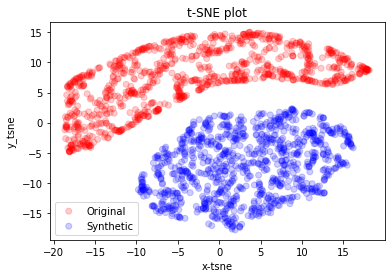

In [63]:
visualization(data, test_recovery.detach().numpy(), 'tsne')

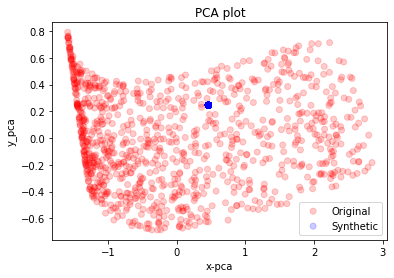

In [64]:
visualization(data, test_recovery.detach().numpy(), 'pca')

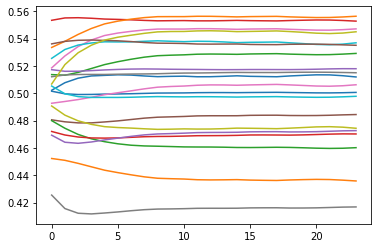

In [81]:
fig, ax = plt.subplots()
ax1 = plt.plot(test[0].detach().numpy())


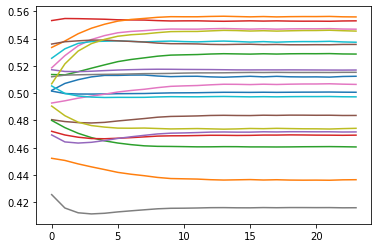

In [83]:
fig, ax = plt.subplots()
ax1 = plt.plot(test[5000].detach().numpy())

In [82]:
test[0].shape

torch.Size([24, 20])

In [80]:
test[5000]

tensor([[0.5021, 0.4522, 0.5137, 0.5533, 0.5172, 0.4806, 0.5186, 0.5120, 0.4906,
         0.5256, 0.5015, 0.5336, 0.4800, 0.4720, 0.4694, 0.5361, 0.4928, 0.4256,
         0.5069, 0.5053],
        [0.5072, 0.4507, 0.5135, 0.5548, 0.5160, 0.4792, 0.5276, 0.5133, 0.4835,
         0.5326, 0.4997, 0.5383, 0.4747, 0.4693, 0.4642, 0.5378, 0.4944, 0.4157,
         0.5215, 0.4998],
        [0.5099, 0.4481, 0.5158, 0.5547, 0.5158, 0.4784, 0.5348, 0.5135, 0.4787,
         0.5365, 0.4994, 0.5436, 0.4706, 0.4677, 0.4634, 0.5384, 0.4963, 0.4122,
         0.5309, 0.4979],
        [0.5120, 0.4459, 0.5183, 0.5545, 0.5161, 0.4781, 0.5394, 0.5137, 0.4763,
         0.5379, 0.4994, 0.5477, 0.4674, 0.4667, 0.4640, 0.5390, 0.4979, 0.4114,
         0.5364, 0.4971],
        [0.5131, 0.4439, 0.5208, 0.5543, 0.5166, 0.4786, 0.5423, 0.5138, 0.4751,
         0.5381, 0.4994, 0.5506, 0.4650, 0.4666, 0.4652, 0.5390, 0.4993, 0.4119,
         0.5395, 0.4968],
        [0.5131, 0.4419, 0.5232, 0.5539, 0.5170, 0.4796, 0.5

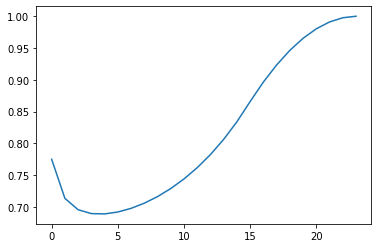

In [75]:
fig, ax = plt.subplots()
ax1 = plt.plot(data[0].detach().numpy())


In [66]:
test_recovery[0]

tensor([[0.5207],
        [0.5224],
        [0.5233],
        [0.5236],
        [0.5238],
        [0.5239],
        [0.5240],
        [0.5240],
        [0.5240],
        [0.5240],
        [0.5241],
        [0.5241],
        [0.5241],
        [0.5241],
        [0.5241],
        [0.5241],
        [0.5241],
        [0.5241],
        [0.5241],
        [0.5241],
        [0.5241],
        [0.5242],
        [0.5242],
        [0.5242]], grad_fn=<SelectBackward>)

In [78]:
test_recovery[5000]

tensor([[0.5207],
        [0.5224],
        [0.5233],
        [0.5236],
        [0.5238],
        [0.5239],
        [0.5239],
        [0.5240],
        [0.5240],
        [0.5240],
        [0.5241],
        [0.5241],
        [0.5241],
        [0.5241],
        [0.5241],
        [0.5241],
        [0.5241],
        [0.5241],
        [0.5241],
        [0.5241],
        [0.5241],
        [0.5241],
        [0.5241],
        [0.5241]], grad_fn=<SelectBackward>)

In [74]:
test_recovery

tensor([[[0.5207],
         [0.5224],
         [0.5233],
         ...,
         [0.5242],
         [0.5242],
         [0.5242]],

        [[0.5207],
         [0.5224],
         [0.5232],
         ...,
         [0.5241],
         [0.5241],
         [0.5242]],

        [[0.5207],
         [0.5224],
         [0.5232],
         ...,
         [0.5242],
         [0.5242],
         [0.5242]],

        ...,

        [[0.5207],
         [0.5224],
         [0.5233],
         ...,
         [0.5241],
         [0.5241],
         [0.5241]],

        [[0.5207],
         [0.5224],
         [0.5233],
         ...,
         [0.5241],
         [0.5242],
         [0.5242]],

        [[0.5207],
         [0.5224],
         [0.5232],
         ...,
         [0.5241],
         [0.5241],
         [0.5241]]], grad_fn=<ViewBackward>)